# ann-project

5조
한수호, 강구현, 김민규, 홍준기

# Setup

In [ ]:
from datetime import datetime
from models.resnet50 import ResNetModel
from models.lenet import LeNetModel
from keras import models, callbacks, optimizers, layers, losses
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
import time
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import json
import seaborn as sns
import random
from IPython.display import display
from sklearn.metrics import confusion_matrix, f1_score
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

2024-06-10 14:57:38.584284: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-10 14:57:38.584325: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-10 14:57:38.584360: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-10 14:57:38.591157: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2024-06-10 14:57:39.297552: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)
os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)

In [ ]:
from datetime import datetime
result_path = './results'
_time = datetime.strftime(datetime.today(), '%Y-%m-%d_%H-%M-%S')

dataset

In [ ]:
train_file_path = '../../../../mnt/sda/suhohan/emnist/emnist-byclass-train.csv'
test_file_path = '../../../../mnt/sda/suhohan/emnist/emnist-byclass-test.csv'

train_data = pd.read_csv(train_file_path)
test_data = pd.read_csv(test_file_path)

num_train_samples = train_data.shape[0]
num_test_samples = test_data.shape[0]

x_train = train_data.iloc[:, 1:].to_numpy().reshape((num_train_samples, 28, 28, 1))
x_test = test_data.iloc[:, 1:].to_numpy().reshape((num_test_samples, 28, 28, 1))
y_train = tf.keras.utils.to_categorical(train_data.iloc[:, 0], 62)
y_test_bymerge = tf.keras.utils.to_categorical(test_data.iloc[:, 0], 62)

y_train_int = train_data.iloc[:, 0].to_numpy()
y_test_int = test_data.iloc[:, 0].to_numpy()

_, _, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.1, random_state=42)
x_train, x_valid, y_train_int, y_valid_int = train_test_split(x_train, y_train_int, test_size=0.1, random_state=42)

x_train_resized = tf.image.resize(x_train, [32, 32])
x_valid_resized = tf.image.resize(x_valid, [32, 32])
x_test_resized = tf.image.resize(x_test, [32, 32])

# %% [markdown]
# checkpoints

2024-06-10 14:58:06.936716: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-10 14:58:07.061603: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-10 14:58:07.061909: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

checkpoints

In [ ]:
def create_callbacks(model_name):
    current_time = int(time.time())
    checkpoint_path = f"./checkpoints/checkpoints_{model_name}/weights.{current_time}.hdf5"
    early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=5,
                                             min_delta=0.0001, restore_best_weights=True)
    reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.000001)
    checkpoint = callbacks.ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)

    return [early_stopping, reduce_lr, checkpoint]


callbacks_lenet = create_callbacks('lenet')
callbacks_resnet = create_callbacks('resnet')
callbacks_ours_1 = create_callbacks('ours_1')
callbacks_ours_2 = create_callbacks('ours_2')
callbacks_final = create_callbacks('final')
result_path = './results'

test results

In [ ]:
def save_results(results_df):
    if not os.path.exists(result_path):
        os.makedirs(result_path)
    results_df.to_csv(os.path.join(result_path, f'result_{_time}.csv'), index=False)

saving history

In [ ]:
def save_history(histories, filename):
    with open(os.path.join(result_path, filename), 'w') as f:
        json.dump(histories, f)

# 1. baseline과 our 모델 비교

In [ ]:
class CNNModel:
    def __init__(self):
        self.model = self.build_model()

    def build_model(self):
        model = models.Sequential([
            layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(64, (3, 3), activation='relu'),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(64, (3, 3), activation='relu'),
            layers.Flatten(),
            layers.Dense(64, activation='relu'),
            layers.Dense(62, activation='softmax')
        ])
        return model

    def compile(self, optimizer, loss, metrics):
        self.model.compile(optimizer, loss, metrics)

    def train(self, x_train, y_train, validation_data, epochs=50, batch_size=300, callbacks=None, class_weight=None):
        return self.model.fit(x_train, y_train, validation_data=validation_data, batch_size=batch_size, epochs=epochs, callbacks=callbacks, class_weight=class_weight)

    def evaluate(self, x_test, y_test):
        return self.model.evaluate(x_test, y_test)

    def summary(self):
        return self.model.summary()

In [ ]:
class ResModel:
    def __init__(self, num_classes=62, initial_filters=32, dropout_rate=0.3, final_dropout_rate=0.6, activation='ReLU', num_residual_units=3):
        self.num_classes = num_classes
        self.initial_filters = initial_filters
        self.dropout_rate = dropout_rate
        self.final_dropout_rate = final_dropout_rate
        self.activation = activation
        self.num_residual_units = num_residual_units
        self.model = self.build_model()

    def residual_block(self, x, filters, kernel_size=3, stride=1):
        y = layers.Conv2D(filters, kernel_size, strides=stride, padding='same')(x)
        y = layers.BatchNormalization()(y)
        y = self._get_activation()(y)
        y = layers.Conv2D(filters, kernel_size, strides=1, padding='same')(y)
        y = layers.BatchNormalization()(y)

        if stride != 1 or x.shape[-1] != filters:
            x = layers.Conv2D(filters, 1, strides=stride, padding='same')(x)
            x = layers.BatchNormalization()(x)

        out = layers.Add()([x, y])
        out = self._get_activation()(out)
        return out

    def build_model(self):
        input = layers.Input(shape=(28, 28, 1))
        x = layers.Conv2D(self.initial_filters, (3, 3), padding='same')(input)
        x = layers.BatchNormalization()(x)
        x = self._get_activation()(x)
        x = layers.Dropout(self.dropout_rate)(x)
        x = layers.AveragePooling2D(pool_size=2, strides=2, padding='same')(x)

        filters = self.initial_filters * 2
        for _ in range(self.num_residual_units):
            x = self.residual_block(x, filters)
            x = layers.Dropout(self.dropout_rate)(x)
            x = layers.AveragePooling2D(pool_size=2, strides=2, padding='same')(x)
            filters *= 2

        x = layers.Flatten()(x)
        x = layers.Dense(512)(x)
        x = layers.BatchNormalization()(x)
        x = self._get_activation()(x)
        x = layers.Dropout(self.final_dropout_rate)(x)

        output = layers.Dense(self.num_classes, activation='softmax')(x)

        model = models.Model(inputs=input, outputs=output)

        return model

    def _get_activation(self):
        if self.activation == 'swish':
            return layers.Activation('swish')
        elif self.activation == 'prelu':
            return layers.PReLU(shared_axes=[1, 2])
        else:
            return layers.Activation(self.activation)

    def compile(self, optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']):
        self.model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    def train(self, x_train, y_train, validation_data, epochs=50, batch_size=300, callbacks=None, class_weight=None):
        return self.model.fit(x_train, y_train, validation_data=validation_data,
                              batch_size=batch_size, epochs=epochs, callbacks=callbacks,
                              class_weight=class_weight)

    def evaluate(self, x_test, y_test):
        return self.model.evaluate(x_test, y_test)

    def predict(self, x_test):
        return self.model.predict(x_test)

    def summary(self):
        return self.model.summary()

In [ ]:
# Initialize models
lenet_model = LeNetModel()
resnet_model = ResNetModel()
our_model_1 = CNNModel()
our_model_2res = ResModel()

# Compile models
lenet_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
resnet_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
our_model_1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
our_model_2res.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = []
training_time = []

In [ ]:
EPOCHS = 50
BATCH_SIZE = 500

In [ ]:
start_time = time.time()
history.append(lenet_model.train(x_train, y_train_int, validation_data=(x_valid, y_valid_int),
               epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[callbacks_lenet]))
end_time = time.time()
training_time.append(end_time-start_time)

Epoch 1/50


2024-06-10 15:40:14.935523: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8800
2024-06-10 15:40:16.027814: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x60c25691cf30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-06-10 15:40:16.027854: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2024-06-10 15:40:16.035608: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-10 15:40:16.134634: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1257/1257 [==============================] - ETA: 0s - loss: 0.6579 - accuracy: 0.7952
Epoch 1: val_loss improved from inf to 0.46410, saving model to ./checkpoints/checkpoints_lenet/weights.1718001605.hdf5
1257/1257 [==============================] - 11s 6ms/step - loss: 0.6579 - accuracy: 0.7952 - val_loss: 0.4641 - val_accuracy: 0.8388 - lr: 0.0010
Epoch 2/50
  32/1257 [..............................] - ETA: 6s - loss: 0.4608 - accuracy: 0.8418

/home/suhohan/anaconda3/envs/ann/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1254/1257 [============================>.] - ETA: 0s - loss: 0.4344 - accuracy: 0.8461
Epoch 2: val_loss improved from 0.46410 to 0.42688, saving model to ./checkpoints/checkpoints_lenet/weights.1718001605.hdf5
1257/1257 [==============================] - 6s 5ms/step - loss: 0.4345 - accuracy: 0.8461 - val_loss: 0.4269 - val_accuracy: 0.8487 - lr: 0.0010
Epoch 3/50
1254/1257 [============================>.] - ETA: 0s - loss: 0.4081 - accuracy: 0.8527
Epoch 3: val_loss improved from 0.42688 to 0.41574, saving model to ./checkpoints/checkpoints_lenet/weights.1718001605.hdf5
1257/1257 [==============================] - 7s 5ms/step - loss: 0.4082 - accuracy: 0.8527 - val_loss: 0.4157 - val_accuracy: 0.8495 - lr: 0.0010
Epoch 4/50
1255/1257 [============================>.] - ETA: 0s - loss: 0.3934 - accuracy: 0.8568
Epoch 4: val_loss improved from 0.41574 to 0.40265, saving model to ./checkpoints/checkpoints_lenet/weights.1718001605.hdf5
1257/1257 [==============================] - 6s 4ms/s

In [ ]:
start_time = time.time()
history.append(resnet_model.train(x_train_resized, y_train_int, validation_data=(x_valid_resized,
               y_valid_int), epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[callbacks_resnet]))
end_time = time.time()
training_time.append(end_time-start_time)

Epoch 1/50
1257/1257 [==============================] - ETA: 0s - loss: 0.5908 - accuracy: 0.8106
Epoch 1: val_loss improved from inf to 0.44840, saving model to ./checkpoints/checkpoints_resnet/weights.1718001605.hdf5
1257/1257 [==============================] - 90s 55ms/step - loss: 0.5908 - accuracy: 0.8106 - val_loss: 0.4484 - val_accuracy: 0.8379 - lr: 0.0010
Epoch 2/50
1257/1257 [==============================] - ETA: 0s - loss: 0.3883 - accuracy: 0.8571
Epoch 2: val_loss improved from 0.44840 to 0.40625, saving model to ./checkpoints/checkpoints_resnet/weights.1718001605.hdf5
1257/1257 [==============================] - 67s 53ms/step - loss: 0.3883 - accuracy: 0.8571 - val_loss: 0.4062 - val_accuracy: 0.8546 - lr: 0.0010
Epoch 3/50
1256/1257 [============================>.] - ETA: 0s - loss: 0.3685 - accuracy: 0.8631
Epoch 3: val_loss improved from 0.40625 to 0.40201, saving model to ./checkpoints/checkpoints_resnet/weights.1718001605.hdf5
1257/1257 [============================

In [ ]:
start_time = time.time()
history.append(our_model_1.train(x_train, y_train_int, validation_data=(x_valid, y_valid_int),
               epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[callbacks_ours_1]))
end_time = time.time()
training_time.append(end_time-start_time)

Epoch 1/50
1257/1257 [==============================] - ETA: 0s - loss: 0.8523 - accuracy: 0.7622
Epoch 1: val_loss improved from inf to 0.48392, saving model to ./checkpoints/checkpoints_ours_1/weights.1718001605.hdf5
1257/1257 [==============================] - 8s 6ms/step - loss: 0.8523 - accuracy: 0.7622 - val_loss: 0.4839 - val_accuracy: 0.8325 - lr: 0.0010
Epoch 2/50
1257/1257 [==============================] - ETA: 0s - loss: 0.4515 - accuracy: 0.8406
Epoch 2: val_loss improved from 0.48392 to 0.44358, saving model to ./checkpoints/checkpoints_ours_1/weights.1718001605.hdf5
1257/1257 [==============================] - 7s 5ms/step - loss: 0.4515 - accuracy: 0.8406 - val_loss: 0.4436 - val_accuracy: 0.8438 - lr: 0.0010
Epoch 3/50
1248/1257 [============================>.] - ETA: 0s - loss: 0.4168 - accuracy: 0.8501
Epoch 3: val_loss improved from 0.44358 to 0.42881, saving model to ./checkpoints/checkpoints_ours_1/weights.1718001605.hdf5
1257/1257 [==============================] 

In [ ]:
start_time = time.time()
history.append(our_model_2res.train(x_train, y_train_int, validation_data=(x_valid, y_valid_int),
               epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[callbacks_ours_2]))
end_time = time.time()
training_time.append(end_time-start_time)

Epoch 1/50


2024-06-10 16:06:31.283745: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1257/1257 [==============================] - ETA: 0s - loss: 0.5702 - accuracy: 0.8126
Epoch 1: val_loss improved from inf to 0.40755, saving model to ./checkpoints/checkpoints_ours_2/weights.1718001605.hdf5
1257/1257 [==============================] - 33s 21ms/step - loss: 0.5702 - accuracy: 0.8126 - val_loss: 0.4076 - val_accuracy: 0.8521 - lr: 0.0010
Epoch 2/50
1255/1257 [============================>.] - ETA: 0s - loss: 0.4019 - accuracy: 0.8544
Epoch 2: val_loss improved from 0.40755 to 0.37473, saving model to ./checkpoints/checkpoints_ours_2/weights.1718001605.hdf5
1257/1257 [==============================] - 26s 21ms/step - loss: 0.4020 - accuracy: 0.8544 - val_loss: 0.3747 - val_accuracy: 0.8608 - lr: 0.0010
Epoch 3/50
1255/1257 [============================>.] - ETA: 0s - loss: 0.3799 - accuracy: 0.8607
Epoch 3: val_loss improved from 0.37473 to 0.34580, saving model to ./checkpoints/checkpoints_ours_2/weights.1718001605.hdf5
1257/1257 [==============================] - 26s 2

In [ ]:
loss_lenet, acc_lenet = lenet_model.evaluate(x_test, y_test_int)
loss_resnet, acc_resnet = resnet_model.evaluate(x_test_resized, y_test_int)
loss_our1, acc_our1 = our_model_1.evaluate(x_test, y_test_int)
loss_our2, acc_our2 = our_model_2res.evaluate(x_test, y_test_int)

3636/3636 [==============================] - 8s 2ms/step - loss: 0.3078 - accuracy: 0.8834


In [ ]:
results = {
    "Model": ["LeNet-5", "ResNet-50", "Our Model(CNN)", "Our Model(Residual)"],
    "Loss": [loss_lenet, loss_resnet, loss_our1, loss_our2],
    "Accuracy": [acc_lenet, acc_resnet, acc_our1, acc_our2],
    "Training Time": training_time
}
results_df = pd.DataFrame(results)
results_df.to_csv(f'{result_path}/result_{_time}.csv', index=False)

In [ ]:
models = ["lenet-5", "resnet-50", "our_model_cnn", "our_model_residual"]

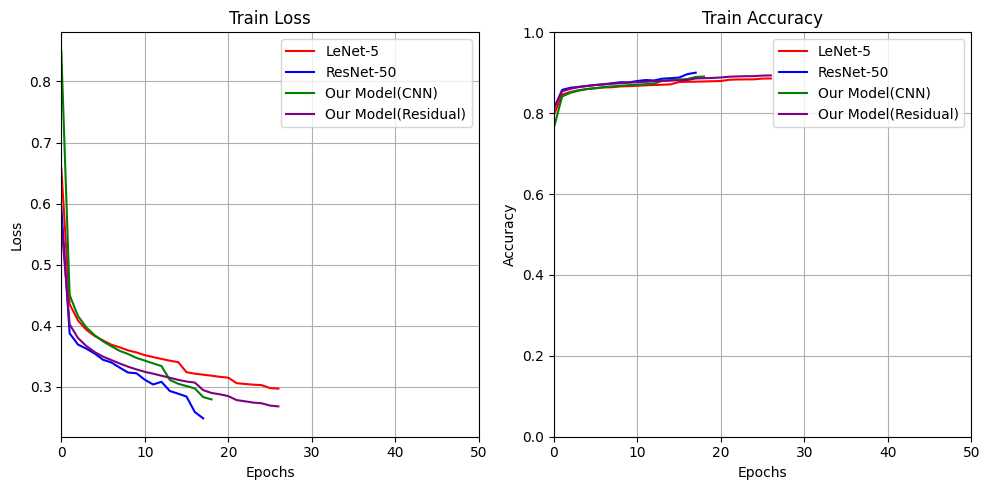

In [ ]:
colors = ["red", "blue", "green", "purple", "gold"]

plt.figure(figsize=(10, 5))

plt.subplot(121)
for idx, hist in enumerate(history):
    plt.plot(hist.history['loss'], label=f'{results["Model"][idx]}', color=colors[idx])
    plt.title(f'Train Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.xlim([0, EPOCHS])
    plt.grid(True)
    plt.legend()
plt.subplot(122)
for idx, hist in enumerate(history):
    plt.plot(hist.history['accuracy'], label=f'{results["Model"][idx]}', color=colors[idx])
    plt.title(f'Train Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.xlim([0, EPOCHS])
    plt.ylim([0, 1])
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.show()
for model, h in zip(results['Model'], history):
    history_dict = {key: list(map(float, value)) for key, value in h.history.items()}
    save_history(history_dict, f'history_model_{model}_{_time}.json')

In [ ]:
training_time.append("")
results = {
    "Model": ["LeNet-5", "ResNet-50", "Our Model(CNN)", "Our Model(Residual)", "Wavemix-256[6]"],
    "Loss": [loss_lenet, loss_resnet, loss_our1, loss_our2, 0],
    "Accuracy": [acc_lenet, acc_resnet, acc_our1, acc_our2, 0.8842],
    "Training Time": training_time
}
results_df = pd.DataFrame(results)

# 2. Experiment

## 2.1. Optimizer

In [ ]:
optimizers_list = [
    optimizers.SGD(learning_rate=0.001, momentum=0.9),
    optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True),
    optimizers.Adagrad(learning_rate=0.001),
    optimizers.RMSprop(learning_rate=0.001, rho=0.9),
    optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999),
    optimizers.Adamax(learning_rate=0.001, beta_1=0.9, beta_2=0.999),
    optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999),
]

In [ ]:
history = []
results = {'Optimizer': [], 'Loss': [], 'Accuracy': [], 'Training Time': []}

In [ ]:
def _train_opt(x_train, y_train, validation_data, optimizer, activation_ftn='ReLU'):
    final_model = ResModel(num_classes=62, initial_filters=32,
                           dropout_rate=0.3, final_dropout_rate=0.6, activation=activation_ftn, num_residual_units=3)
    optimizer.build(final_model.model.trainable_variables)

    final_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    start_time = time.time()
    hist = final_model.train(x_train, y_train, validation_data=validation_data, epochs=EPOCHS,
                             batch_size=BATCH_SIZE, callbacks=[callbacks_final])
    end_time = time.time()

    history.append(hist)

    loss, accuracy = final_model.evaluate(x_test, y_test_int)
    results['Optimizer'].append(type(optimizer).__name__)
    results['Loss'].append(loss)
    results['Accuracy'].append(accuracy)
    results['Training Time'].append(end_time - start_time)

In [ ]:
EPOCHS = 50
BATCH_SIZE = 500

In [ ]:
for optimizer in optimizers_list:
    _train_opt(x_train, y_train_int, (x_valid, y_valid_int), optimizer, activation_ftn='ReLU')

Epoch 1/50


2024-06-10 16:48:19.265678: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_2/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1256/1257 [============================>.] - ETA: 0s - loss: 1.6039 - accuracy: 0.5895
Epoch 1: val_loss improved from inf to 0.68501, saving model to ./checkpoints/checkpoints_final/weights.1718001605.hdf5
1257/1257 [==============================] - 28s 21ms/step - loss: 1.6038 - accuracy: 0.5896 - val_loss: 0.6850 - val_accuracy: 0.7831 - lr: 0.0010
Epoch 2/50
1256/1257 [============================>.] - ETA: 0s - loss: 0.8096 - accuracy: 0.7529
Epoch 2: val_loss improved from 0.68501 to 0.51931, saving model to ./checkpoints/checkpoints_final/weights.1718001605.hdf5
1257/1257 [==============================] - 26s 20ms/step - loss: 0.8095 - accuracy: 0.7529 - val_loss: 0.5193 - val_accuracy: 0.8248 - lr: 0.0010
Epoch 3/50
1257/1257 [==============================] - ETA: 0s - loss: 0.6617 - accuracy: 0.7870
Epoch 3: val_loss improved from 0.51931 to 0.47310, saving model to ./checkpoints/checkpoints_final/weights.1718001605.hdf5
1257/1257 [==============================] - 26s 20ms

2024-06-10 17:09:49.869883: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_3/dropout_10/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1255/1257 [============================>.] - ETA: 0s - loss: 1.5776 - accuracy: 0.5940
Epoch 1: val_loss did not improve from 0.34558
1257/1257 [==============================] - 28s 20ms/step - loss: 1.5769 - accuracy: 0.5942 - val_loss: 0.6831 - val_accuracy: 0.7816 - lr: 0.0010
Epoch 2/50
1255/1257 [============================>.] - ETA: 0s - loss: 0.8052 - accuracy: 0.7525
Epoch 2: val_loss did not improve from 0.34558
1257/1257 [==============================] - 25s 20ms/step - loss: 0.8052 - accuracy: 0.7526 - val_loss: 0.5185 - val_accuracy: 0.8250 - lr: 0.0010
Epoch 3/50
1255/1257 [============================>.] - ETA: 0s - loss: 0.6622 - accuracy: 0.7866
Epoch 3: val_loss did not improve from 0.34558
1257/1257 [==============================] - 26s 21ms/step - loss: 0.6624 - accuracy: 0.7865 - val_loss: 0.4804 - val_accuracy: 0.8341 - lr: 0.0010
Epoch 4/50
1255/1257 [============================>.] - ETA: 0s - loss: 0.5937 - accuracy: 0.8041
Epoch 4: val_loss did not improve 

2024-06-10 17:31:25.337283: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_4/dropout_15/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1257/1257 [==============================] - ETA: 0s - loss: 2.3972 - accuracy: 0.4283
Epoch 1: val_loss did not improve from 0.33917
1257/1257 [==============================] - 29s 21ms/step - loss: 2.3972 - accuracy: 0.4283 - val_loss: 1.1649 - val_accuracy: 0.6839 - lr: 0.0010
Epoch 2/50
1257/1257 [==============================] - ETA: 0s - loss: 1.3898 - accuracy: 0.6272
Epoch 2: val_loss did not improve from 0.33917
1257/1257 [==============================] - 26s 20ms/step - loss: 1.3898 - accuracy: 0.6272 - val_loss: 0.8516 - val_accuracy: 0.7439 - lr: 0.0010
Epoch 3/50
1257/1257 [==============================] - ETA: 0s - loss: 1.1072 - accuracy: 0.6845
Epoch 3: val_loss did not improve from 0.33917
1257/1257 [==============================] - 26s 20ms/step - loss: 1.1072 - accuracy: 0.6845 - val_loss: 0.7096 - val_accuracy: 0.7771 - lr: 0.0010
Epoch 4/50
1257/1257 [==============================] - ETA: 0s - loss: 0.9567 - accuracy: 0.7177
Epoch 4: val_loss did not improve 

2024-06-10 17:53:10.147449: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_5/dropout_20/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1255/1257 [============================>.] - ETA: 0s - loss: 0.5519 - accuracy: 0.8158
Epoch 1: val_loss did not improve from 0.33917
1257/1257 [==============================] - 29s 19ms/step - loss: 0.5517 - accuracy: 0.8158 - val_loss: 0.4018 - val_accuracy: 0.8546 - lr: 0.0010
Epoch 2/50
1255/1257 [============================>.] - ETA: 0s - loss: 0.4000 - accuracy: 0.8559
Epoch 2: val_loss did not improve from 0.33917
1257/1257 [==============================] - 24s 19ms/step - loss: 0.4000 - accuracy: 0.8559 - val_loss: 0.3892 - val_accuracy: 0.8612 - lr: 0.0010
Epoch 3/50
1255/1257 [============================>.] - ETA: 0s - loss: 0.3791 - accuracy: 0.8620
Epoch 3: val_loss did not improve from 0.33917
1257/1257 [==============================] - 24s 19ms/step - loss: 0.3792 - accuracy: 0.8619 - val_loss: 0.4123 - val_accuracy: 0.8486 - lr: 0.0010
Epoch 4/50
1255/1257 [============================>.] - ETA: 0s - loss: 0.3672 - accuracy: 0.8656
Epoch 4: val_loss did not improve 

2024-06-10 18:01:39.114465: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_6/dropout_25/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1255/1257 [============================>.] - ETA: 0s - loss: 0.5761 - accuracy: 0.8104
Epoch 1: val_loss did not improve from 0.32035
1257/1257 [==============================] - 29s 20ms/step - loss: 0.5760 - accuracy: 0.8104 - val_loss: 0.3913 - val_accuracy: 0.8558 - lr: 0.0010
Epoch 2/50
1255/1257 [============================>.] - ETA: 0s - loss: 0.4028 - accuracy: 0.8542
Epoch 2: val_loss did not improve from 0.32035
1257/1257 [==============================] - 25s 20ms/step - loss: 0.4029 - accuracy: 0.8542 - val_loss: 0.3613 - val_accuracy: 0.8664 - lr: 0.0010
Epoch 3/50
1255/1257 [============================>.] - ETA: 0s - loss: 0.3800 - accuracy: 0.8607
Epoch 3: val_loss did not improve from 0.32035
1257/1257 [==============================] - 25s 20ms/step - loss: 0.3800 - accuracy: 0.8607 - val_loss: 0.3529 - val_accuracy: 0.8692 - lr: 0.0010
Epoch 4/50
1255/1257 [============================>.] - ETA: 0s - loss: 0.3668 - accuracy: 0.8643
Epoch 4: val_loss did not improve 

2024-06-10 18:11:51.330182: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_7/dropout_30/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1255/1257 [============================>.] - ETA: 0s - loss: 0.6904 - accuracy: 0.7850
Epoch 1: val_loss did not improve from 0.31551
1257/1257 [==============================] - 29s 20ms/step - loss: 0.6902 - accuracy: 0.7850 - val_loss: 0.4124 - val_accuracy: 0.8502 - lr: 0.0010
Epoch 2/50
1255/1257 [============================>.] - ETA: 0s - loss: 0.4322 - accuracy: 0.8471
Epoch 2: val_loss did not improve from 0.31551
1257/1257 [==============================] - 25s 20ms/step - loss: 0.4323 - accuracy: 0.8471 - val_loss: 0.3837 - val_accuracy: 0.8608 - lr: 0.0010
Epoch 3/50
1255/1257 [============================>.] - ETA: 0s - loss: 0.3936 - accuracy: 0.8575
Epoch 3: val_loss did not improve from 0.31551
1257/1257 [==============================] - 25s 20ms/step - loss: 0.3936 - accuracy: 0.8575 - val_loss: 0.3655 - val_accuracy: 0.8659 - lr: 0.0010
Epoch 4/50
1255/1257 [============================>.] - ETA: 0s - loss: 0.3750 - accuracy: 0.8627
Epoch 4: val_loss did not improve 

2024-06-10 18:24:56.416749: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_8/dropout_35/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1256/1257 [============================>.] - ETA: 0s - loss: 0.5718 - accuracy: 0.8126
Epoch 1: val_loss did not improve from 0.31264
1257/1257 [==============================] - 38s 24ms/step - loss: 0.5718 - accuracy: 0.8126 - val_loss: 0.4059 - val_accuracy: 0.8505 - lr: 0.0010
Epoch 2/50
1255/1257 [============================>.] - ETA: 0s - loss: 0.4005 - accuracy: 0.8548
Epoch 2: val_loss did not improve from 0.31264
1257/1257 [==============================] - 30s 24ms/step - loss: 0.4006 - accuracy: 0.8548 - val_loss: 0.3688 - val_accuracy: 0.8638 - lr: 0.0010
Epoch 3/50
1257/1257 [==============================] - ETA: 0s - loss: 0.3790 - accuracy: 0.8610
Epoch 3: val_loss did not improve from 0.31264
1257/1257 [==============================] - 29s 23ms/step - loss: 0.3790 - accuracy: 0.8610 - val_loss: 0.3532 - val_accuracy: 0.8683 - lr: 0.0010
Epoch 4/50
1256/1257 [============================>.] - ETA: 0s - loss: 0.3658 - accuracy: 0.8651
Epoch 4: val_loss did not improve 

In [ ]:
results_df = pd.DataFrame(results)
save_results(results_df)
for optimizer, h in zip(optimizers_list, history):
    history_dict = {key: list(map(float, value)) for key, value in h.history.items()}
    save_history(history_dict, f'history_optimizer_{type(optimizer).__name__}_{_time}.json')

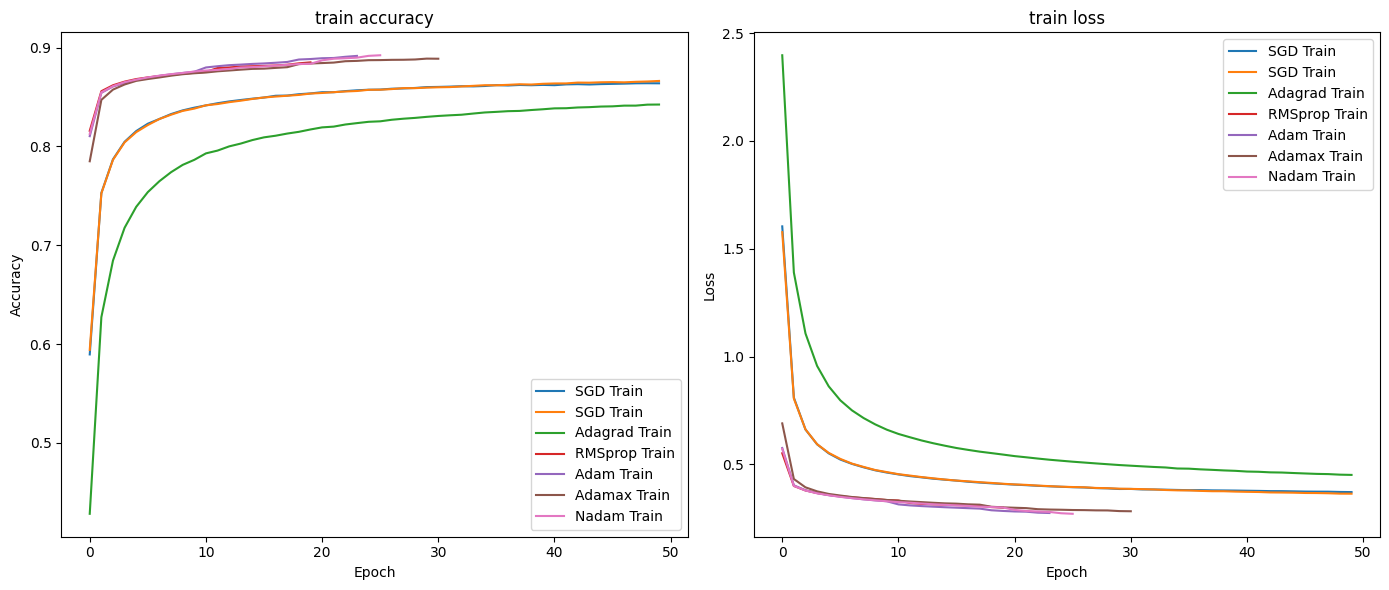

In [ ]:
plt.figure(figsize=(14, 6))

for i, h in enumerate(history):
    plt.subplot(1, 2, 1)
    plt.plot(h.history['accuracy'], label=f'{type(optimizers_list[i]).__name__} Train')
    plt.title('train accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')

    plt.subplot(1, 2, 2)
    plt.plot(h.history['loss'], label=f'{type(optimizers_list[i]).__name__} Train')
    plt.title('train loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='best')

plt.tight_layout()
plt.show()

## 2.2. Activation Function

In [ ]:
activations = {
    'relu': layers.ReLU(),
    'leaky_relu': layers.LeakyReLU(),
    'elu': layers.ELU(),
    'selu': layers.Activation('selu'),
    'sigmoid': layers.Activation('sigmoid'),
    'tanh': layers.Activation('tanh'),
    'softmax': layers.Activation('softmax'),
    'softsign': layers.Activation('softsign'),
    'swish': layers.Activation('swish'),
    'gelu': layers.Activation('gelu')
}

In [ ]:
history = []
results = {'Activation Function': [], 'Loss': [], 'Accuracy': [], 'Training Time': []}

In [ ]:
best_optimizer = optimizers.legacy.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
activation_functions = ['relu', 'leaky_relu', 'elu', 'selu', 'sigmoid', 'tanh',
                        'softmax', 'softsign', 'swish', 'gelu']

In [ ]:
def _train_act(x_train, y_train, validation_data, optimizer, activation_ftn):
    activation_layer = activations.get(activation_ftn, layers.ReLU())

    final_model = ResModel(num_classes=62, initial_filters=32, dropout_rate=0.3,
                           final_dropout_rate=0.6, activation=activation_layer, num_residual_units=3)
    final_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    start_time = time.time()
    hist = final_model.train(x_train, y_train, validation_data=validation_data, epochs=EPOCHS,
                             batch_size=BATCH_SIZE, callbacks=[callbacks_final])
    end_time = time.time()

    history.append(hist)

    loss, accuracy = final_model.evaluate(x_test, y_test_int)
    results['Activation Function'].append(activation_ftn)
    results['Loss'].append(loss)
    results['Accuracy'].append(accuracy)
    results['Training Time'].append(end_time - start_time)

In [ ]:
EPOCHS = 50
BATCH_SIZE = 500

In [ ]:
for ftn in activation_functions:
    _train_act(x_train, y_train_int, (x_valid, y_valid_int), optimizer=best_optimizer, activation_ftn=ftn)

2024-06-11 03:34:17.586398: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-11 03:34:17.614978: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-11 03:34:17.615367: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Epoch 1/50


2024-06-11 03:34:27.842949: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-06-11 03:34:29.099958: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8800


1047/1047 [==============================] - ETA: 0s - loss: 0.5743 - accuracy: 0.8124
Epoch 1: val_loss improved from inf to 0.38325, saving model to ./checkpoints/checkpoints_final/weights.1718044457.hdf5
1047/1047 [==============================] - 33s 26ms/step - loss: 0.5743 - accuracy: 0.8124 - val_loss: 0.3832 - val_accuracy: 0.8597 - lr: 0.0010
Epoch 2/50
   4/1047 [..............................] - ETA: 22s - loss: 0.4006 - accuracy: 0.8579

/home/suhohan/anaconda3/envs/ann/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1047/1047 [==============================] - ETA: 0s - loss: 0.3990 - accuracy: 0.8556
Epoch 2: val_loss improved from 0.38325 to 0.35851, saving model to ./checkpoints/checkpoints_final/weights.1718044457.hdf5
1047/1047 [==============================] - 26s 25ms/step - loss: 0.3990 - accuracy: 0.8556 - val_loss: 0.3585 - val_accuracy: 0.8679 - lr: 0.0010
Epoch 3/50
1046/1047 [============================>.] - ETA: 0s - loss: 0.3773 - accuracy: 0.8616
Epoch 3: val_loss improved from 0.35851 to 0.35651, saving model to ./checkpoints/checkpoints_final/weights.1718044457.hdf5
1047/1047 [==============================] - 26s 25ms/step - loss: 0.3773 - accuracy: 0.8615 - val_loss: 0.3565 - val_accuracy: 0.8694 - lr: 0.0010
Epoch 4/50
1045/1047 [============================>.] - ETA: 0s - loss: 0.3640 - accuracy: 0.8654
Epoch 4: val_loss improved from 0.35651 to 0.34164, saving model to ./checkpoints/checkpoints_final/weights.1718044457.hdf5
1047/1047 [==============================] - 27s 

2024-06-11 03:45:26.282945: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1047/1047 [==============================] - ETA: 0s - loss: 0.5945 - accuracy: 0.8047
Epoch 1: val_loss did not improve from 0.31706
1047/1047 [==============================] - 29s 26ms/step - loss: 0.5945 - accuracy: 0.8047 - val_loss: 0.4088 - val_accuracy: 0.8516 - lr: 2.5000e-04
Epoch 2/50
1045/1047 [============================>.] - ETA: 0s - loss: 0.4330 - accuracy: 0.8462
Epoch 2: val_loss did not improve from 0.31706
1047/1047 [==============================] - 27s 26ms/step - loss: 0.4331 - accuracy: 0.8462 - val_loss: 0.3792 - val_accuracy: 0.8610 - lr: 2.5000e-04
Epoch 3/50
1047/1047 [==============================] - ETA: 0s - loss: 0.4049 - accuracy: 0.8541
Epoch 3: val_loss did not improve from 0.31706
1047/1047 [==============================] - 27s 26ms/step - loss: 0.4049 - accuracy: 0.8541 - val_loss: 0.3700 - val_accuracy: 0.8631 - lr: 2.5000e-04
Epoch 4/50
1045/1047 [============================>.] - ETA: 0s - loss: 0.3897 - accuracy: 0.8584
Epoch 4: val_loss did 

2024-06-11 04:05:08.760965: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_2/dropout_10/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1047/1047 [==============================] - ETA: 0s - loss: 1.3524 - accuracy: 0.6298
Epoch 1: val_loss did not improve from 0.31498
1047/1047 [==============================] - 30s 26ms/step - loss: 1.3524 - accuracy: 0.6298 - val_loss: 0.6575 - val_accuracy: 0.7912 - lr: 1.5625e-05
Epoch 2/50
1046/1047 [============================>.] - ETA: 0s - loss: 0.8604 - accuracy: 0.7361
Epoch 2: val_loss did not improve from 0.31498
1047/1047 [==============================] - 27s 26ms/step - loss: 0.8604 - accuracy: 0.7361 - val_loss: 0.5528 - val_accuracy: 0.8185 - lr: 1.5625e-05
Epoch 3/50
1046/1047 [============================>.] - ETA: 0s - loss: 0.7417 - accuracy: 0.7641
Epoch 3: val_loss did not improve from 0.31498
1047/1047 [==============================] - 27s 26ms/step - loss: 0.7418 - accuracy: 0.7641 - val_loss: 0.5085 - val_accuracy: 0.8302 - lr: 1.5625e-05
Epoch 4/50
1046/1047 [============================>.] - ETA: 0s - loss: 0.6740 - accuracy: 0.7826
Epoch 4: val_loss did 

2024-06-11 04:27:56.160744: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_3/dropout_15/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1045/1047 [============================>.] - ETA: 0s - loss: 2.0170 - accuracy: 0.5091
Epoch 1: val_loss did not improve from 0.31498
1047/1047 [==============================] - 29s 26ms/step - loss: 2.0162 - accuracy: 0.5092 - val_loss: 0.9338 - val_accuracy: 0.7291 - lr: 7.8125e-06
Epoch 2/50
1047/1047 [==============================] - ETA: 0s - loss: 1.3675 - accuracy: 0.6270
Epoch 2: val_loss did not improve from 0.31498
1047/1047 [==============================] - 27s 26ms/step - loss: 1.3675 - accuracy: 0.6270 - val_loss: 0.7654 - val_accuracy: 0.7687 - lr: 7.8125e-06
Epoch 3/50
1046/1047 [============================>.] - ETA: 0s - loss: 1.1751 - accuracy: 0.6665
Epoch 3: val_loss did not improve from 0.31498
1047/1047 [==============================] - 27s 26ms/step - loss: 1.1752 - accuracy: 0.6664 - val_loss: 0.6968 - val_accuracy: 0.7864 - lr: 7.8125e-06
Epoch 4/50
1047/1047 [==============================] - ETA: 0s - loss: 1.0609 - accuracy: 0.6918
Epoch 4: val_loss did 

2024-06-11 04:50:36.544232: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_4/dropout_20/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1046/1047 [============================>.] - ETA: 0s - loss: 3.2082 - accuracy: 0.2251
Epoch 1: val_loss did not improve from 0.31498
1047/1047 [==============================] - 29s 26ms/step - loss: 3.2079 - accuracy: 0.2252 - val_loss: 2.3963 - val_accuracy: 0.4247 - lr: 7.8125e-06
Epoch 2/50
1045/1047 [============================>.] - ETA: 0s - loss: 2.7379 - accuracy: 0.3313
Epoch 2: val_loss did not improve from 0.31498
1047/1047 [==============================] - 27s 26ms/step - loss: 2.7376 - accuracy: 0.3315 - val_loss: 2.0860 - val_accuracy: 0.4961 - lr: 7.8125e-06
Epoch 3/50
1045/1047 [============================>.] - ETA: 0s - loss: 2.4548 - accuracy: 0.4056
Epoch 3: val_loss did not improve from 0.31498
1047/1047 [==============================] - 27s 26ms/step - loss: 2.4546 - accuracy: 0.4056 - val_loss: 1.8243 - val_accuracy: 0.5438 - lr: 7.8125e-06
Epoch 4/50
1046/1047 [============================>.] - ETA: 0s - loss: 2.2324 - accuracy: 0.4555
Epoch 4: val_loss did 

2024-06-11 05:13:38.643282: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_5/dropout_25/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1047/1047 [==============================] - ETA: 0s - loss: 1.9119 - accuracy: 0.5128
Epoch 1: val_loss did not improve from 0.31498
1047/1047 [==============================] - 29s 25ms/step - loss: 1.9119 - accuracy: 0.5128 - val_loss: 1.0375 - val_accuracy: 0.7039 - lr: 7.8125e-06
Epoch 2/50
1046/1047 [============================>.] - ETA: 0s - loss: 1.2625 - accuracy: 0.6470
Epoch 2: val_loss did not improve from 0.31498
1047/1047 [==============================] - 26s 25ms/step - loss: 1.2624 - accuracy: 0.6470 - val_loss: 0.7975 - val_accuracy: 0.7582 - lr: 7.8125e-06
Epoch 3/50
1046/1047 [============================>.] - ETA: 0s - loss: 1.0580 - accuracy: 0.6914
Epoch 3: val_loss did not improve from 0.31498
1047/1047 [==============================] - 26s 25ms/step - loss: 1.0581 - accuracy: 0.6914 - val_loss: 0.6993 - val_accuracy: 0.7820 - lr: 7.8125e-06
Epoch 4/50
1046/1047 [============================>.] - ETA: 0s - loss: 0.9360 - accuracy: 0.7190
Epoch 4: val_loss did 

2024-06-11 05:36:04.455723: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape ingradient_tape/model_6/dropout_33/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1047/1047 [==============================] - ETA: 0s - loss: 4.1124 - accuracy: 0.0472
Epoch 1: val_loss did not improve from 0.31498
1047/1047 [==============================] - 31s 28ms/step - loss: 4.1124 - accuracy: 0.0472 - val_loss: 4.1033 - val_accuracy: 0.0475 - lr: 7.8125e-06
Epoch 2/50
1047/1047 [==============================] - ETA: 0s - loss: 4.0951 - accuracy: 0.0885
Epoch 2: val_loss did not improve from 0.31498
1047/1047 [==============================] - 29s 28ms/step - loss: 4.0951 - accuracy: 0.0885 - val_loss: 4.0854 - val_accuracy: 0.1326 - lr: 7.8125e-06
Epoch 3/50
1047/1047 [==============================] - ETA: 0s - loss: 4.0770 - accuracy: 0.1778
Epoch 3: val_loss did not improve from 0.31498
1047/1047 [==============================] - 29s 28ms/step - loss: 4.0770 - accuracy: 0.1778 - val_loss: 4.0683 - val_accuracy: 0.2652 - lr: 7.8125e-06
Epoch 4/50
1047/1047 [==============================] - ETA: 0s - loss: 4.0604 - accuracy: 0.2538
Epoch 4: val_loss did 

2024-06-11 06:00:34.173458: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_7/dropout_35/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1046/1047 [============================>.] - ETA: 0s - loss: 2.7015 - accuracy: 0.3718
Epoch 1: val_loss did not improve from 0.31498
1047/1047 [==============================] - 30s 27ms/step - loss: 2.7009 - accuracy: 0.3719 - val_loss: 1.3180 - val_accuracy: 0.6594 - lr: 7.8125e-06
Epoch 2/50
1045/1047 [============================>.] - ETA: 0s - loss: 1.8343 - accuracy: 0.5321
Epoch 2: val_loss did not improve from 0.31498
1047/1047 [==============================] - 28s 27ms/step - loss: 1.8340 - accuracy: 0.5321 - val_loss: 1.0470 - val_accuracy: 0.7071 - lr: 7.8125e-06
Epoch 3/50
1046/1047 [============================>.] - ETA: 0s - loss: 1.5362 - accuracy: 0.5897
Epoch 3: val_loss did not improve from 0.31498
1047/1047 [==============================] - 28s 27ms/step - loss: 1.5363 - accuracy: 0.5897 - val_loss: 0.8914 - val_accuracy: 0.7372 - lr: 7.8125e-06
Epoch 4/50
1046/1047 [============================>.] - ETA: 0s - loss: 1.3403 - accuracy: 0.6300
Epoch 4: val_loss did 

2024-06-11 06:23:30.678989: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape ingradient_tape/model_8/dropout_43/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1047/1047 [==============================] - ETA: 0s - loss: 2.5240 - accuracy: 0.3969
Epoch 1: val_loss did not improve from 0.31498
1047/1047 [==============================] - 30s 25ms/step - loss: 2.5240 - accuracy: 0.3969 - val_loss: 1.6579 - val_accuracy: 0.5696 - lr: 3.9063e-06
Epoch 2/50
1045/1047 [============================>.] - ETA: 0s - loss: 1.8520 - accuracy: 0.5404
Epoch 2: val_loss did not improve from 0.31498
1047/1047 [==============================] - 26s 25ms/step - loss: 1.8517 - accuracy: 0.5405 - val_loss: 1.3453 - val_accuracy: 0.6381 - lr: 3.9063e-06
Epoch 3/50
1046/1047 [============================>.] - ETA: 0s - loss: 1.5790 - accuracy: 0.5957
Epoch 3: val_loss did not improve from 0.31498
1047/1047 [==============================] - 26s 25ms/step - loss: 1.5791 - accuracy: 0.5957 - val_loss: 1.1703 - val_accuracy: 0.6726 - lr: 3.9063e-06
Epoch 4/50
1046/1047 [============================>.] - ETA: 0s - loss: 1.3988 - accuracy: 0.6323
Epoch 4: val_loss did 

2024-06-11 06:46:00.889926: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_9/dropout_45/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1047/1047 [==============================] - ETA: 0s - loss: 2.3297 - accuracy: 0.4427
Epoch 1: val_loss did not improve from 0.31498
1047/1047 [==============================] - 33s 30ms/step - loss: 2.3297 - accuracy: 0.4427 - val_loss: 1.3140 - val_accuracy: 0.6612 - lr: 3.9063e-06
Epoch 2/50
1047/1047 [==============================] - ETA: 0s - loss: 1.5175 - accuracy: 0.6105
Epoch 2: val_loss did not improve from 0.31498
1047/1047 [==============================] - 31s 29ms/step - loss: 1.5175 - accuracy: 0.6105 - val_loss: 1.0202 - val_accuracy: 0.7158 - lr: 3.9063e-06
Epoch 3/50
1047/1047 [==============================] - ETA: 0s - loss: 1.2451 - accuracy: 0.6652
Epoch 3: val_loss did not improve from 0.31498
1047/1047 [==============================] - 32s 30ms/step - loss: 1.2451 - accuracy: 0.6652 - val_loss: 0.8541 - val_accuracy: 0.7493 - lr: 3.9063e-06
Epoch 4/50
1047/1047 [==============================] - ETA: 0s - loss: 1.0761 - accuracy: 0.7007
Epoch 4: val_loss did 

2024-06-11 07:12:10.509769: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_10/dropout_50/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1047/1047 [==============================] - ETA: 0s - loss: 2.5843 - accuracy: 0.3934
Epoch 1: val_loss did not improve from 0.31498
1047/1047 [==============================] - 37s 33ms/step - loss: 2.5843 - accuracy: 0.3934 - val_loss: 1.4373 - val_accuracy: 0.6312 - lr: 3.9063e-06
Epoch 2/50
1047/1047 [==============================] - ETA: 0s - loss: 1.6796 - accuracy: 0.5762
Epoch 2: val_loss did not improve from 0.31498
1047/1047 [==============================] - 35s 33ms/step - loss: 1.6796 - accuracy: 0.5762 - val_loss: 1.1055 - val_accuracy: 0.6954 - lr: 3.9063e-06
Epoch 3/50
1047/1047 [==============================] - ETA: 0s - loss: 1.3700 - accuracy: 0.6384
Epoch 3: val_loss did not improve from 0.31498
1047/1047 [==============================] - 34s 33ms/step - loss: 1.3700 - accuracy: 0.6384 - val_loss: 0.9157 - val_accuracy: 0.7350 - lr: 3.9063e-06
Epoch 4/50
1046/1047 [============================>.] - ETA: 0s - loss: 1.1754 - accuracy: 0.6785
Epoch 4: val_loss did 

In [ ]:
results_df = pd.DataFrame(results)
save_results(results_df)
for activation, h in zip(activation_functions, history):
    history_dict = {key: list(map(float, value)) for key, value in h.history.items()}  # Ensure values are float
    save_history(history_dict, f'history_activation_{activation}_{_time}.json')

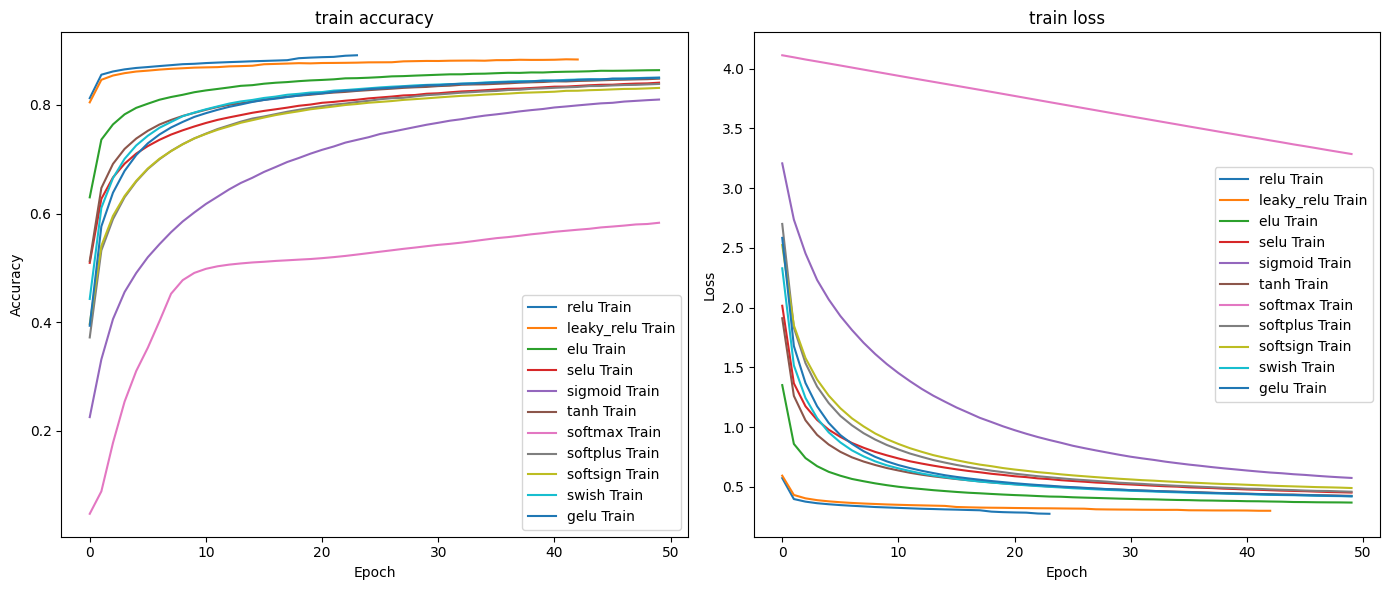

In [ ]:
plt.figure(figsize=(14, 6))

for i in range(len(activation_functions)):
    plt.subplot(1, 2, 1)
    plt.plot(history[i].history['accuracy'], label=f'{activation_functions[i]} Train')
    plt.title('train accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')

    plt.subplot(1, 2, 2)
    plt.plot(history[i].history['loss'], label=f'{activation_functions[i]} Train')
    plt.title('train loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='best')

plt.tight_layout()
plt.show()

In [ ]:
display(results_df)

,Activation Function,Loss,Accuracy,Training Time
0,relu,0.309638,0.883100,644.174936
1,leaky_relu,0.309489,0.881630,1165.668055
2,elu,0.341694,0.871864,1352.104245
3,selu,0.380972,0.862502,1344.599228
4,sigmoid,0.441481,0.842970,1364.826396
5,tanh,0.369531,0.865958,1330.561476
6,softplus,0.373358,0.862580,1365.157042
7,softsign,0.409218,0.854954,1338.102809
8,swish,0.363997,0.865675,1553.046746
9,gelu,0.363767,0.866027,1719.553261


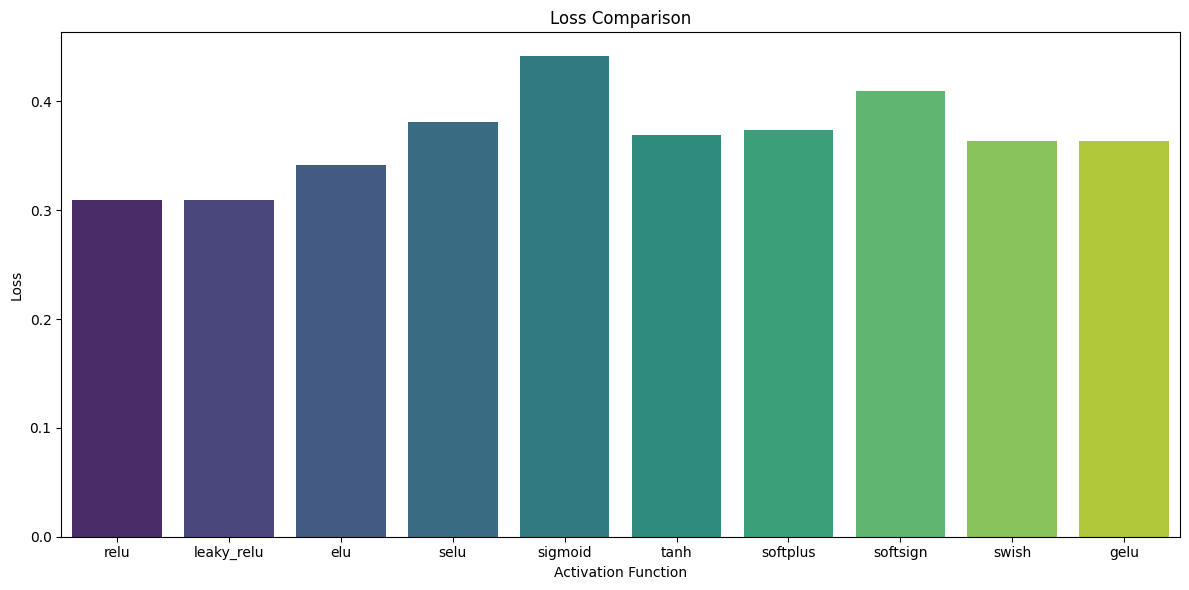

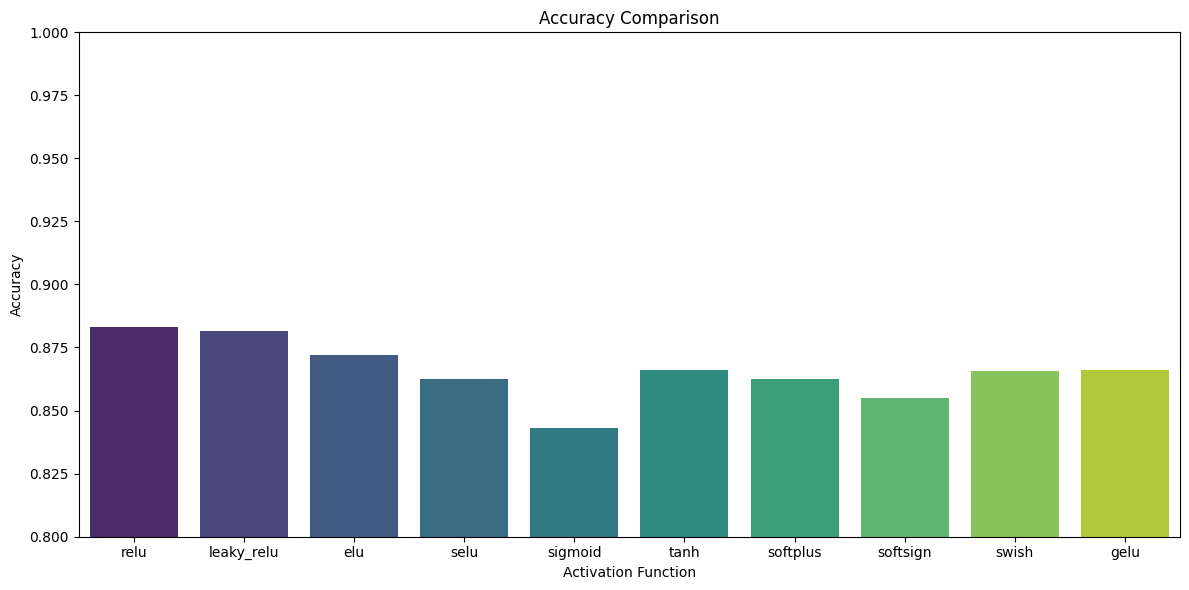

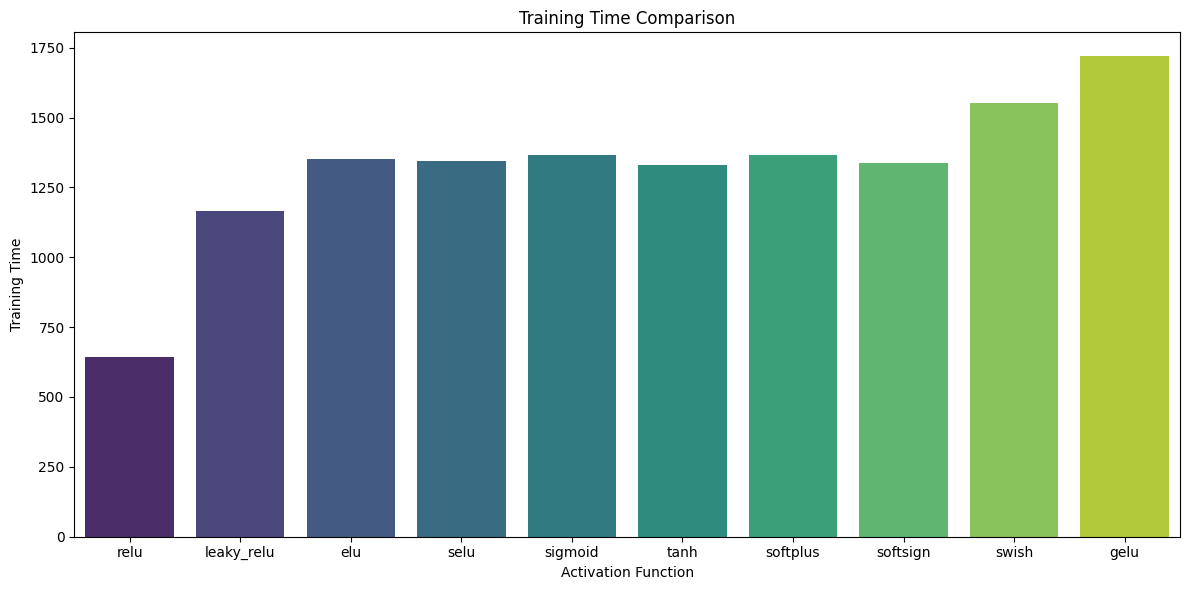

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(x="Activation Function", y="Loss", hue="Activation Function",
            data=results_df, palette="viridis", legend=False)
plt.title(f'{"Loss"} Comparison')
plt.ylabel("Loss")
plt.xlabel('Activation Function')
plt.tight_layout()

plt.figure(figsize=(12, 6))
sns.barplot(x="Activation Function", y="Accuracy", hue="Activation Function",
            data=results_df, palette="viridis", legend=False)
plt.title(f'{"Accuracy"} Comparison')
plt.ylabel("Accuracy")
plt.xlabel('Activation Function')
plt.ylim([0.8, 1])
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(x="Activation Function", y="Training Time", hue="Activation Function",
            data=results_df, palette="viridis", legend=False)
plt.title(f'{"Training Time"} Comparison')
plt.ylabel("Training Time")
plt.xlabel('Activation Function')
plt.tight_layout()
plt.show()

## 2.3. The number of Residual Blocks

In [ ]:
history = []
training_time = []

In [ ]:
callbacks_final = create_callbacks('final')

In [ ]:
best_optimizer = optimizers.legacy.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
best_activation = 'swish'

In [ ]:
EPOCHS = 50
BATCH_SIZE = 500

In [ ]:
def _train_blocks(model, x_train, y_train, validation_data):
    model.compile(optimizer=best_optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    start_time = time.time()
    hist = model.train(x_train, y_train, validation_data=validation_data, epochs=EPOCHS,
                       batch_size=BATCH_SIZE, callbacks=[callbacks_final])
    end_time = time.time()

    history.append(hist)

In [ ]:
start_time = time.time()
_train_blocks(our_model_1res, x_train, y_train_int, (x_valid, y_valid_int))
end_time = time.time()
training_time.append(end_time-start_time)

start_time = time.time()
_train_blocks(our_model_2res, x_train, y_train_int, (x_valid, y_valid_int))
end_time = time.time()
training_time.append(end_time-start_time)


start_time = time.time()
_train_blocks(our_model_3res, x_train, y_train_int, (x_valid, y_valid_int))
end_time = time.time()
training_time.append(end_time-start_time)


start_time = time.time()
_train_blocks(our_model_4res, x_train, y_train_int, (x_valid, y_valid_int))
end_time = time.time()
training_time.append(end_time-start_time)

Epoch 1/50
   1/1257 [..............................] - ETA: 25:52 - loss: 4.8668 - accuracy: 0.0140

2024-06-11 10:18:05.880266: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_15/dropout_73/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1257/1257 [==============================] - ETA: 0s - loss: 0.5495 - accuracy: 0.8195
Epoch 1: val_loss improved from inf to 0.39478, saving model to ./checkpoints/checkpoints_final/weights.1718068677.hdf5
1257/1257 [==============================] - 24s 18ms/step - loss: 0.5495 - accuracy: 0.8195 - val_loss: 0.3948 - val_accuracy: 0.8566 - lr: 0.0010
Epoch 2/50
   5/1257 [..............................] - ETA: 19s - loss: 0.4050 - accuracy: 0.8556

/home/suhohan/anaconda3/envs/ann/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1255/1257 [============================>.] - ETA: 0s - loss: 0.4080 - accuracy: 0.8536
Epoch 2: val_loss improved from 0.39478 to 0.36884, saving model to ./checkpoints/checkpoints_final/weights.1718068677.hdf5
1257/1257 [==============================] - 22s 18ms/step - loss: 0.4081 - accuracy: 0.8536 - val_loss: 0.3688 - val_accuracy: 0.8662 - lr: 0.0010
Epoch 3/50
1255/1257 [============================>.] - ETA: 0s - loss: 0.3854 - accuracy: 0.8598
Epoch 3: val_loss improved from 0.36884 to 0.35777, saving model to ./checkpoints/checkpoints_final/weights.1718068677.hdf5
1257/1257 [==============================] - 22s 18ms/step - loss: 0.3855 - accuracy: 0.8597 - val_loss: 0.3578 - val_accuracy: 0.8676 - lr: 0.0010
Epoch 4/50
1256/1257 [============================>.] - ETA: 0s - loss: 0.3729 - accuracy: 0.8630
Epoch 4: val_loss improved from 0.35777 to 0.34894, saving model to ./checkpoints/checkpoints_final/weights.1718068677.hdf5
1257/1257 [==============================] - 22s 

2024-06-11 10:26:17.438661: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_16/dropout_76/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1257/1257 [==============================] - ETA: 0s - loss: 0.5223 - accuracy: 0.8249
Epoch 1: val_loss did not improve from 0.32297
1257/1257 [==============================] - 30s 23ms/step - loss: 0.5223 - accuracy: 0.8249 - val_loss: 0.3775 - val_accuracy: 0.8617 - lr: 2.5000e-04
Epoch 2/50
1255/1257 [============================>.] - ETA: 0s - loss: 0.4018 - accuracy: 0.8557
Epoch 2: val_loss did not improve from 0.32297
1257/1257 [==============================] - 28s 22ms/step - loss: 0.4019 - accuracy: 0.8557 - val_loss: 0.3562 - val_accuracy: 0.8687 - lr: 2.5000e-04
Epoch 3/50
1255/1257 [============================>.] - ETA: 0s - loss: 0.3798 - accuracy: 0.8615
Epoch 3: val_loss did not improve from 0.32297
1257/1257 [==============================] - 28s 22ms/step - loss: 0.3798 - accuracy: 0.8614 - val_loss: 0.3468 - val_accuracy: 0.8706 - lr: 2.5000e-04
Epoch 4/50
1255/1257 [============================>.] - ETA: 0s - loss: 0.3667 - accuracy: 0.8653
Epoch 4: val_loss did 

2024-06-11 10:45:11.212994: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_17/dropout_80/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1257/1257 [==============================] - ETA: 0s - loss: 1.2611 - accuracy: 0.6622
Epoch 1: val_loss did not improve from 0.31190
1257/1257 [==============================] - 36s 26ms/step - loss: 1.2611 - accuracy: 0.6622 - val_loss: 0.6122 - val_accuracy: 0.8038 - lr: 1.5625e-05
Epoch 2/50
1257/1257 [==============================] - ETA: 0s - loss: 0.7394 - accuracy: 0.7720
Epoch 2: val_loss did not improve from 0.31190
1257/1257 [==============================] - 32s 25ms/step - loss: 0.7394 - accuracy: 0.7720 - val_loss: 0.4988 - val_accuracy: 0.8307 - lr: 1.5625e-05
Epoch 3/50
1257/1257 [==============================] - ETA: 0s - loss: 0.6234 - accuracy: 0.7994
Epoch 3: val_loss did not improve from 0.31190
1257/1257 [==============================] - 31s 25ms/step - loss: 0.6234 - accuracy: 0.7994 - val_loss: 0.4550 - val_accuracy: 0.8426 - lr: 1.5625e-05
Epoch 4/50
1255/1257 [============================>.] - ETA: 0s - loss: 0.5631 - accuracy: 0.8145
Epoch 4: val_loss did 

2024-06-11 11:12:03.049215: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_18/dropout_85/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1257/1257 [==============================] - ETA: 0s - loss: 1.1347 - accuracy: 0.6895
Epoch 1: val_loss did not improve from 0.31190
1257/1257 [==============================] - 41s 30ms/step - loss: 1.1347 - accuracy: 0.6895 - val_loss: 0.5386 - val_accuracy: 0.8202 - lr: 1.5625e-05
Epoch 2/50
1255/1257 [============================>.] - ETA: 0s - loss: 0.6598 - accuracy: 0.7903
Epoch 2: val_loss did not improve from 0.31190
1257/1257 [==============================] - 37s 30ms/step - loss: 0.6598 - accuracy: 0.7903 - val_loss: 0.4598 - val_accuracy: 0.8406 - lr: 1.5625e-05
Epoch 3/50
1256/1257 [============================>.] - ETA: 0s - loss: 0.5676 - accuracy: 0.8125
Epoch 3: val_loss did not improve from 0.31190
1257/1257 [==============================] - 37s 30ms/step - loss: 0.5676 - accuracy: 0.8125 - val_loss: 0.4293 - val_accuracy: 0.8493 - lr: 1.5625e-05
Epoch 4/50
1255/1257 [============================>.] - ETA: 0s - loss: 0.5195 - accuracy: 0.8240
Epoch 4: val_loss did 

In [ ]:
loss_our1res, acc_our1res = our_model_1res.evaluate(x_test, y_test_int)
loss_our2res, acc_our2res = our_model_2res.evaluate(x_test, y_test_int)
loss_our3res, acc_our3res = our_model_3res.evaluate(x_test, y_test_int)
loss_our4res, acc_our4res = our_model_4res.evaluate(x_test, y_test_int)

3636/3636 [==============================] - 17s 5ms/step - loss: 0.3198 - accuracy: 0.8784


In [ ]:
results = {
    "Model": ["Our Model(Residual, 1 units)", "Our Model(Residual, 2 units)", "Our Model(Residual, 3 units)", "Our Model(Residual, 4 units)"],
    "Loss": [loss_our1res, loss_our2res, loss_our3res, loss_our4res],
    "Accuracy": [acc_our1res, acc_our2res, acc_our3res, acc_our4res],
    "Training Time": training_time
}

In [ ]:
results_df = pd.DataFrame(results)
results_df.to_csv(f'{result_path}/result_blocks_{_time}.csv', index=False)

In [ ]:
for i, h in zip(range(1, 5), history):
    history_dict = {key: list(map(float, value)) for key, value in h.history.items()}
    save_history(history_dict, f'history_block_{i}_{_time}.json')

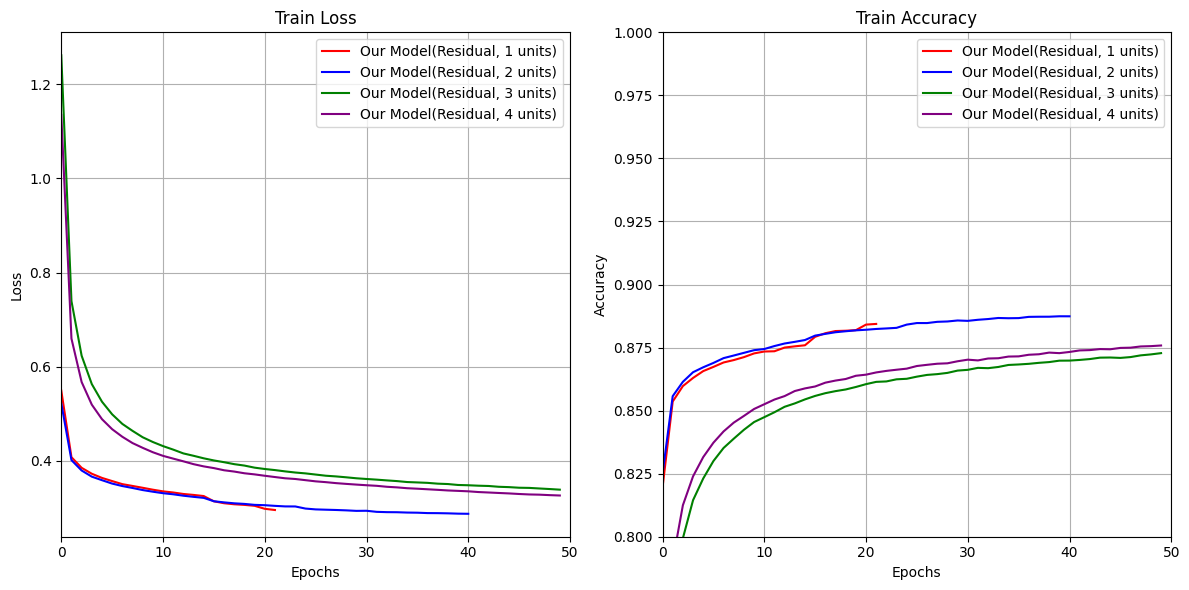

In [ ]:
colors = ["red", "blue", "green", "purple", "gold", "orange"]

plt.figure(figsize=(12, 6))

plt.subplot(121)
for idx, hist in enumerate(history):
    plt.plot(hist.history['loss'], label=f'{results["Model"][idx]}', color=colors[idx])
    plt.title(f'Train Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.xlim([0, EPOCHS])
    plt.grid(True)
    plt.legend()
plt.subplot(122)
for idx, hist in enumerate(history):
    plt.plot(hist.history['accuracy'], label=f'{results["Model"][idx]}', color=colors[idx])
    plt.title(f'Train Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.xlim([0, EPOCHS])
    plt.ylim([0.8, 1])
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.savefig(f"{result_path}/result_blocks_{_time}.png")
plt.show()

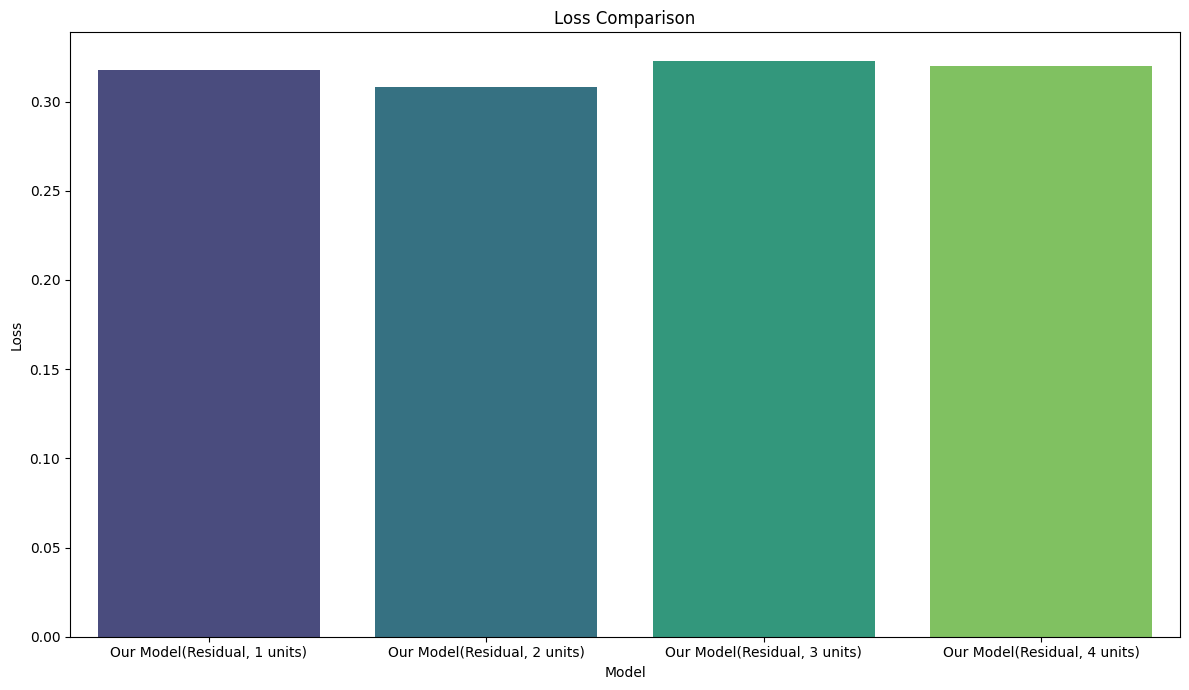

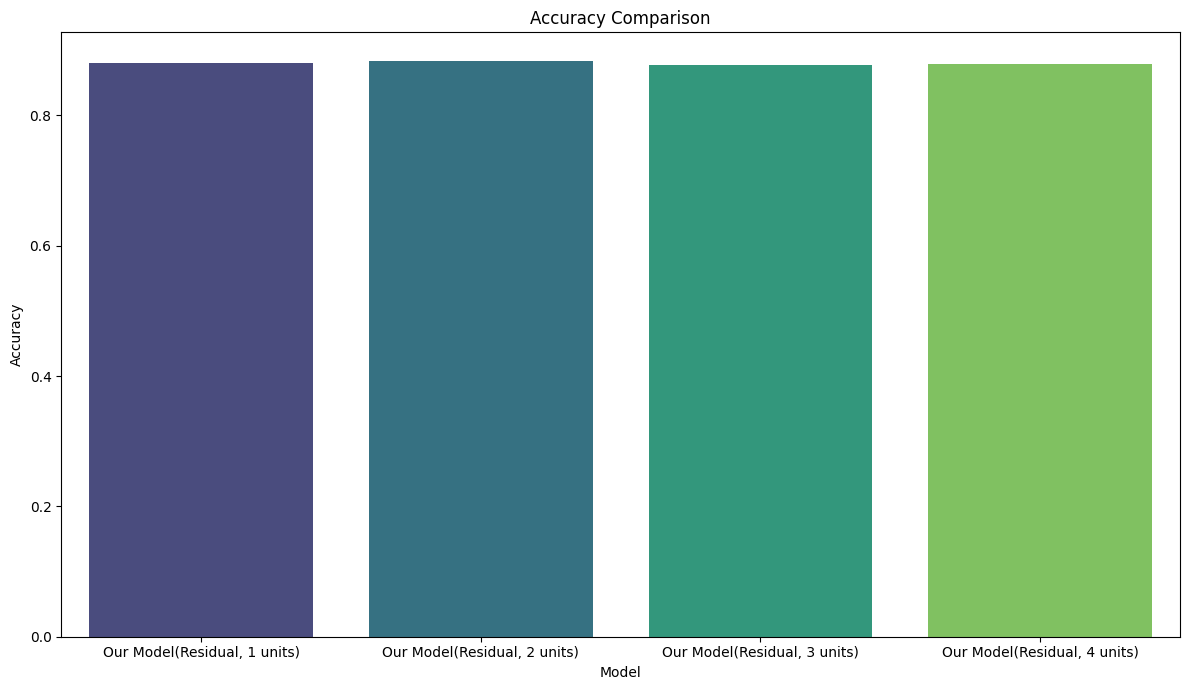

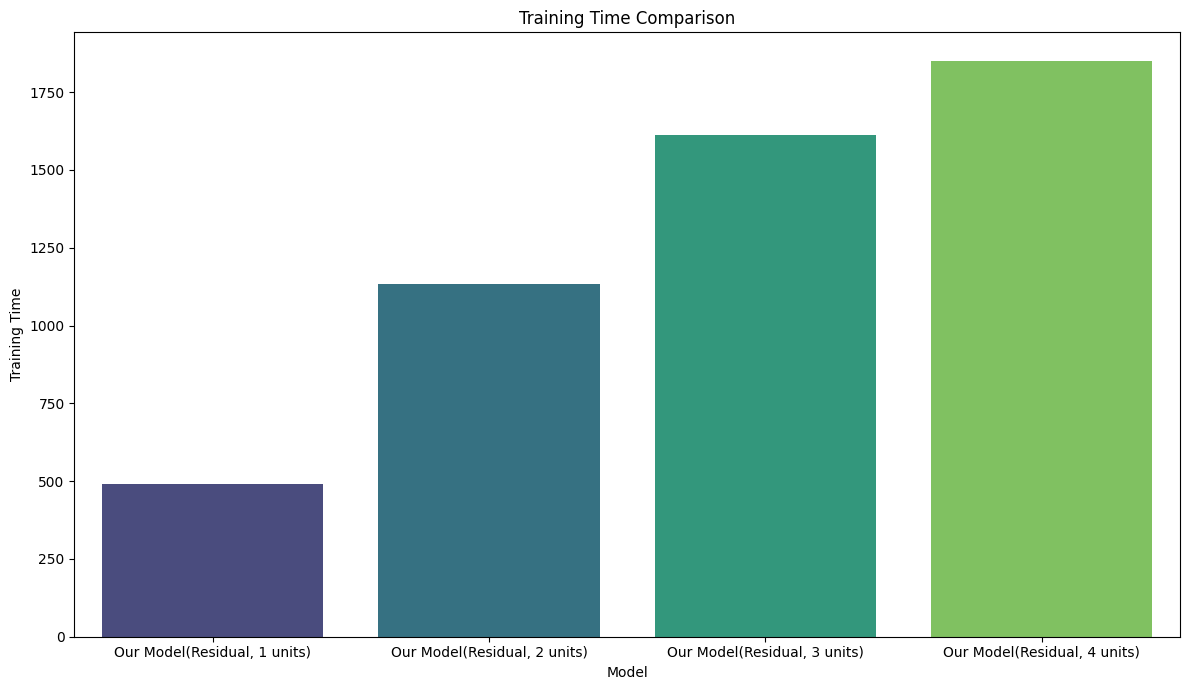

In [ ]:
metrics = ["Loss", "Accuracy", "Training Time"]
for metric in metrics:
    plt.figure(figsize=(12, 7))
    sns.barplot(x="Model", y=metric, hue="Model", data=results_df, palette="viridis", legend=False)
    plt.title(f'{metric} Comparison')
    plt.ylabel(metric)
    plt.xlabel('Model')
    plt.tight_layout()
    plt.savefig(f'{result_path}/{metric.lower().replace(" ", "_")}_comparison_blocks_{_time}.png')
    plt.show()

## 2.4. Learning Rate

In [ ]:
history = []
training_time = []

In [ ]:
callbacks_final = create_callbacks('lr')

In [ ]:
best_optimizer_1 = optimizers.legacy.Nadam(learning_rate=0.01, beta_1=0.9, beta_2=0.999)
best_optimizer_2 = optimizers.legacy.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
best_optimizer_3 = optimizers.legacy.Nadam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999)
best_optimizer_4 = optimizers.legacy.Nadam(learning_rate=0.00001, beta_1=0.9, beta_2=0.999)
best_optimizer_5 = optimizers.legacy.Nadam(learning_rate=0.000001, beta_1=0.9, beta_2=0.999)
best_activation = 'swish'

In [ ]:
our_model_1lr = ResModel(num_residual_units=3, activation=best_activation)
our_model_2lr = ResModel(num_residual_units=3, activation=best_activation)
our_model_3lr = ResModel(num_residual_units=3, activation=best_activation)
our_model_4lr = ResModel(num_residual_units=3, activation=best_activation)
our_model_5lr = ResModel(num_residual_units=3, activation=best_activation)

In [ ]:
our_model_1lr.compile(optimizer=best_optimizer_1, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
our_model_2lr.compile(optimizer=best_optimizer_2, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
our_model_3lr.compile(optimizer=best_optimizer_3, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
our_model_4lr.compile(optimizer=best_optimizer_4, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
our_model_5lr.compile(optimizer=best_optimizer_5, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
EPOCHS = 50
BATCH_SIZE = 500

In [ ]:
results = {'Learning Rate': ['1e-2', '1e-3', '1e-4', '1e-5', '1e-6'], 'Loss': [], 'Accuracy': [], 'Training Time': []}

In [ ]:
def _train_lr(model, optimizer, x_train, y_train, validation_data):
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    start_time = time.time()
    hist = model.train(x_train, y_train, validation_data=validation_data, epochs=EPOCHS,
                       batch_size=BATCH_SIZE, callbacks=[callbacks_final])
    end_time = time.time()

    history.append(hist)

    loss, accuracy = model.evaluate(x_test, y_test_int)
    results['Loss'].append(loss)
    results['Accuracy'].append(accuracy)
    results['Training Time'].append(end_time - start_time)

In [ ]:
start_time = time.time()
_train_lr(our_model_1lr, best_optimizer_1, x_train, y_train_int, (x_valid, y_valid_int))
end_time = time.time()
training_time.append(end_time-start_time)
callbacks_final = create_callbacks('lr_1')

start_time = time.time()
_train_lr(our_model_2lr, best_optimizer_2, x_train, y_train_int, (x_valid, y_valid_int))
end_time = time.time()
training_time.append(end_time-start_time)
callbacks_final = create_callbacks('lr_2')


start_time = time.time()
_train_lr(our_model_3lr, best_optimizer_3, x_train, y_train_int, (x_valid, y_valid_int))
end_time = time.time()
training_time.append(end_time-start_time)
callbacks_final = create_callbacks('lr_3')

start_time = time.time()
_train_lr(our_model_4lr, best_optimizer_4, x_train, y_train_int, (x_valid, y_valid_int))
end_time = time.time()
training_time.append(end_time-start_time)
callbacks_final = create_callbacks('lr_4')

start_time = time.time()
_train_lr(our_model_5lr, best_optimizer_5, x_train, y_train_int, (x_valid, y_valid_int))
end_time = time.time()
training_time.append(end_time-start_time)
callbacks_final = create_callbacks('lr_5')

Epoch 1/50


2024-06-11 11:50:35.577940: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_19/dropout_91/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1257/1257 [==============================] - ETA: 0s - loss: 0.5195 - accuracy: 0.8224
Epoch 1: val_loss improved from inf to 0.42483, saving model to ./checkpoints/checkpoints_lr/weights.1718074226.hdf5
1257/1257 [==============================] - 34s 26ms/step - loss: 0.5195 - accuracy: 0.8224 - val_loss: 0.4248 - val_accuracy: 0.8446 - lr: 0.0100
Epoch 2/50
   4/1257 [..............................] - ETA: 29s - loss: 0.4073 - accuracy: 0.8545

/home/suhohan/anaconda3/envs/ann/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1255/1257 [============================>.] - ETA: 0s - loss: 0.3926 - accuracy: 0.8571
Epoch 2: val_loss improved from 0.42483 to 0.39675, saving model to ./checkpoints/checkpoints_lr/weights.1718074226.hdf5
1257/1257 [==============================] - 32s 25ms/step - loss: 0.3926 - accuracy: 0.8571 - val_loss: 0.3967 - val_accuracy: 0.8595 - lr: 0.0100
Epoch 3/50
1256/1257 [============================>.] - ETA: 0s - loss: 0.3714 - accuracy: 0.8634
Epoch 3: val_loss improved from 0.39675 to 0.39235, saving model to ./checkpoints/checkpoints_lr/weights.1718074226.hdf5
1257/1257 [==============================] - 33s 26ms/step - loss: 0.3714 - accuracy: 0.8633 - val_loss: 0.3924 - val_accuracy: 0.8517 - lr: 0.0100
Epoch 4/50
1257/1257 [==============================] - ETA: 0s - loss: 0.3596 - accuracy: 0.8670
Epoch 4: val_loss improved from 0.39235 to 0.35397, saving model to ./checkpoints/checkpoints_lr/weights.1718074226.hdf5
1257/1257 [==============================] - 32s 26ms/step

2024-06-11 12:01:40.155951: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_20/dropout_96/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1256/1257 [============================>.] - ETA: 0s - loss: 0.5214 - accuracy: 0.8245
Epoch 1: val_loss improved from inf to 0.39757, saving model to ./checkpoints/checkpoints_lr_1/weights.1718074891.hdf5
1257/1257 [==============================] - 35s 26ms/step - loss: 0.5214 - accuracy: 0.8245 - val_loss: 0.3976 - val_accuracy: 0.8560 - lr: 0.0010
Epoch 2/50
1256/1257 [============================>.] - ETA: 0s - loss: 0.3861 - accuracy: 0.8590
Epoch 2: val_loss improved from 0.39757 to 0.36686, saving model to ./checkpoints/checkpoints_lr_1/weights.1718074891.hdf5
1257/1257 [==============================] - 33s 26ms/step - loss: 0.3861 - accuracy: 0.8590 - val_loss: 0.3669 - val_accuracy: 0.8659 - lr: 0.0010
Epoch 3/50
1255/1257 [============================>.] - ETA: 0s - loss: 0.3664 - accuracy: 0.8650
Epoch 3: val_loss improved from 0.36686 to 0.35452, saving model to ./checkpoints/checkpoints_lr_1/weights.1718074891.hdf5
1257/1257 [==============================] - 33s 26ms/st

2024-06-11 12:14:33.544115: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_21/dropout_101/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1256/1257 [============================>.] - ETA: 0s - loss: 0.9137 - accuracy: 0.7377
Epoch 1: val_loss improved from inf to 0.44080, saving model to ./checkpoints/checkpoints_lr_2/weights.1718075665.hdf5
1257/1257 [==============================] - 34s 25ms/step - loss: 0.9137 - accuracy: 0.7377 - val_loss: 0.4408 - val_accuracy: 0.8445 - lr: 1.0000e-04
Epoch 2/50
1255/1257 [============================>.] - ETA: 0s - loss: 0.4812 - accuracy: 0.8341
Epoch 2: val_loss improved from 0.44080 to 0.39160, saving model to ./checkpoints/checkpoints_lr_2/weights.1718075665.hdf5
1257/1257 [==============================] - 32s 25ms/step - loss: 0.4812 - accuracy: 0.8341 - val_loss: 0.3916 - val_accuracy: 0.8586 - lr: 1.0000e-04
Epoch 3/50
1257/1257 [==============================] - ETA: 0s - loss: 0.4277 - accuracy: 0.8482
Epoch 3: val_loss improved from 0.39160 to 0.37663, saving model to ./checkpoints/checkpoints_lr_2/weights.1718075665.hdf5
1257/1257 [==============================] - 32s

2024-06-11 12:37:52.520242: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_22/dropout_106/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1257/1257 [==============================] - ETA: 0s - loss: 2.4099 - accuracy: 0.4289
Epoch 1: val_loss improved from inf to 1.14219, saving model to ./checkpoints/checkpoints_lr_3/weights.1718077062.hdf5
1257/1257 [==============================] - 37s 26ms/step - loss: 2.4099 - accuracy: 0.4289 - val_loss: 1.1422 - val_accuracy: 0.6856 - lr: 1.0000e-05
Epoch 2/50
1256/1257 [============================>.] - ETA: 0s - loss: 1.2355 - accuracy: 0.6638
Epoch 2: val_loss improved from 1.14219 to 0.75872, saving model to ./checkpoints/checkpoints_lr_3/weights.1718077062.hdf5
1257/1257 [==============================] - 32s 26ms/step - loss: 1.2355 - accuracy: 0.6638 - val_loss: 0.7587 - val_accuracy: 0.7682 - lr: 1.0000e-05
Epoch 3/50
1256/1257 [============================>.] - ETA: 0s - loss: 0.9165 - accuracy: 0.7318
Epoch 3: val_loss improved from 0.75872 to 0.60656, saving model to ./checkpoints/checkpoints_lr_3/weights.1718077062.hdf5
1257/1257 [==============================] - 32s

2024-06-11 13:05:06.239281: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_23/dropout_111/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1255/1257 [============================>.] - ETA: 0s - loss: 4.2288 - accuracy: 0.0755
Epoch 1: val_loss improved from inf to 3.16257, saving model to ./checkpoints/checkpoints_lr_4/weights.1718078697.hdf5
1257/1257 [==============================] - 36s 27ms/step - loss: 4.2282 - accuracy: 0.0756 - val_loss: 3.1626 - val_accuracy: 0.3273 - lr: 1.0000e-06
Epoch 2/50
1256/1257 [============================>.] - ETA: 0s - loss: 3.2660 - accuracy: 0.2384
Epoch 2: val_loss improved from 3.16257 to 2.46137, saving model to ./checkpoints/checkpoints_lr_4/weights.1718078697.hdf5
1257/1257 [==============================] - 33s 26ms/step - loss: 3.2659 - accuracy: 0.2384 - val_loss: 2.4614 - val_accuracy: 0.4782 - lr: 1.0000e-06
Epoch 3/50
1256/1257 [============================>.] - ETA: 0s - loss: 2.6816 - accuracy: 0.3726
Epoch 3: val_loss improved from 2.46137 to 1.98800, saving model to ./checkpoints/checkpoints_lr_4/weights.1718078697.hdf5
1257/1257 [==============================] - 33s

In [ ]:
results_df = pd.DataFrame(results)
results_df.to_csv(f'{result_path}/result_lr_{_time}.csv', index=False)

In [ ]:
for i, h in zip(range(1, 4), history):
    history_dict = {key: list(map(float, value)) for key, value in h.history.items()}
    save_history(history_dict, f'history_lr_{i}_{_time}.json')

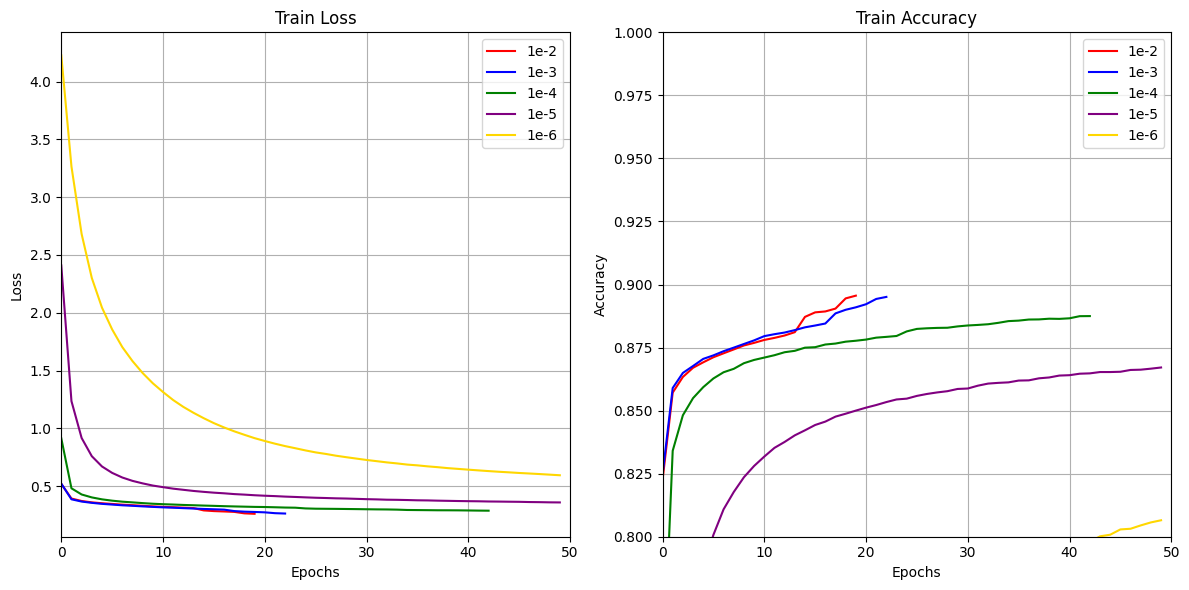

In [ ]:
colors = ["red", "blue", "green", "purple", "gold", "orange"]

plt.figure(figsize=(12, 6))

plt.subplot(121)
for idx, hist in enumerate(history):
    plt.plot(hist.history['loss'], label=f'{results["Learning Rate"][idx]}', color=colors[idx])
    plt.title(f'Train Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.xlim([0, EPOCHS])
    plt.grid(True)
    plt.legend()
plt.subplot(122)
for idx, hist in enumerate(history):
    plt.plot(hist.history['accuracy'], label=f'{results["Learning Rate"][idx]}', color=colors[idx])
    plt.title(f'Train Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.xlim([0, EPOCHS])
    plt.ylim([0.8, 1])
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.savefig(f"{result_path}/result_lr_{_time}.png")
plt.show()

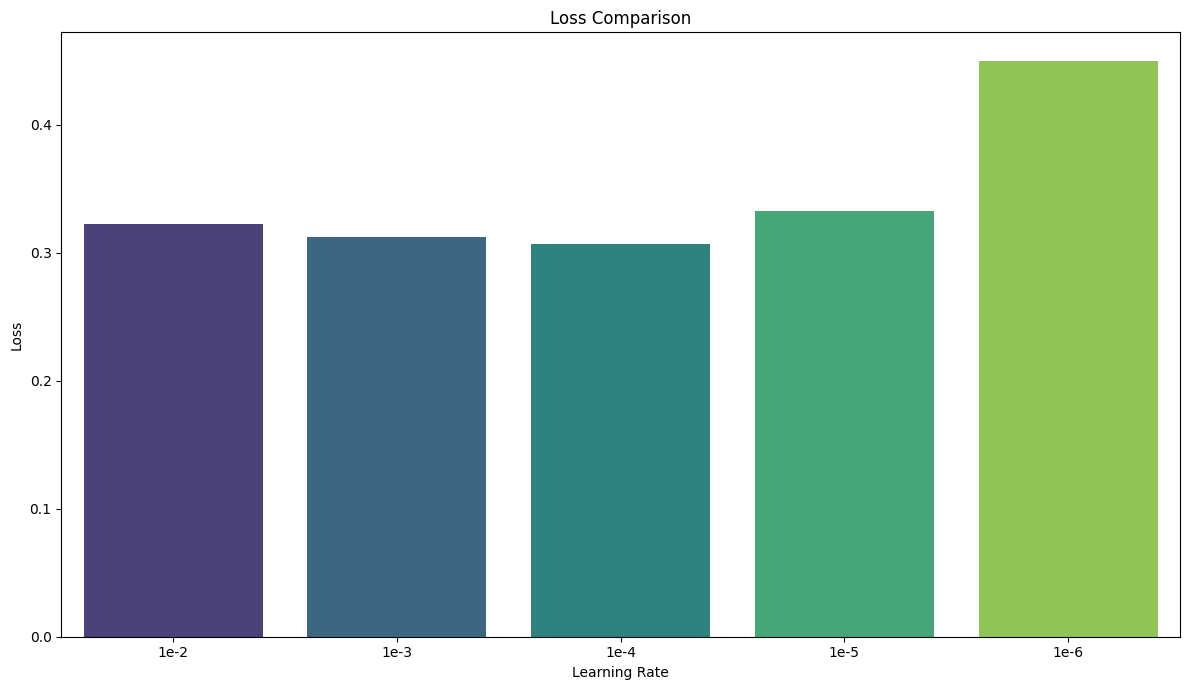

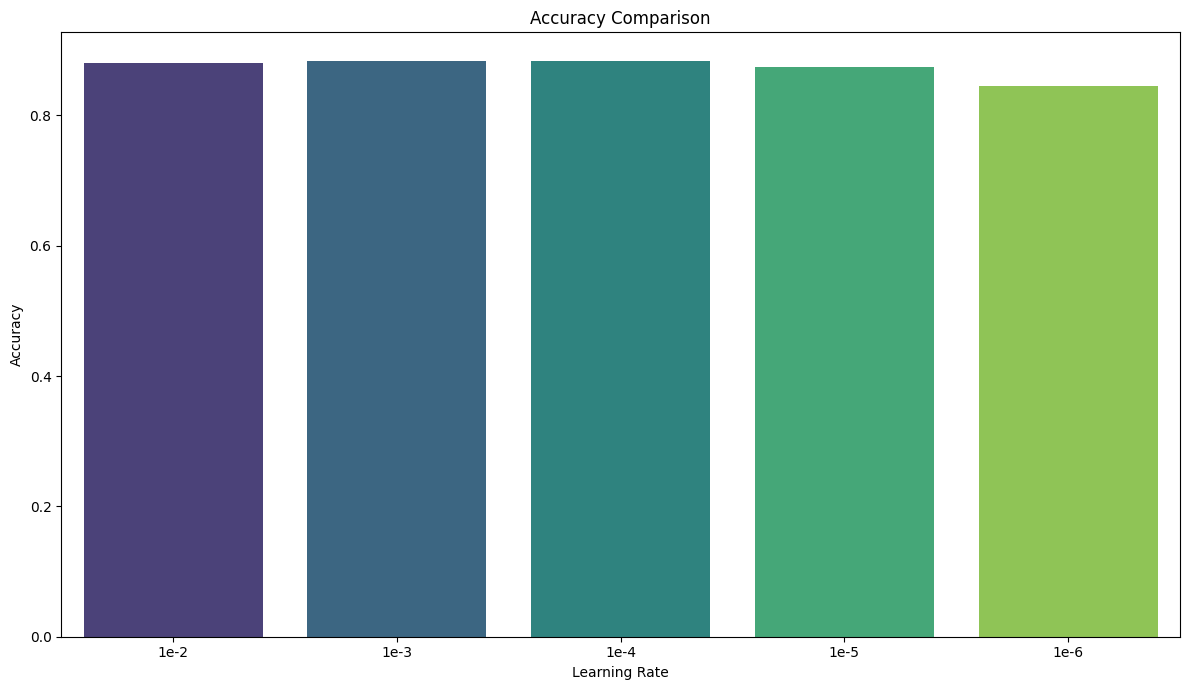

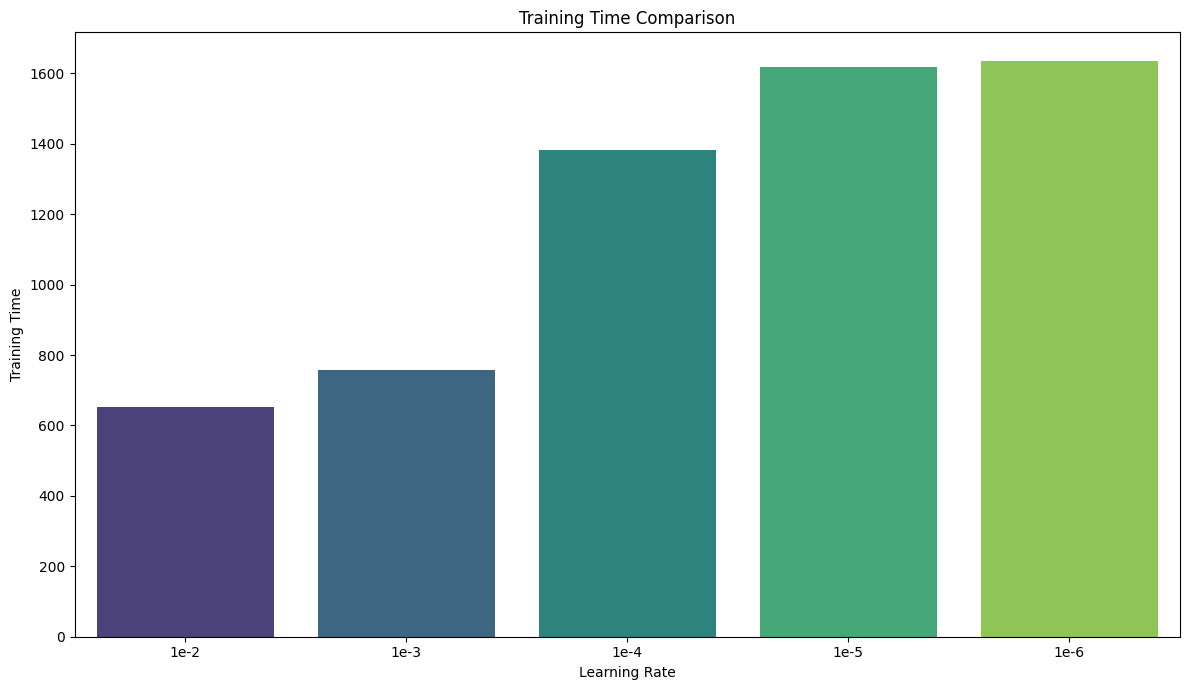

In [ ]:
metrics = ["Loss", "Accuracy", "Training Time"]
for metric in metrics:
    plt.figure(figsize=(12, 7))
    sns.barplot(x="Learning Rate", y=metric, hue="Learning Rate", data=results_df, palette="viridis", legend=False)
    plt.title(f'{metric} Comparison')
    plt.ylabel(metric)
    plt.xlabel('Learning Rate')
    plt.tight_layout()
    plt.savefig(f'{result_path}/{metric.lower().replace(" ", "_")}_comparison_lr_{_time}.png')
    plt.show()

### 2.4.1. Detailed learning rate

In [ ]:
history = []
training_time = []

In [ ]:
callbacks_final = create_callbacks('lr')

In [ ]:
best_activation = 'swish'

In [ ]:
EPOCHS = 50
BATCH_SIZE = 500

In [ ]:
results = {'Learning Rate': ['1e−3', '9e−4', '8e−4', '7e−4', '6e−4',
                             '5e−4', '4e−4', '3e−4', '2e−4', '1e−4'], 'Loss': [], 'Accuracy': [], 'Training Time': []}

In [ ]:
def _train_lr(learning_rate, x_train, y_train, validation_data):
    model = ResModel(num_residual_units=3, activation=best_activation)
    _optimizer = optimizers.legacy.Nadam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999)
    model.compile(optimizer=_optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    start_time = time.time()
    hist = model.train(x_train, y_train, validation_data=validation_data, epochs=EPOCHS,
                       batch_size=BATCH_SIZE, callbacks=[callbacks_final])
    end_time = time.time()

    history.append(hist)

    loss, accuracy = model.evaluate(x_test, y_test_int)
    results['Loss'].append(loss)
    results['Accuracy'].append(accuracy)
    results['Training Time'].append(end_time - start_time)

In [ ]:
for i in np.linspace(1e-3, 1e-4, 10):
    start_time = time.time()
    _train_lr(i, x_train, y_train_int, (x_valid, y_valid_int))
    end_time = time.time()
    training_time.append(end_time-start_time)
    callbacks_final = create_callbacks(f'{i}')

Epoch 1/50


2024-06-11 13:32:36.569555: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_24/dropout_116/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1256/1257 [============================>.] - ETA: 0s - loss: 0.5223 - accuracy: 0.8243
Epoch 1: val_loss improved from inf to 0.38925, saving model to ./checkpoints/checkpoints_lr/weights.1718080347.hdf5
1257/1257 [==============================] - 35s 26ms/step - loss: 0.5222 - accuracy: 0.8243 - val_loss: 0.3893 - val_accuracy: 0.8584 - lr: 1.0000e-03
Epoch 2/50
   4/1257 [..............................] - ETA: 28s - loss: 0.3969 - accuracy: 0.8610

/home/suhohan/anaconda3/envs/ann/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1256/1257 [============================>.] - ETA: 0s - loss: 0.3857 - accuracy: 0.8586
Epoch 2: val_loss improved from 0.38925 to 0.36570, saving model to ./checkpoints/checkpoints_lr/weights.1718080347.hdf5
1257/1257 [==============================] - 33s 26ms/step - loss: 0.3857 - accuracy: 0.8586 - val_loss: 0.3657 - val_accuracy: 0.8666 - lr: 1.0000e-03
Epoch 3/50
1256/1257 [============================>.] - ETA: 0s - loss: 0.3658 - accuracy: 0.8646
Epoch 3: val_loss improved from 0.36570 to 0.36152, saving model to ./checkpoints/checkpoints_lr/weights.1718080347.hdf5
1257/1257 [==============================] - 33s 26ms/step - loss: 0.3658 - accuracy: 0.8646 - val_loss: 0.3615 - val_accuracy: 0.8635 - lr: 1.0000e-03
Epoch 4/50
1255/1257 [============================>.] - ETA: 0s - loss: 0.3539 - accuracy: 0.8683
Epoch 4: val_loss improved from 0.36152 to 0.33756, saving model to ./checkpoints/checkpoints_lr/weights.1718080347.hdf5
1257/1257 [==============================] - 33s 2

2024-06-11 13:44:11.485716: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_25/dropout_121/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1255/1257 [============================>.] - ETA: 0s - loss: 0.5296 - accuracy: 0.8223
Epoch 1: val_loss improved from inf to 0.38392, saving model to ./checkpoints/checkpoints_0.001/weights.1718081042.hdf5
1257/1257 [==============================] - 33s 25ms/step - loss: 0.5295 - accuracy: 0.8223 - val_loss: 0.3839 - val_accuracy: 0.8595 - lr: 9.0000e-04
Epoch 2/50
1256/1257 [============================>.] - ETA: 0s - loss: 0.3876 - accuracy: 0.8584
Epoch 2: val_loss improved from 0.38392 to 0.36100, saving model to ./checkpoints/checkpoints_0.001/weights.1718081042.hdf5
1257/1257 [==============================] - 31s 25ms/step - loss: 0.3876 - accuracy: 0.8584 - val_loss: 0.3610 - val_accuracy: 0.8674 - lr: 9.0000e-04
Epoch 3/50
1256/1257 [============================>.] - ETA: 0s - loss: 0.3667 - accuracy: 0.8646
Epoch 3: val_loss did not improve from 0.36100
1257/1257 [==============================] - 32s 25ms/step - loss: 0.3667 - accuracy: 0.8646 - val_loss: 0.3652 - val_accu

2024-06-11 13:56:16.792391: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_26/dropout_126/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1255/1257 [============================>.] - ETA: 0s - loss: 0.5357 - accuracy: 0.8210
Epoch 1: val_loss improved from inf to 0.39723, saving model to ./checkpoints/checkpoints_0.0009/weights.1718081767.hdf5
1257/1257 [==============================] - 35s 26ms/step - loss: 0.5356 - accuracy: 0.8210 - val_loss: 0.3972 - val_accuracy: 0.8535 - lr: 8.0000e-04
Epoch 2/50
1255/1257 [============================>.] - ETA: 0s - loss: 0.3878 - accuracy: 0.8584
Epoch 2: val_loss improved from 0.39723 to 0.36766, saving model to ./checkpoints/checkpoints_0.0009/weights.1718081767.hdf5
1257/1257 [==============================] - 32s 25ms/step - loss: 0.3878 - accuracy: 0.8584 - val_loss: 0.3677 - val_accuracy: 0.8654 - lr: 8.0000e-04
Epoch 3/50
1255/1257 [============================>.] - ETA: 0s - loss: 0.3674 - accuracy: 0.8643
Epoch 3: val_loss improved from 0.36766 to 0.35195, saving model to ./checkpoints/checkpoints_0.0009/weights.1718081767.hdf5
1257/1257 [==============================]

2024-06-11 14:08:18.282206: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_27/dropout_131/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1257/1257 [==============================] - ETA: 0s - loss: 0.5448 - accuracy: 0.8194
Epoch 1: val_loss improved from inf to 0.39725, saving model to ./checkpoints/checkpoints_0.0008/weights.1718082489.hdf5
1257/1257 [==============================] - 33s 24ms/step - loss: 0.5448 - accuracy: 0.8194 - val_loss: 0.3972 - val_accuracy: 0.8539 - lr: 7.0000e-04
Epoch 2/50
1255/1257 [============================>.] - ETA: 0s - loss: 0.3900 - accuracy: 0.8578
Epoch 2: val_loss improved from 0.39725 to 0.36693, saving model to ./checkpoints/checkpoints_0.0008/weights.1718082489.hdf5
1257/1257 [==============================] - 30s 24ms/step - loss: 0.3900 - accuracy: 0.8578 - val_loss: 0.3669 - val_accuracy: 0.8662 - lr: 7.0000e-04
Epoch 3/50
1256/1257 [============================>.] - ETA: 0s - loss: 0.3684 - accuracy: 0.8640
Epoch 3: val_loss did not improve from 0.36693
1257/1257 [==============================] - 30s 24ms/step - loss: 0.3684 - accuracy: 0.8640 - val_loss: 0.3676 - val_ac

2024-06-11 14:20:10.899290: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_28/dropout_136/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1257/1257 [==============================] - ETA: 0s - loss: 0.5618 - accuracy: 0.8152
Epoch 1: val_loss improved from inf to 0.39147, saving model to ./checkpoints/checkpoints_0.0007000000000000001/weights.1718083200.hdf5
1257/1257 [==============================] - 38s 26ms/step - loss: 0.5618 - accuracy: 0.8152 - val_loss: 0.3915 - val_accuracy: 0.8582 - lr: 6.0000e-04
Epoch 2/50
1256/1257 [============================>.] - ETA: 0s - loss: 0.3924 - accuracy: 0.8575
Epoch 2: val_loss improved from 0.39147 to 0.36866, saving model to ./checkpoints/checkpoints_0.0007000000000000001/weights.1718083200.hdf5
1257/1257 [==============================] - 33s 26ms/step - loss: 0.3924 - accuracy: 0.8575 - val_loss: 0.3687 - val_accuracy: 0.8641 - lr: 6.0000e-04
Epoch 3/50
1255/1257 [============================>.] - ETA: 0s - loss: 0.3698 - accuracy: 0.8637
Epoch 3: val_loss did not improve from 0.36866
1257/1257 [==============================] - 33s 26ms/step - loss: 0.3699 - accuracy: 0.86

2024-06-11 14:32:16.852474: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_29/dropout_141/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1256/1257 [============================>.] - ETA: 0s - loss: 0.5818 - accuracy: 0.8109
Epoch 1: val_loss improved from inf to 0.40929, saving model to ./checkpoints/checkpoints_0.0006000000000000001/weights.1718083928.hdf5
1257/1257 [==============================] - 35s 26ms/step - loss: 0.5818 - accuracy: 0.8109 - val_loss: 0.4093 - val_accuracy: 0.8512 - lr: 5.0000e-04
Epoch 2/50
1257/1257 [==============================] - ETA: 0s - loss: 0.3968 - accuracy: 0.8562
Epoch 2: val_loss improved from 0.40929 to 0.36489, saving model to ./checkpoints/checkpoints_0.0006000000000000001/weights.1718083928.hdf5
1257/1257 [==============================] - 32s 25ms/step - loss: 0.3968 - accuracy: 0.8562 - val_loss: 0.3649 - val_accuracy: 0.8656 - lr: 5.0000e-04
Epoch 3/50
1256/1257 [============================>.] - ETA: 0s - loss: 0.3719 - accuracy: 0.8631
Epoch 3: val_loss improved from 0.36489 to 0.35973, saving model to ./checkpoints/checkpoints_0.0006000000000000001/weights.1718083928.hd

2024-06-11 14:46:43.367382: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_30/dropout_146/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1256/1257 [============================>.] - ETA: 0s - loss: 0.6061 - accuracy: 0.8059
Epoch 1: val_loss improved from inf to 0.38795, saving model to ./checkpoints/checkpoints_0.0005/weights.1718084795.hdf5
1257/1257 [==============================] - 34s 26ms/step - loss: 0.6060 - accuracy: 0.8059 - val_loss: 0.3879 - val_accuracy: 0.8587 - lr: 4.0000e-04
Epoch 2/50
1255/1257 [============================>.] - ETA: 0s - loss: 0.4020 - accuracy: 0.8549
Epoch 2: val_loss improved from 0.38795 to 0.37015, saving model to ./checkpoints/checkpoints_0.0005/weights.1718084795.hdf5
1257/1257 [==============================] - 33s 26ms/step - loss: 0.4020 - accuracy: 0.8549 - val_loss: 0.3702 - val_accuracy: 0.8645 - lr: 4.0000e-04
Epoch 3/50
1257/1257 [==============================] - ETA: 0s - loss: 0.3752 - accuracy: 0.8623
Epoch 3: val_loss improved from 0.37015 to 0.35387, saving model to ./checkpoints/checkpoints_0.0005/weights.1718084795.hdf5
1257/1257 [==============================]

2024-06-11 15:02:42.651495: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_31/dropout_151/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1256/1257 [============================>.] - ETA: 0s - loss: 0.6483 - accuracy: 0.7957
Epoch 1: val_loss improved from inf to 0.39352, saving model to ./checkpoints/checkpoints_0.0004000000000000001/weights.1718085754.hdf5
1257/1257 [==============================] - 35s 26ms/step - loss: 0.6482 - accuracy: 0.7957 - val_loss: 0.3935 - val_accuracy: 0.8567 - lr: 3.0000e-04
Epoch 2/50
1257/1257 [==============================] - ETA: 0s - loss: 0.4105 - accuracy: 0.8528
Epoch 2: val_loss improved from 0.39352 to 0.38317, saving model to ./checkpoints/checkpoints_0.0004000000000000001/weights.1718085754.hdf5
1257/1257 [==============================] - 32s 26ms/step - loss: 0.4105 - accuracy: 0.8528 - val_loss: 0.3832 - val_accuracy: 0.8605 - lr: 3.0000e-04
Epoch 3/50
1256/1257 [============================>.] - ETA: 0s - loss: 0.3806 - accuracy: 0.8608
Epoch 3: val_loss improved from 0.38317 to 0.35610, saving model to ./checkpoints/checkpoints_0.0004000000000000001/weights.1718085754.hd

2024-06-11 15:16:46.562714: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_32/dropout_156/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1255/1257 [============================>.] - ETA: 0s - loss: 0.7263 - accuracy: 0.7787
Epoch 1: val_loss improved from inf to 0.40566, saving model to ./checkpoints/checkpoints_0.00030000000000000014/weights.1718086598.hdf5
1257/1257 [==============================] - 33s 25ms/step - loss: 0.7260 - accuracy: 0.7787 - val_loss: 0.4057 - val_accuracy: 0.8526 - lr: 2.0000e-04
Epoch 2/50
1257/1257 [==============================] - ETA: 0s - loss: 0.4301 - accuracy: 0.8476
Epoch 2: val_loss improved from 0.40566 to 0.37542, saving model to ./checkpoints/checkpoints_0.00030000000000000014/weights.1718086598.hdf5
1257/1257 [==============================] - 32s 26ms/step - loss: 0.4301 - accuracy: 0.8476 - val_loss: 0.3754 - val_accuracy: 0.8628 - lr: 2.0000e-04
Epoch 3/50
1256/1257 [============================>.] - ETA: 0s - loss: 0.3932 - accuracy: 0.8570
Epoch 3: val_loss improved from 0.37542 to 0.36169, saving model to ./checkpoints/checkpoints_0.00030000000000000014/weights.1718086598

2024-06-11 15:34:58.273196: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_33/dropout_161/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1256/1257 [============================>.] - ETA: 0s - loss: 0.9265 - accuracy: 0.7358
Epoch 1: val_loss improved from inf to 0.43239, saving model to ./checkpoints/checkpoints_0.0002000000000000001/weights.1718087690.hdf5
1257/1257 [==============================] - 36s 27ms/step - loss: 0.9264 - accuracy: 0.7358 - val_loss: 0.4324 - val_accuracy: 0.8469 - lr: 1.0000e-04
Epoch 2/50
1256/1257 [============================>.] - ETA: 0s - loss: 0.4845 - accuracy: 0.8331
Epoch 2: val_loss improved from 0.43239 to 0.39442, saving model to ./checkpoints/checkpoints_0.0002000000000000001/weights.1718087690.hdf5
1257/1257 [==============================] - 33s 26ms/step - loss: 0.4845 - accuracy: 0.8331 - val_loss: 0.3944 - val_accuracy: 0.8585 - lr: 1.0000e-04
Epoch 3/50
1256/1257 [============================>.] - ETA: 0s - loss: 0.4294 - accuracy: 0.8476
Epoch 3: val_loss improved from 0.39442 to 0.37001, saving model to ./checkpoints/checkpoints_0.0002000000000000001/weights.1718087690.hd

In [ ]:
results_df = pd.DataFrame(results)
results_df.to_csv(f'{result_path}/result_lr_{_time}.csv', index=False)

In [ ]:
for i, h in zip(['1e−3', '9e−4', '8e−4', '7e−4', '6e−4',
                 '5e−4', '4e−4', '3e−4', '2e−4', '1e−4'], history):
    history_dict = {key: list(map(float, value)) for key, value in h.history.items()}
    save_history(history_dict, f'history_lr_{i}_{_time}.json')

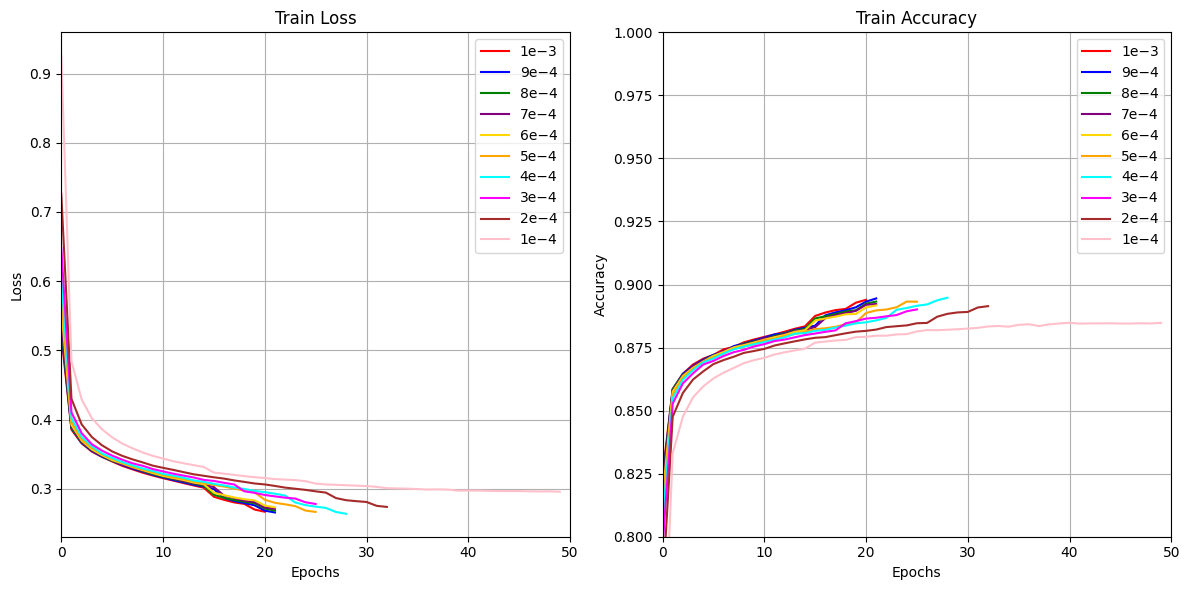

In [ ]:
colors = ["red", "blue", "green", "purple", "gold", "orange", "cyan", "magenta", "brown", "pink"]


plt.figure(figsize=(12, 6))

plt.subplot(121)
for idx, hist in enumerate(history):
    plt.plot(hist.history['loss'], label=f'{results["Learning Rate"][idx]}', color=colors[idx])
    plt.title(f'Train Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.xlim([0, EPOCHS])
    plt.grid(True)
    plt.legend()
plt.subplot(122)
for idx, hist in enumerate(history):
    plt.plot(hist.history['accuracy'], label=f'{results["Learning Rate"][idx]}', color=colors[idx])
    plt.title(f'Train Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.xlim([0, EPOCHS])
    plt.ylim([0.8, 1])
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.savefig(f"{result_path}/result_lr_{_time}.png")
plt.show()

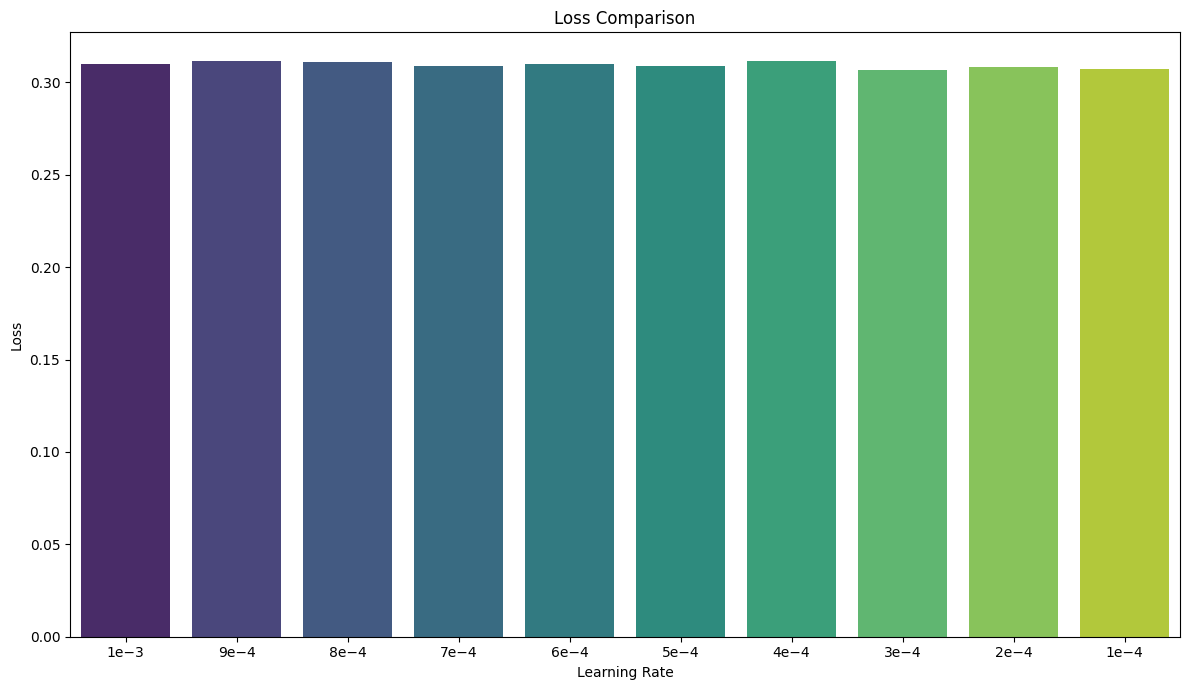

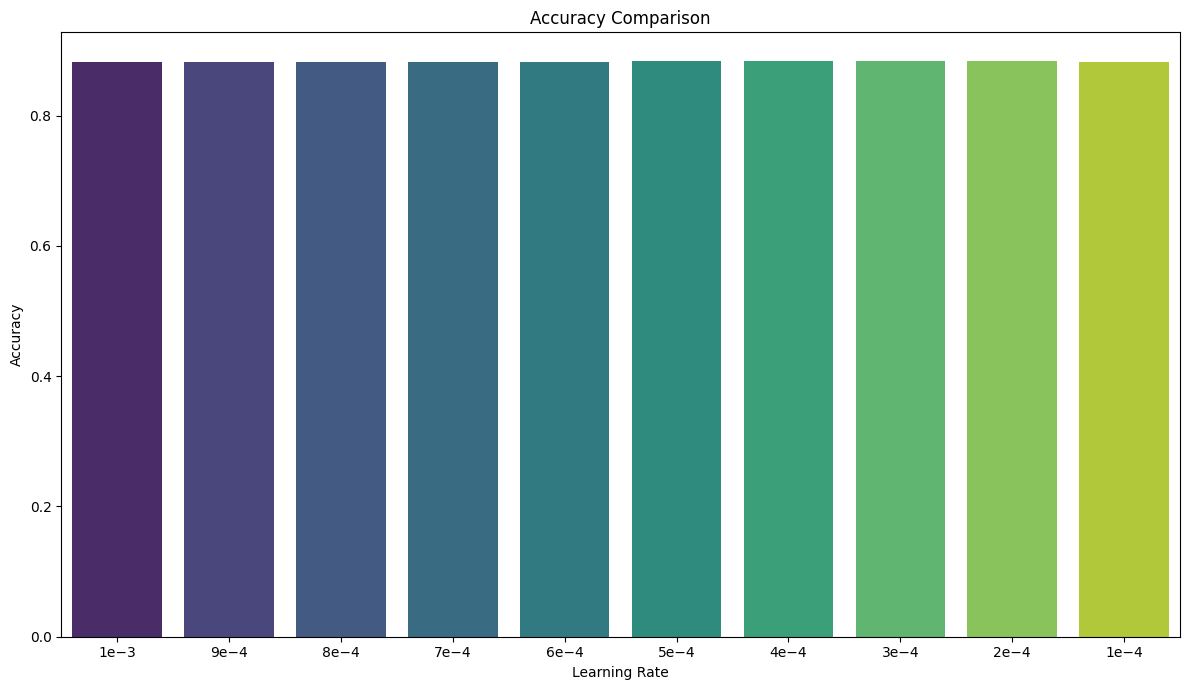

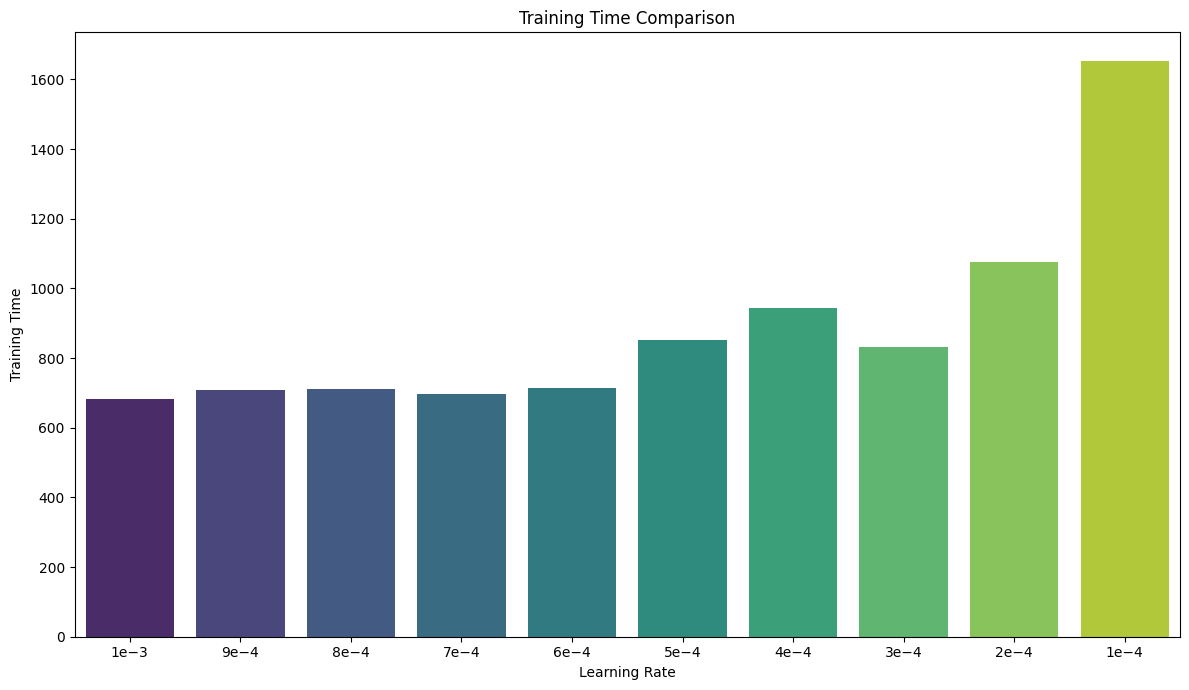

In [ ]:
metrics = ["Loss", "Accuracy", "Training Time"]
for metric in metrics:
    plt.figure(figsize=(12, 7))
    sns.barplot(x="Learning Rate", y=metric, hue="Learning Rate", data=results_df, palette="viridis", legend=False)
    plt.title(f'{metric} Comparison')
    plt.ylabel(metric)
    plt.xlabel('Learning Rate')
    plt.tight_layout()
    plt.savefig(f'{result_path}/{metric.lower().replace(" ", "_")}_comparison_lr_{_time}.png')
    plt.show()

# 3. Final Experiment

In [ ]:
train_file_path = '../../../../mnt/sda/suhohan/emnist/emnist-bymerge-train.csv'
test_file_path = '../../../../mnt/sda/suhohan/emnist/emnist-bymerge-test.csv'

train_data = pd.read_csv(train_file_path)
test_data = pd.read_csv(test_file_path)

num_train_samples = train_data.shape[0]
num_test_samples = test_data.shape[0]

x_train_bymerge = train_data.iloc[:, 1:].to_numpy().reshape((num_train_samples, 28, 28, 1))
x_test_bymerge = test_data.iloc[:, 1:].to_numpy().reshape((num_test_samples, 28, 28, 1))
y_train_bymerge = tf.keras.utils.to_categorical(train_data.iloc[:, 0], 47)
y_test_bymerge = tf.keras.utils.to_categorical(test_data.iloc[:, 0], 47)

y_train_int_bymerge = train_data.iloc[:, 0].to_numpy()
y_test_int_bymerge = test_data.iloc[:, 0].to_numpy()

_, _, y_train_bymerge, y_valid_bymerge = train_test_split(
    x_train_bymerge, y_train_bymerge, test_size=0.1, random_state=42)
x_train_bymerge, x_valid_bymerge, y_train_int_bymerge, y_valid_int_bymerge = train_test_split(
    x_train_bymerge, y_train_int_bymerge, test_size=0.1, random_state=42)

In [ ]:
train_file_path = '../../../../mnt/sda/suhohan/emnist/emnist-balanced-train.csv'
test_file_path = '../../../../mnt/sda/suhohan/emnist/emnist-balanced-test.csv'

train_data = pd.read_csv(train_file_path)
test_data = pd.read_csv(test_file_path)

num_train_samples = train_data.shape[0]
num_test_samples = test_data.shape[0]

x_train_balanced = train_data.iloc[:, 1:].to_numpy().reshape((num_train_samples, 28, 28, 1))
x_test_balanced = test_data.iloc[:, 1:].to_numpy().reshape((num_test_samples, 28, 28, 1))
y_train_balanced = tf.keras.utils.to_categorical(train_data.iloc[:, 0], 47)
y_test_balanced = tf.keras.utils.to_categorical(test_data.iloc[:, 0], 47)

y_train_int_balanced = train_data.iloc[:, 0].to_numpy()
y_test_int_balanced = test_data.iloc[:, 0].to_numpy()

_, _, y_train_balanced, y_valid_balanced = train_test_split(
    x_train_balanced, y_train_balanced, test_size=0.1, random_state=42)
x_train_balanced, x_valid_balanced, y_train_int_balanced, y_valid_int_balanced = train_test_split(
    x_train_balanced, y_train_int_balanced, test_size=0.1, random_state=42)

In [ ]:
history = []
training_time = []

In [ ]:
callbacks_final = create_callbacks('final')

best_activation = 'swish'
best_learning_rate = 2e-4
best_optimizer = optimizers.legacy.Nadam(learning_rate=best_learning_rate, beta_1=0.9, beta_2=0.999)
best_lr = 2e-4

In [ ]:
EPOCHS = 50
BATCH_SIZE = 500

In [ ]:
results = {'Trained Dataset': [], 'Training Time': []}

In [ ]:
model_final_byclass = ResModel(num_classes=62, num_residual_units=3, activation=best_activation)
model_final_bymerge = ResModel(num_classes=47, num_residual_units=3, activation=best_activation)
model_final_balanced = ResModel(num_classes=47, num_residual_units=3, activation=best_activation)

In [ ]:
_optimizer = optimizers.legacy.Nadam(learning_rate=best_lr, beta_1=0.9, beta_2=0.999)
model_final_byclass.compile(optimizer=_optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_final_bymerge.compile(optimizer=_optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_final_balanced.compile(optimizer=_optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
start_time = time.time()
hist = model_final_byclass.train(x_train, y_train_int, validation_data=(x_valid, y_valid_int), epochs=EPOCHS,
                                 batch_size=BATCH_SIZE, callbacks=[callbacks_final_class])
end_time = time.time()

results['Trained Dataset'].append('EMNIST ByClass')
results['Training Time'].append(end_time - start_time)
history.append(hist)

start_time = time.time()
hist = model_final_bymerge.train(x_train_bymerge, y_train_int_bymerge, validation_data=(x_valid_bymerge, y_valid_int_bymerge), epochs=EPOCHS,
                                 batch_size=BATCH_SIZE, callbacks=[callbacks_final_merge])
end_time = time.time()

results['Trained Dataset'].append('EMNIST ByMerge')
results['Training Time'].append(end_time - start_time)
history.append(hist)

start_time = time.time()
hist = model_final_balanced.train(x_train_balanced, y_train_int_balanced, validation_data=(x_valid_balanced, y_valid_int_balanced), epochs=EPOCHS,
                                  batch_size=BATCH_SIZE, callbacks=[callbacks_final_balanced])
end_time = time.time()

Epoch 1/50


2024-06-11 16:34:41.139549: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_37/dropout_181/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1255/1257 [============================>.] - ETA: 0s - loss: 0.7325 - accuracy: 0.7772
Epoch 1: val_loss improved from inf to 0.41569, saving model to ./checkpoints/checkpoints_final_class/weights.1718091265.hdf5
1257/1257 [==============================] - 34s 25ms/step - loss: 0.7322 - accuracy: 0.7773 - val_loss: 0.4157 - val_accuracy: 0.8490 - lr: 2.0000e-04
Epoch 2/50
   4/1257 [..............................] - ETA: 28s - loss: 0.4412 - accuracy: 0.8475

/home/suhohan/anaconda3/envs/ann/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1255/1257 [============================>.] - ETA: 0s - loss: 0.4312 - accuracy: 0.8469
Epoch 2: val_loss improved from 0.41569 to 0.37276, saving model to ./checkpoints/checkpoints_final_class/weights.1718091265.hdf5
1257/1257 [==============================] - 31s 24ms/step - loss: 0.4313 - accuracy: 0.8469 - val_loss: 0.3728 - val_accuracy: 0.8650 - lr: 2.0000e-04
Epoch 3/50
1257/1257 [==============================] - ETA: 0s - loss: 0.3940 - accuracy: 0.8571
Epoch 3: val_loss improved from 0.37276 to 0.36350, saving model to ./checkpoints/checkpoints_final_class/weights.1718091265.hdf5
1257/1257 [==============================] - 31s 24ms/step - loss: 0.3940 - accuracy: 0.8571 - val_loss: 0.3635 - val_accuracy: 0.8658 - lr: 2.0000e-04
Epoch 4/50
1257/1257 [==============================] - ETA: 0s - loss: 0.3757 - accuracy: 0.8623
Epoch 4: val_loss improved from 0.36350 to 0.34857, saving model to ./checkpoints/checkpoints_final_class/weights.1718091265.hdf5
1257/1257 [============

2024-06-11 16:48:12.190323: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_38/dropout_186/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1257/1257 [==============================] - ETA: 0s - loss: 0.5975 - accuracy: 0.8122
Epoch 1: val_loss improved from inf to 0.31524, saving model to ./checkpoints/checkpoints_final_merge/weights.1718091265.hdf5
1257/1257 [==============================] - 33s 25ms/step - loss: 0.5975 - accuracy: 0.8122 - val_loss: 0.3152 - val_accuracy: 0.8862 - lr: 5.0000e-05
Epoch 2/50
1256/1257 [============================>.] - ETA: 0s - loss: 0.3737 - accuracy: 0.8700
Epoch 2: val_loss improved from 0.31524 to 0.29320, saving model to ./checkpoints/checkpoints_final_merge/weights.1718091265.hdf5
1257/1257 [==============================] - 31s 25ms/step - loss: 0.3737 - accuracy: 0.8700 - val_loss: 0.2932 - val_accuracy: 0.8929 - lr: 5.0000e-05
Epoch 3/50
1255/1257 [============================>.] - ETA: 0s - loss: 0.3348 - accuracy: 0.8817
Epoch 3: val_loss improved from 0.29320 to 0.27588, saving model to ./checkpoints/checkpoints_final_merge/weights.1718091265.hdf5
1257/1257 [================

2024-06-11 17:11:40.425199: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_39/dropout_191/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


204/204 [==============================] - ETA: 0s - loss: 3.2730 - accuracy: 0.1720
Epoch 1: val_loss improved from inf to 2.96786, saving model to ./checkpoints/checkpoints_final_balanced/weights.1718091265.hdf5
204/204 [==============================] - 8s 31ms/step - loss: 3.2730 - accuracy: 0.1720 - val_loss: 2.9679 - val_accuracy: 0.3934 - lr: 6.2500e-06
Epoch 2/50
202/204 [============================>.] - ETA: 0s - loss: 2.3198 - accuracy: 0.3578
Epoch 2: val_loss improved from 2.96786 to 1.59526, saving model to ./checkpoints/checkpoints_final_balanced/weights.1718091265.hdf5
204/204 [==============================] - 5s 27ms/step - loss: 2.3189 - accuracy: 0.3579 - val_loss: 1.5953 - val_accuracy: 0.6500 - lr: 6.2500e-06
Epoch 3/50
203/204 [============================>.] - ETA: 0s - loss: 1.9185 - accuracy: 0.4619
Epoch 3: val_loss improved from 1.59526 to 1.21097, saving model to ./checkpoints/checkpoints_final_balanced/weights.1718091265.hdf5
204/204 [=====================

In [ ]:
results['Trained Dataset'].append('EMNIST Balanced')
results['Training Time'].append(end_time - start_time)
history.append(hist)

In [ ]:
results_df = pd.DataFrame(results)
results_df.to_csv(f'{result_path}/result_final_{_time}.csv', index=False)

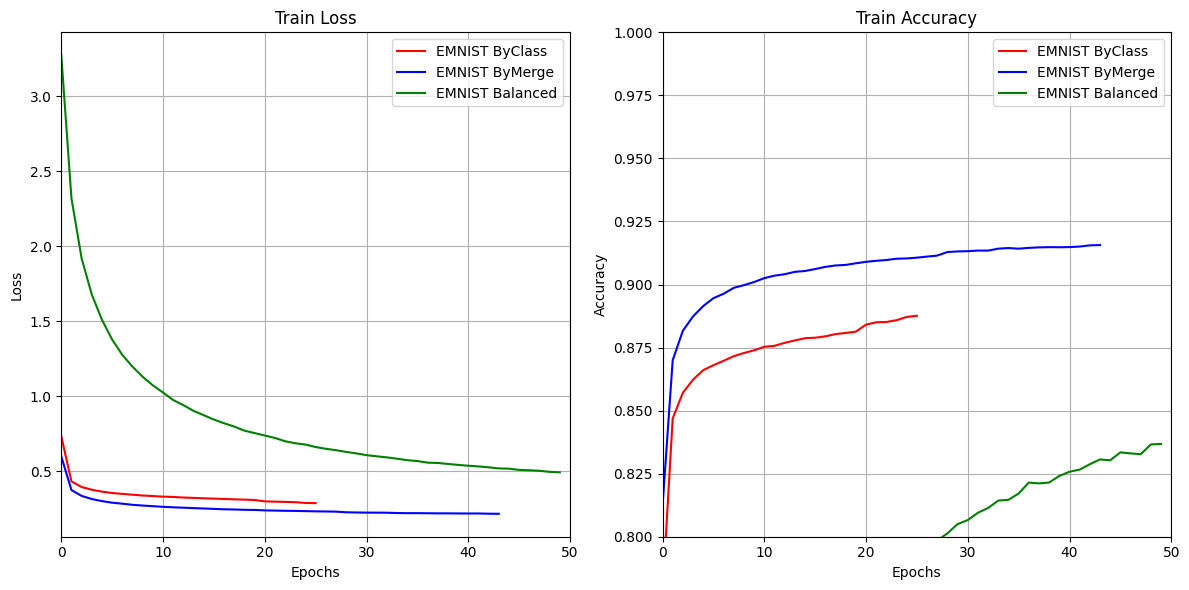

In [ ]:
for i, h in zip(range(1, 4), history):
    history_dict = {key: list(map(float, value)) for key, value in h.history.items()}
    save_history(history_dict, f'history_final_{i}_{_time}.json')

colors = ["red", "blue", "green", "purple", "gold", "orange"]

plt.figure(figsize=(12, 6))

plt.subplot(121)
for idx, hist in enumerate(history):
    plt.plot(hist.history['loss'], label=f'{results["Trained Dataset"][idx]}', color=colors[idx])
    plt.title(f'Train Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.xlim([0, EPOCHS])
    plt.grid(True)
    plt.legend()
plt.subplot(122)
for idx, hist in enumerate(history):
    plt.plot(hist.history['accuracy'], label=f'{results["Trained Dataset"][idx]}', color=colors[idx])
    plt.title(f'Train Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.xlim([0, EPOCHS])
    plt.ylim([0.8, 1])
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.savefig(f"{result_path}/result_final_{_time}.png")
plt.show()

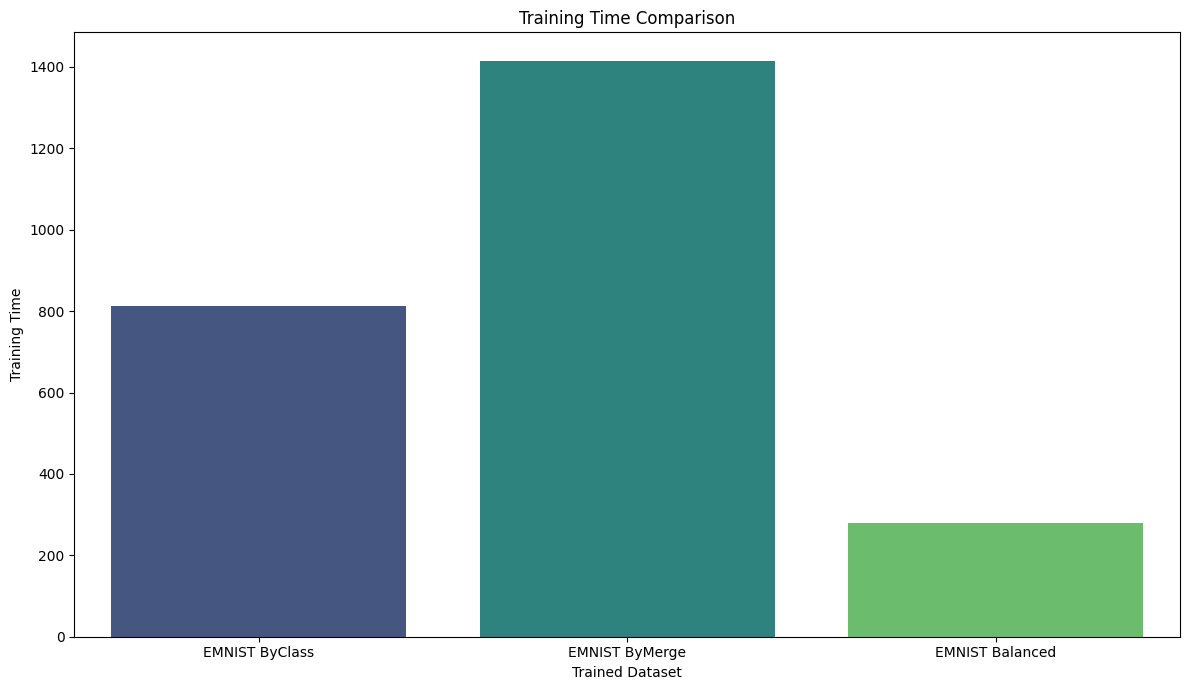

In [ ]:
metrics = ["Training Time"]
for metric in metrics:
    plt.figure(figsize=(12, 7))
    sns.barplot(x="Trained Dataset", y=metric, hue="Trained Dataset", data=results_df, palette="viridis", legend=False)
    plt.title(f'{metric} Comparison')
    plt.ylabel(metric)
    plt.xlabel('Trained Dataset')
    plt.tight_layout()
    plt.savefig(f'{result_path}/{metric.lower().replace(" ", "_")}_comparison_final_{_time}.png')
    plt.show()

results = {'Trained Dataset': [], 'Tested Dataset': [], 'Loss': [], 'Accuracy': [], 'F1 Score': []}


class_to_merge = {36: 36, 37: 37, 38: 12, 39: 38, 40: 39, 41: 40, 42: 41, 43: 42, 44: 18, 45: 19, 46: 20, 47: 21,
                  48: 22, 49: 43, 50: 24, 51: 25, 52: 44, 53: 45, 54: 28, 55: 46, 56: 30, 57: 31, 58: 32, 59: 33, 60: 34, 61: 35}
merge_to_class = {36: 36, 37: 37, 12: 38, 38: 39, 39: 40, 40: 41, 41: 42, 42: 43, 18: 44, 19: 45, 20: 46, 21: 47,
                  22: 48, 43: 49, 24: 50, 25: 51, 44: 52, 45: 53, 28: 54, 46: 55, 30: 56, 31: 57, 32: 58, 33: 59, 34: 60, 35: 61}

In [ ]:
dataset_names = ['EMNIST ByClass', 'EMNIST ByMerge', 'EMNIST Balanced']
models = [model_final_byclass, model_final_bymerge, model_final_balanced]
datasets = [(x_test, y_test_int), (x_test_bymerge, y_test_int_bymerge), (x_test_balanced, y_test_int_balanced)]

In [ ]:
def label_transform(label):
    if 0 <= label <= 9:
        return str(label)
    elif 10 <= label <= 35:
        return chr(label + ord('A') - 10)
    elif 36 <= label <= 61:
        return chr(label + ord('a') - 36)
    else:
        return str(label)


def label_transform_merge(label):
    if 0 <= label <= 9:
        return str(label)
    elif label in [10, 11, 13, 14, 15, 16, 17, 23, 26, 27, 29]:
        return chr(label + ord('A') - 10)
    elif 10 <= label <= 35:
        return chr(label + ord('A') - 10) + '/' + chr(label + ord('a') - 10)
    elif label == 36:
        return 'a'
    elif label == 37:
        return 'b'
    elif label == 38:
        return 'd'
    elif label == 39:
        return 'e'
    elif label == 40:
        return 'f'
    elif label == 41:
        return 'g'
    elif label == 42:
        return 'h'
    elif label == 43:
        return 'n'
    elif label == 44:
        return 'q'
    elif label == 45:
        return 'r'
    elif label == 46:
        return 't'
    else:
        return str(label)  # 그 외의 숫자는 그대로 문자열로 반환

In [ ]:
results = {'Trained Dataset': [], 'Tested Dataset': [],  'Loss': [], 'Accuracy': [], 'F1 Score': [], }

In [ ]:
from sklearn.metrics import accuracy_score, log_loss

3636/3636 [==============================] - 9s 2ms/step
EMNIST ByClass (Trained) on EMNIST ByClass (Tested) Time: 28.20s
3636/3636 [==============================] - 10s 3ms/step
EMNIST ByClass (Trained) on EMNIST ByMerge (Tested) Time: 22.81s
588/588 [==============================] - 1s 2ms/step
EMNIST ByClass (Trained) on EMNIST Balanced (Tested) Time: 2.63s
3636/3636 [==============================] - 9s 2ms/step
EMNIST ByMerge (Trained) on EMNIST ByClass (Tested) Time: 22.75s
3636/3636 [==============================] - 8s 2ms/step
EMNIST ByMerge (Trained) on EMNIST ByMerge (Tested) Time: 24.05s
588/588 [==============================] - 1s 2ms/step
EMNIST ByMerge (Trained) on EMNIST Balanced (Tested) Time: 3.46s
3636/3636 [==============================] - 10s 3ms/step
EMNIST Balanced (Trained) on EMNIST ByClass (Tested) Time: 23.13s
3636/3636 [==============================] - 6s 2ms/step
EMNIST Balanced (Trained) on EMNIST ByMerge (Tested) Time: 20.53s
588/588 [===============

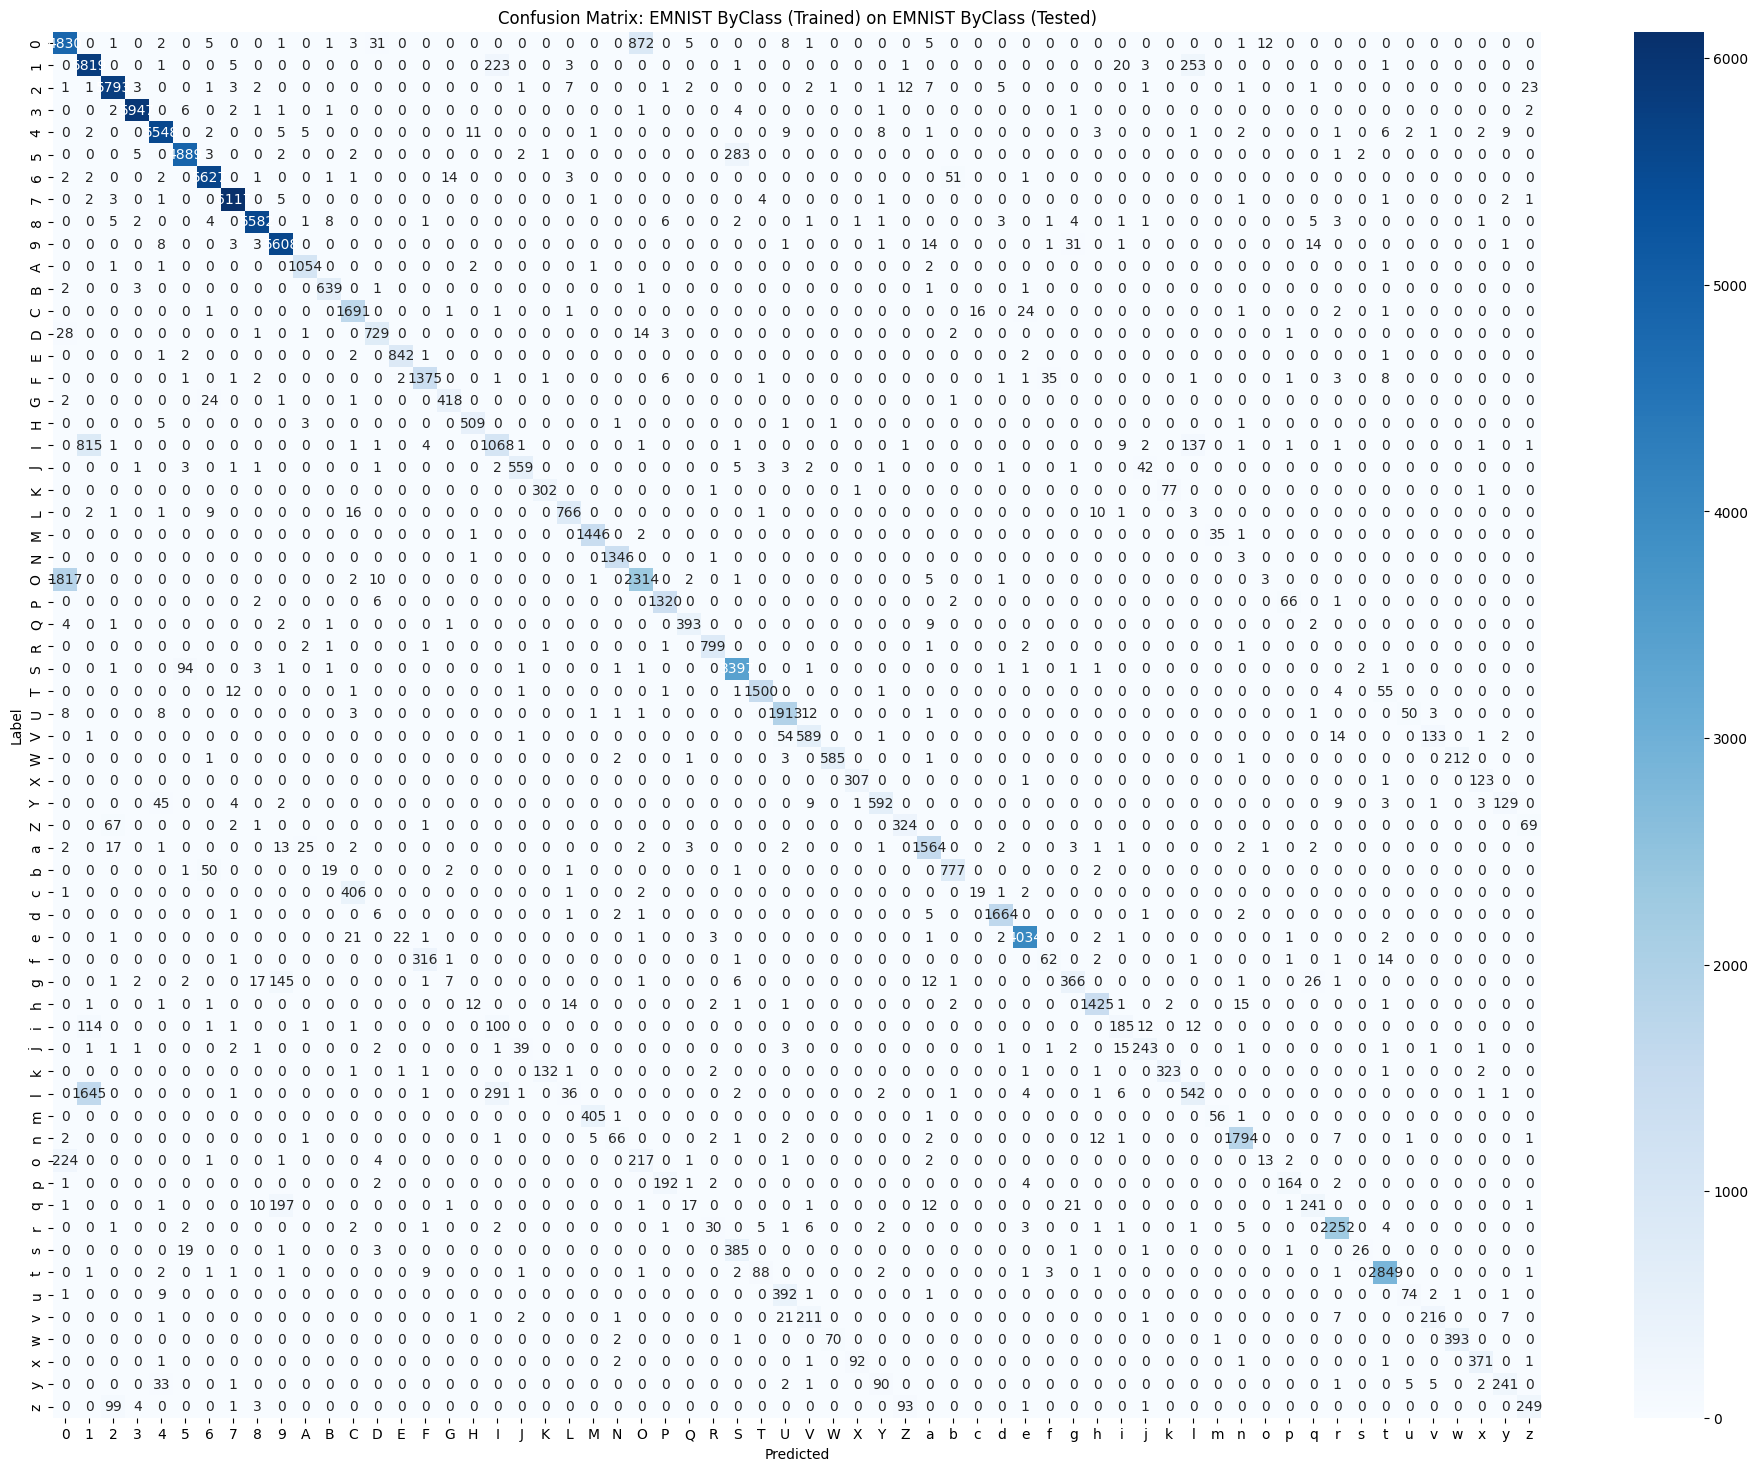

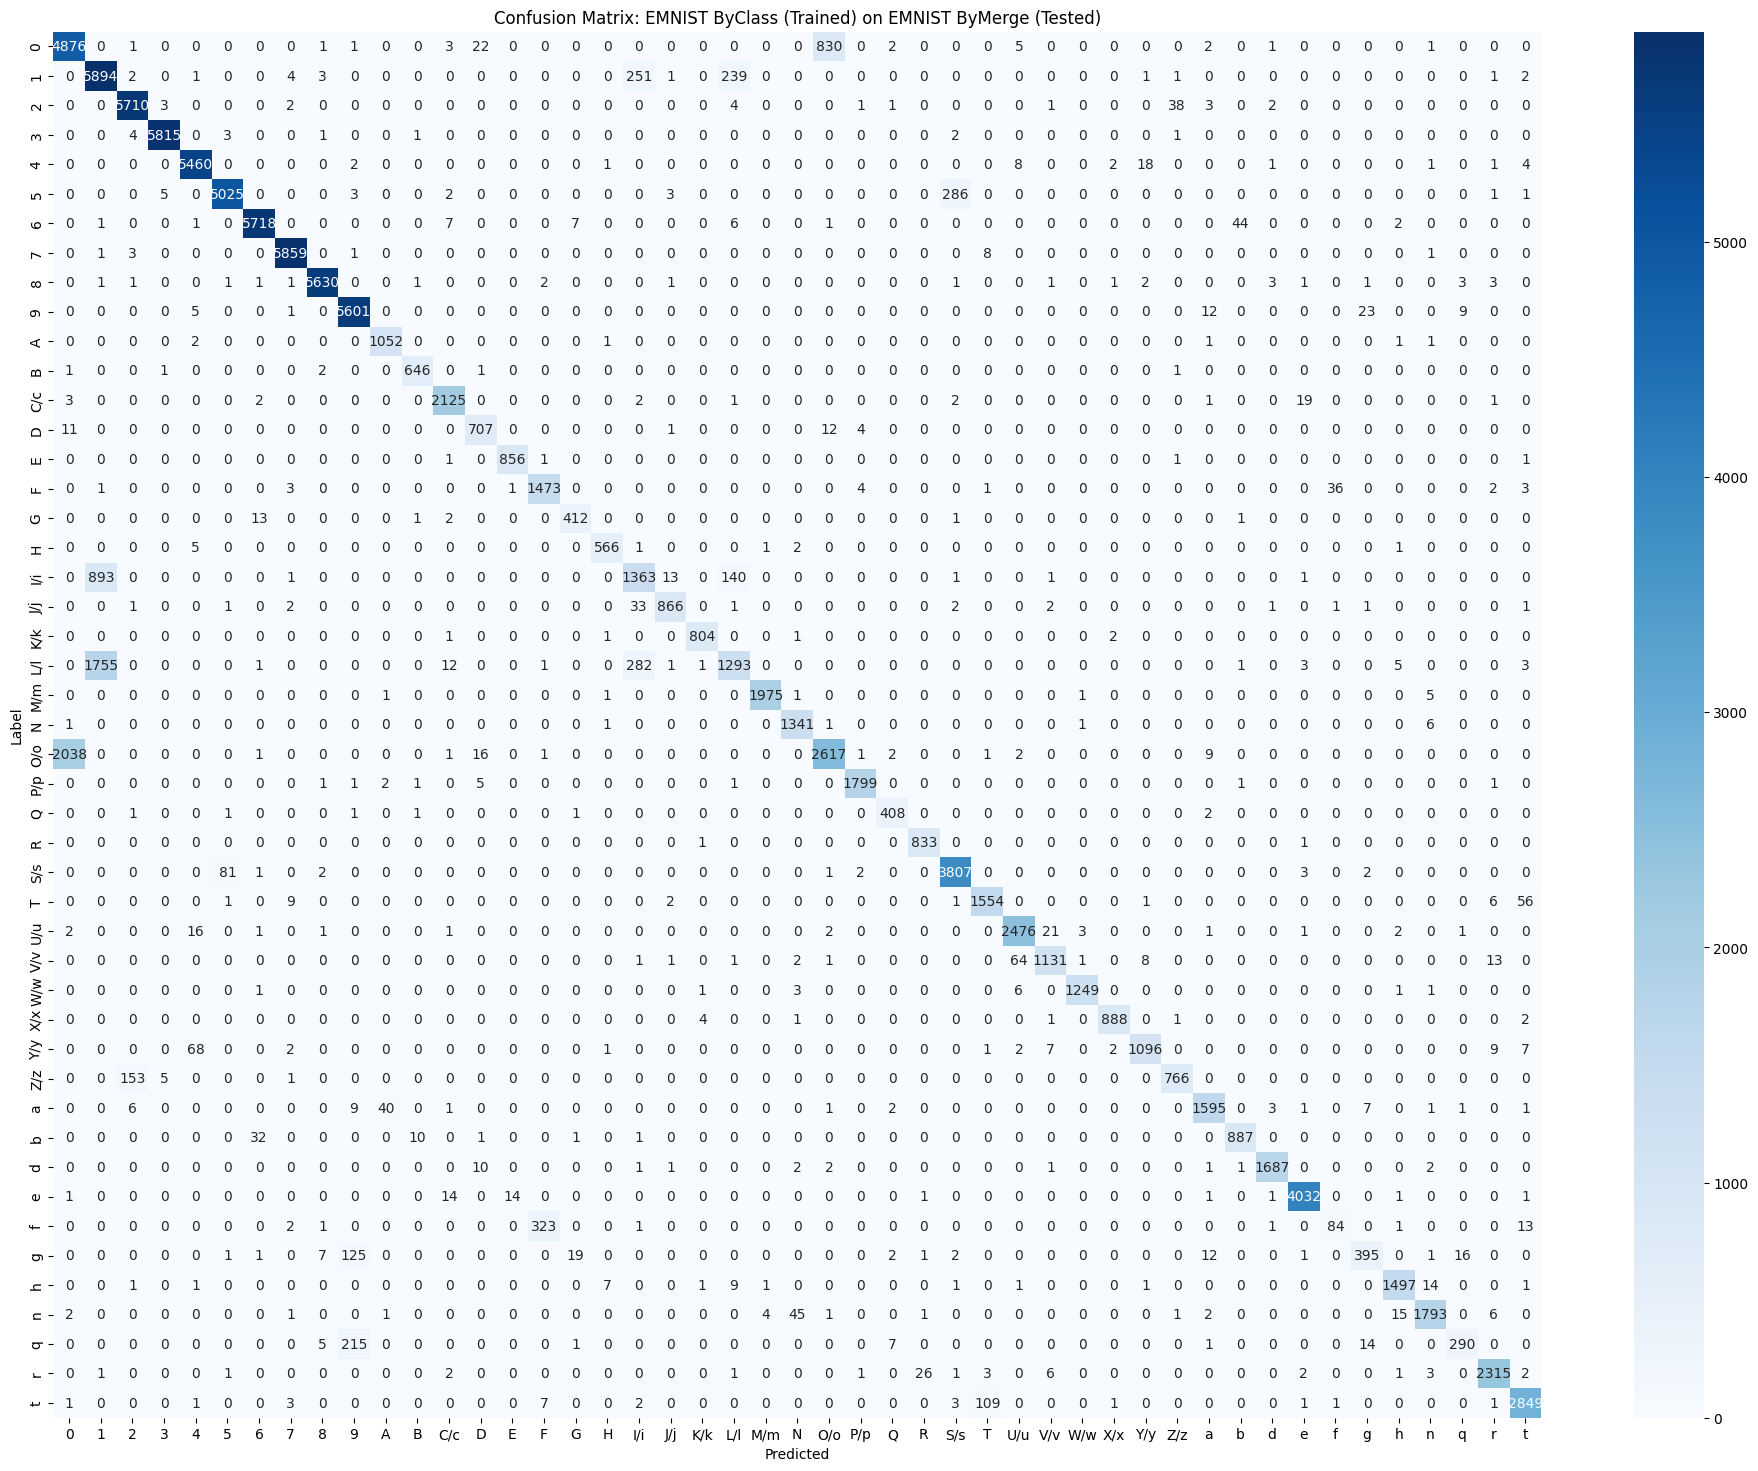

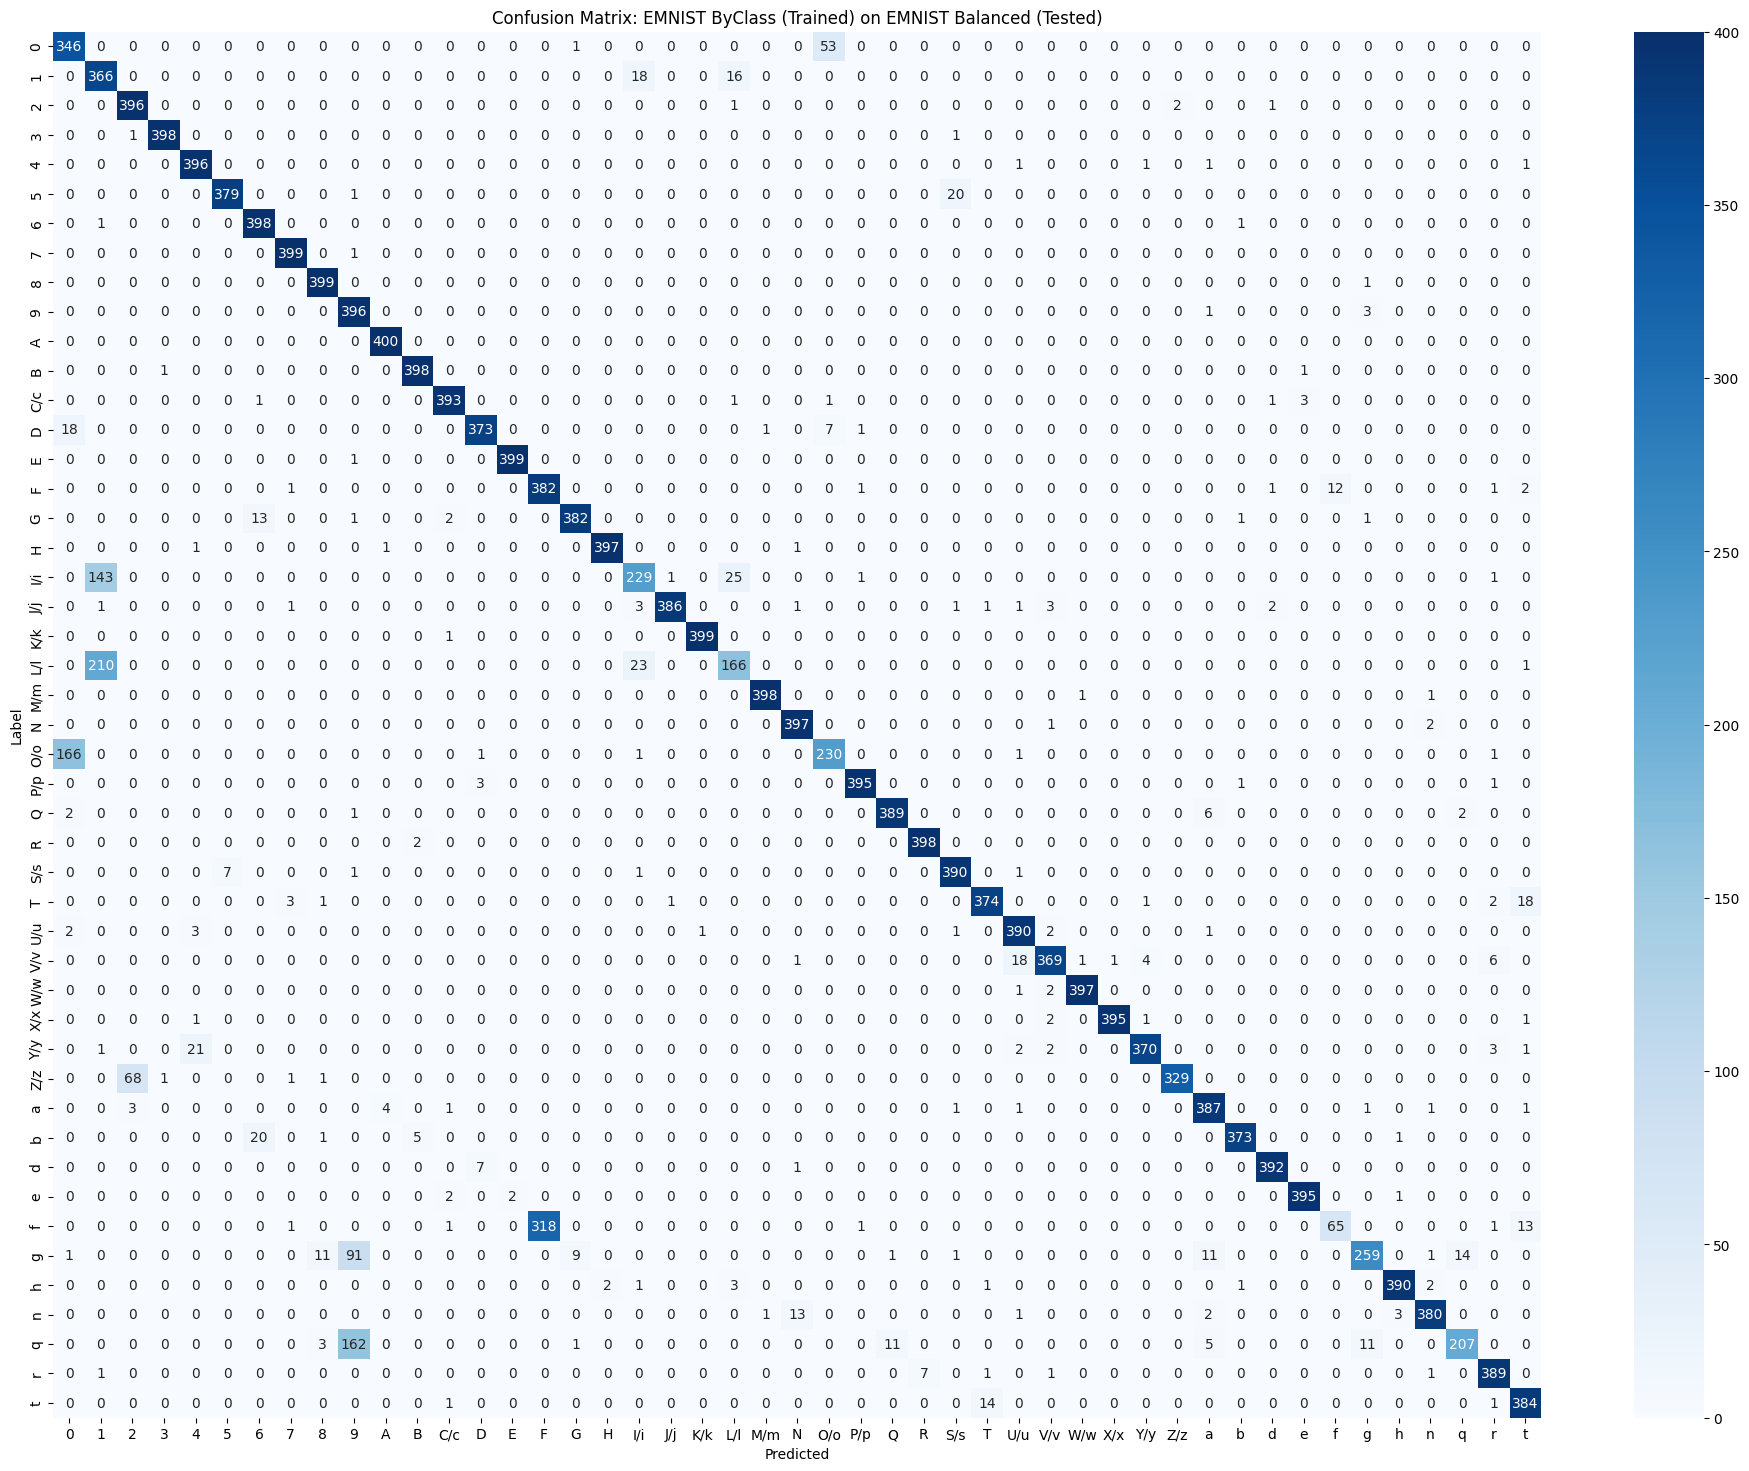

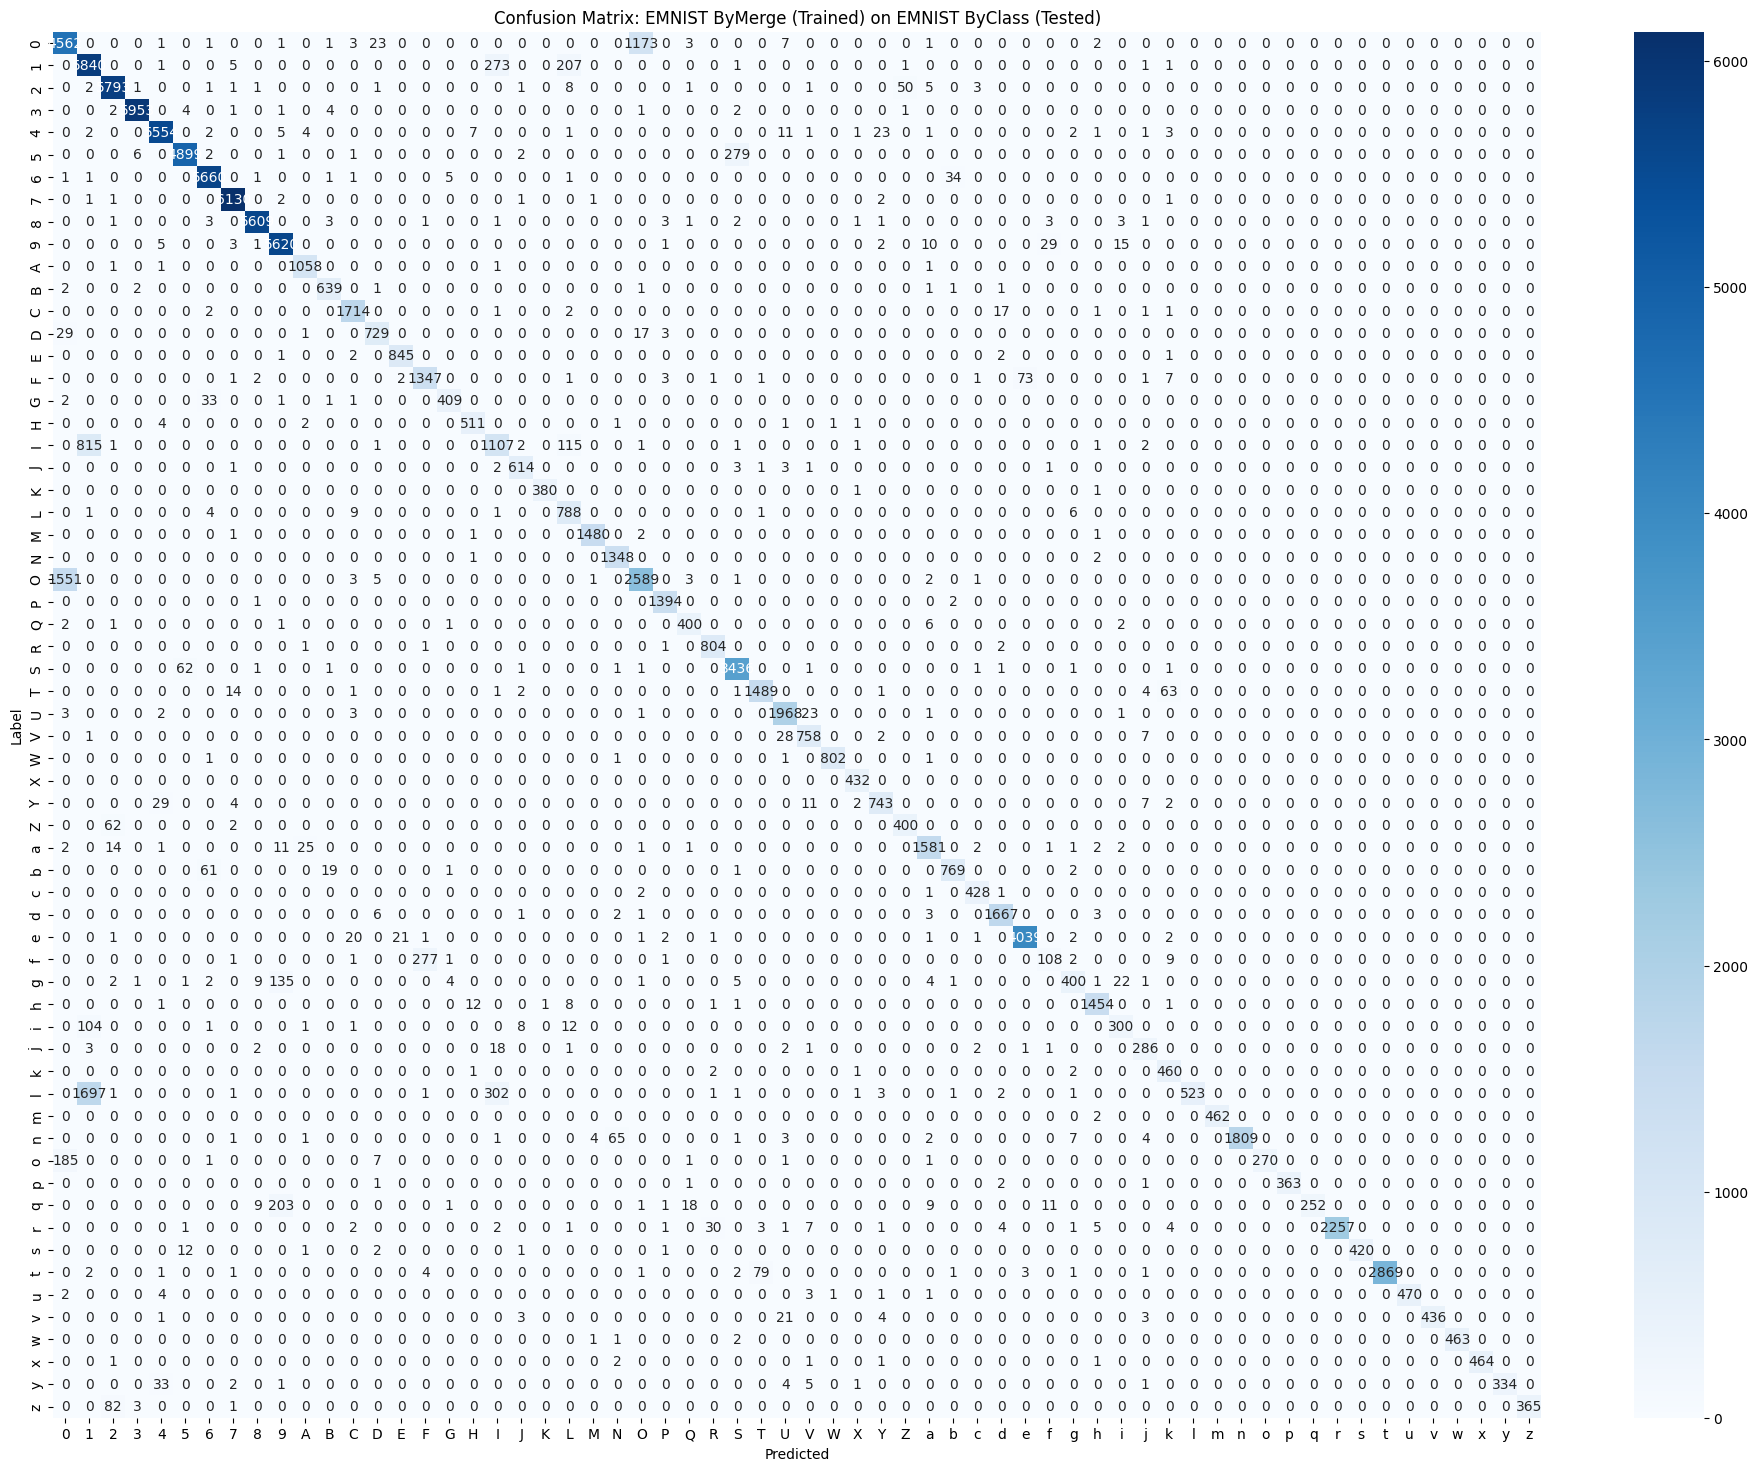

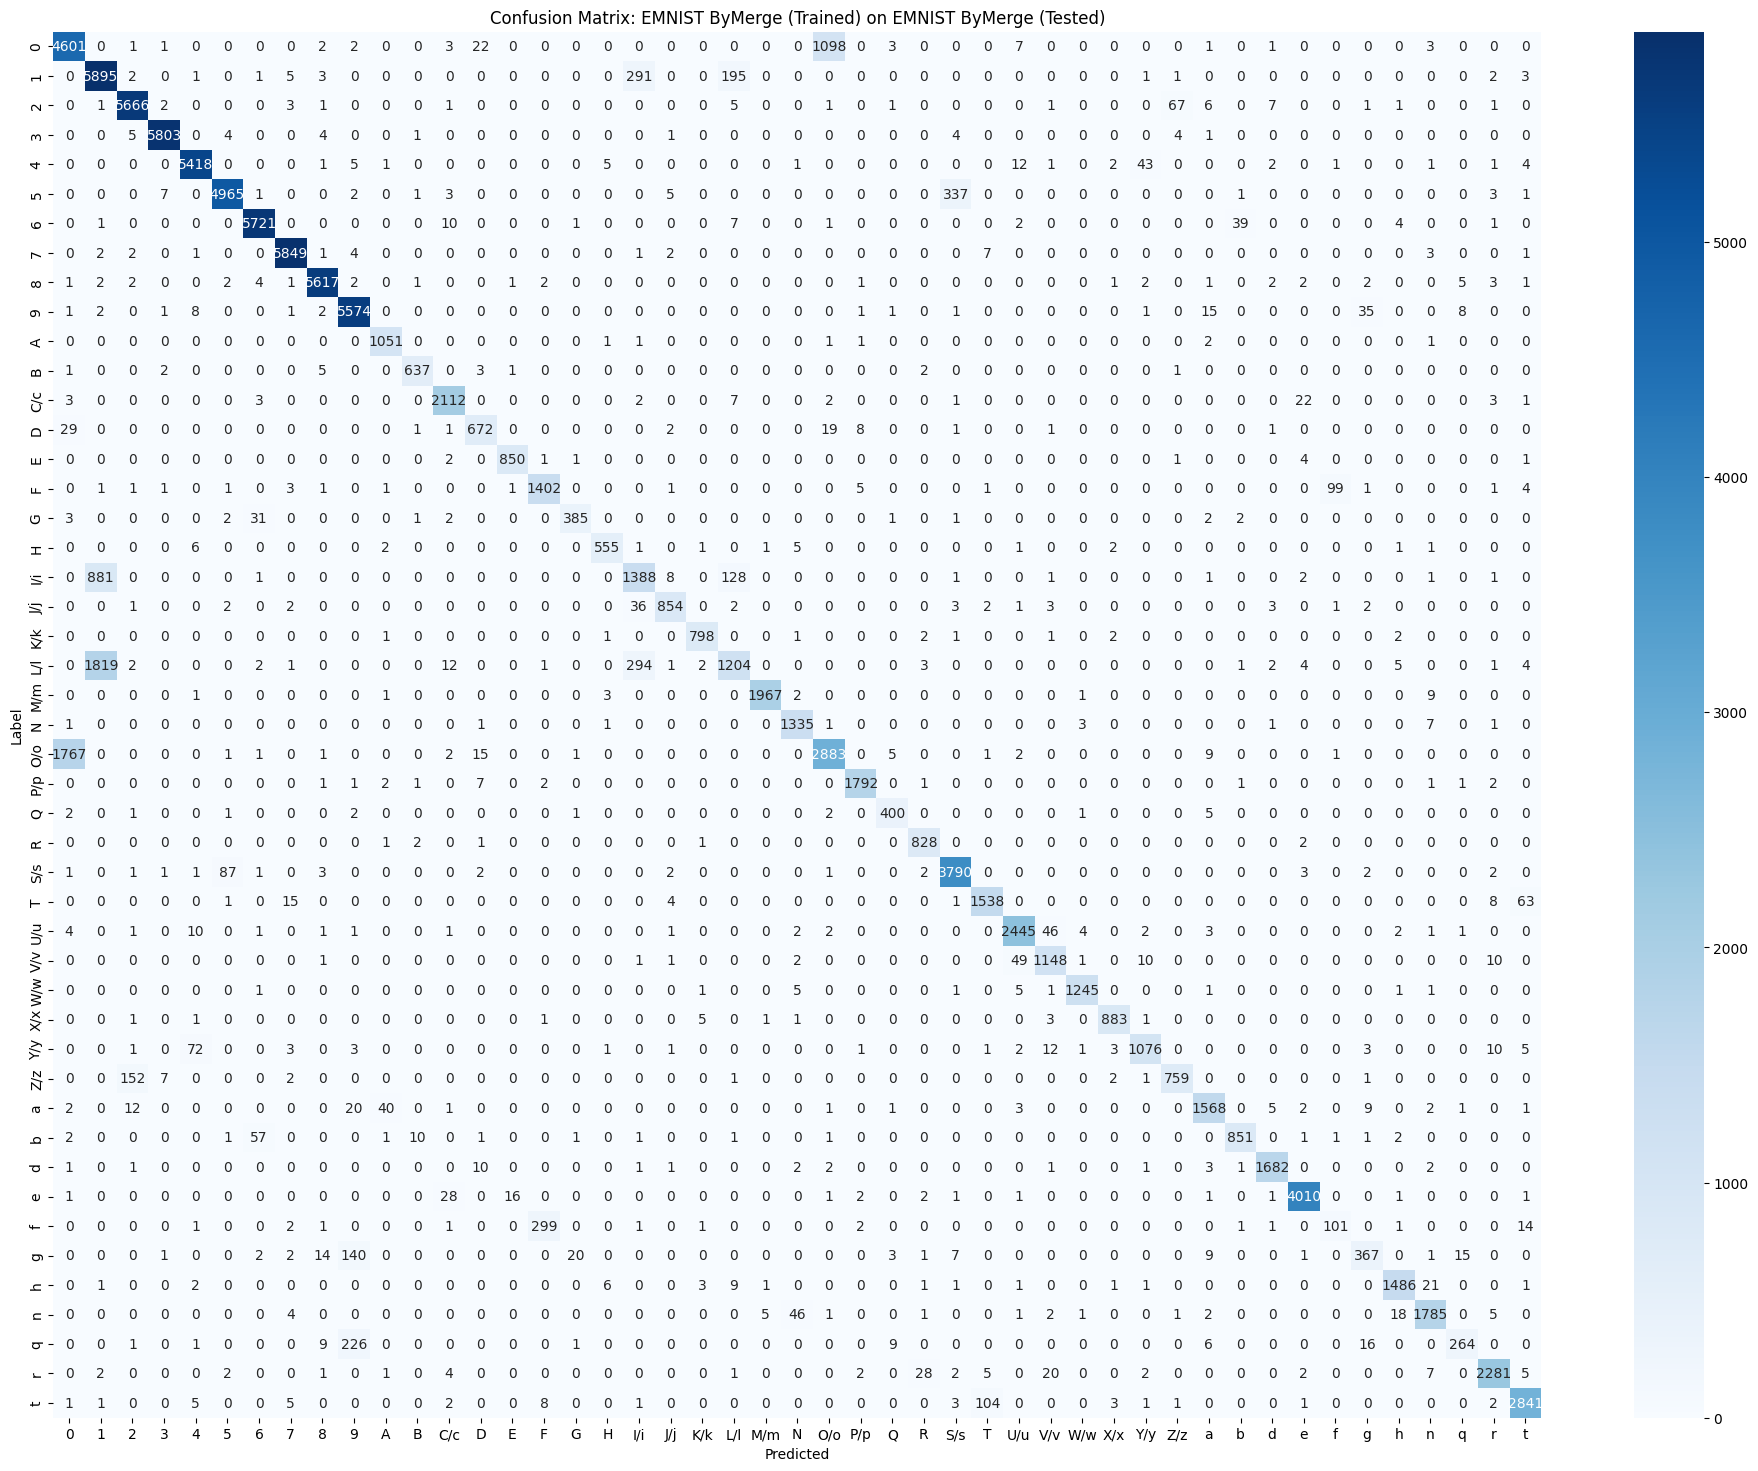

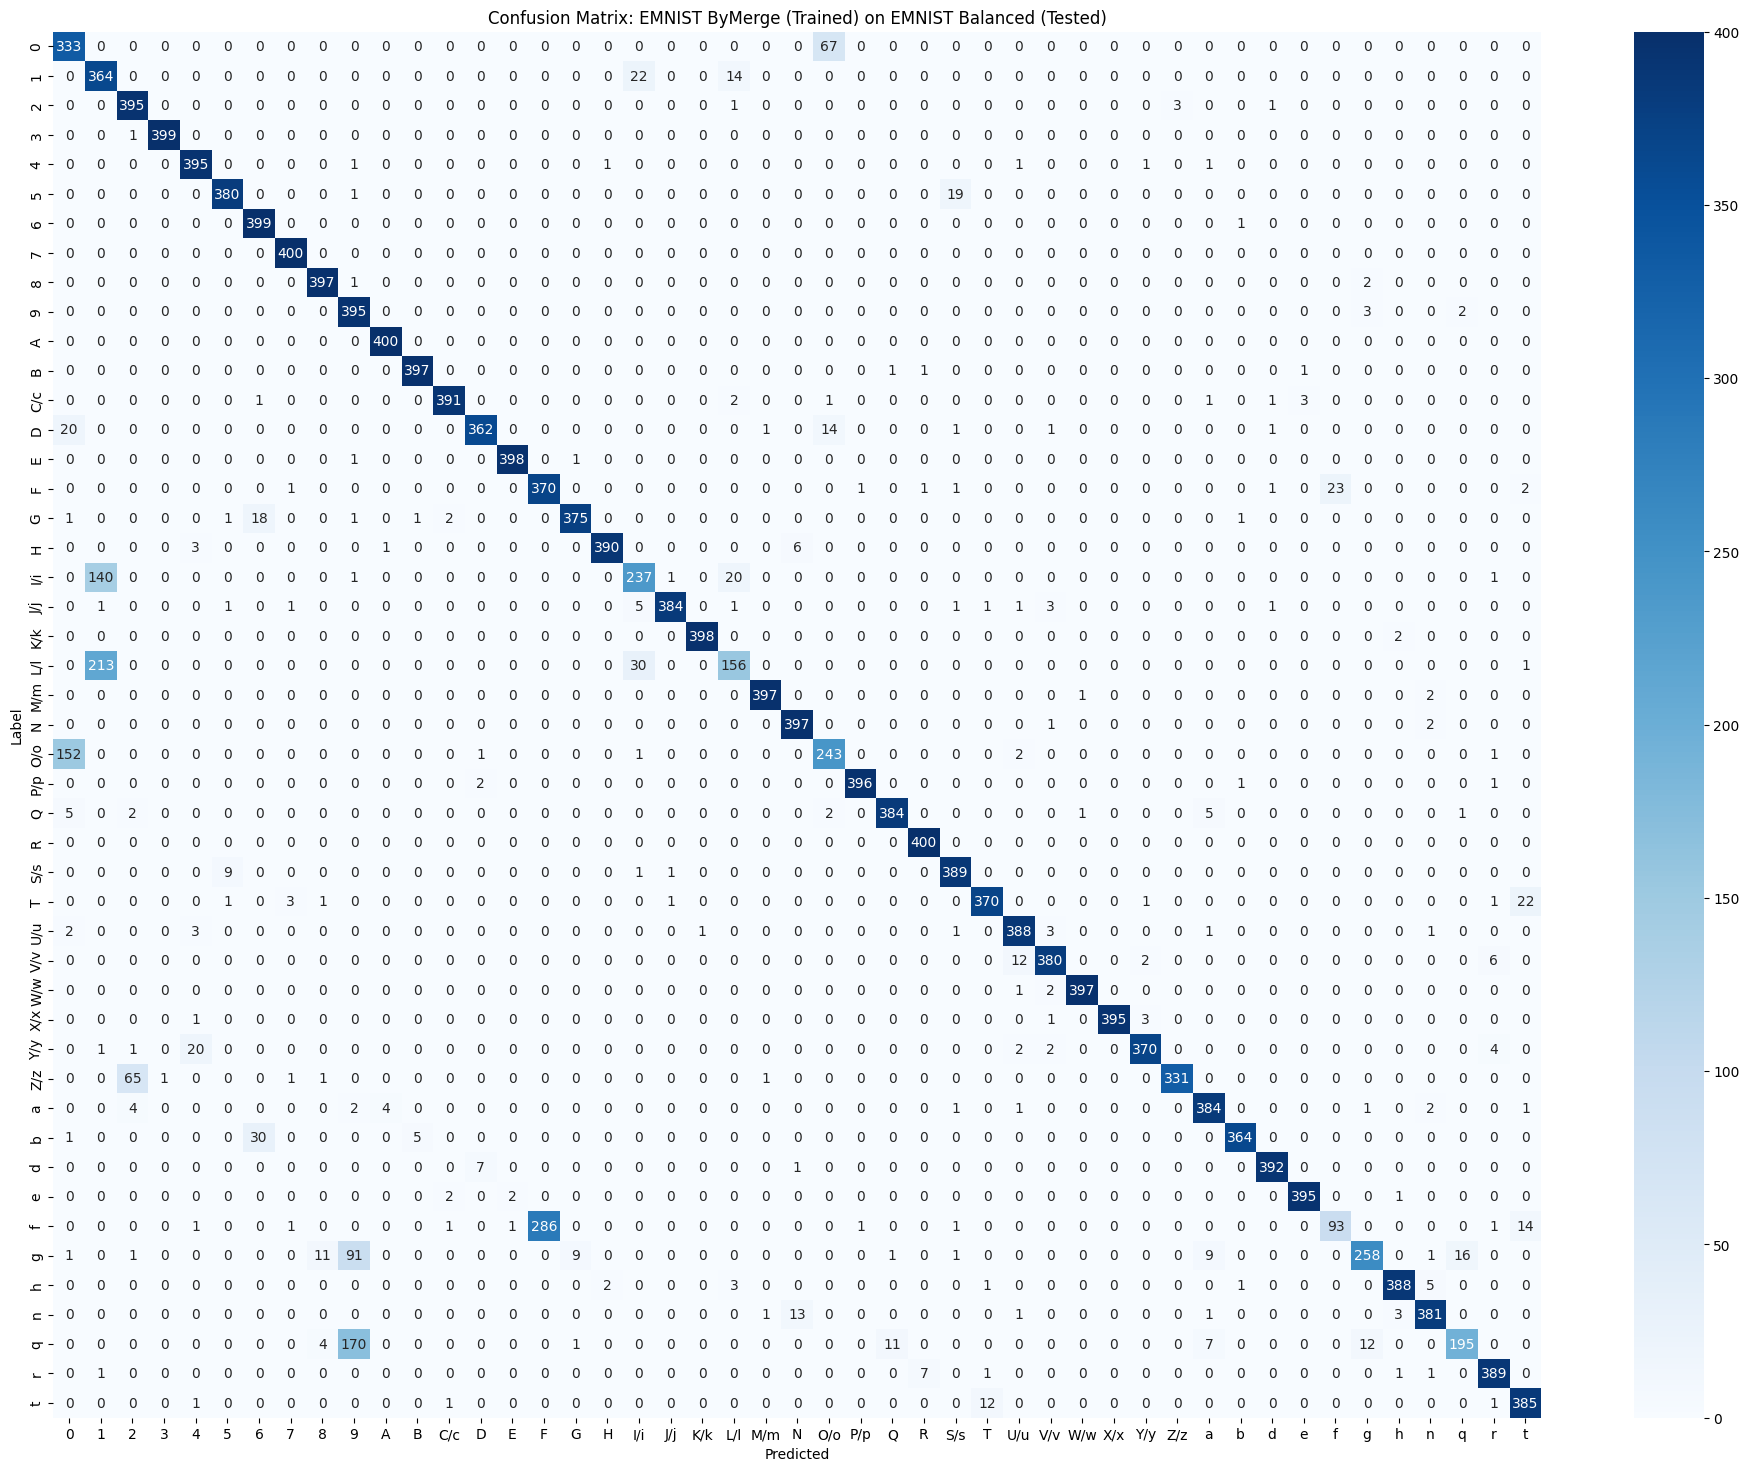

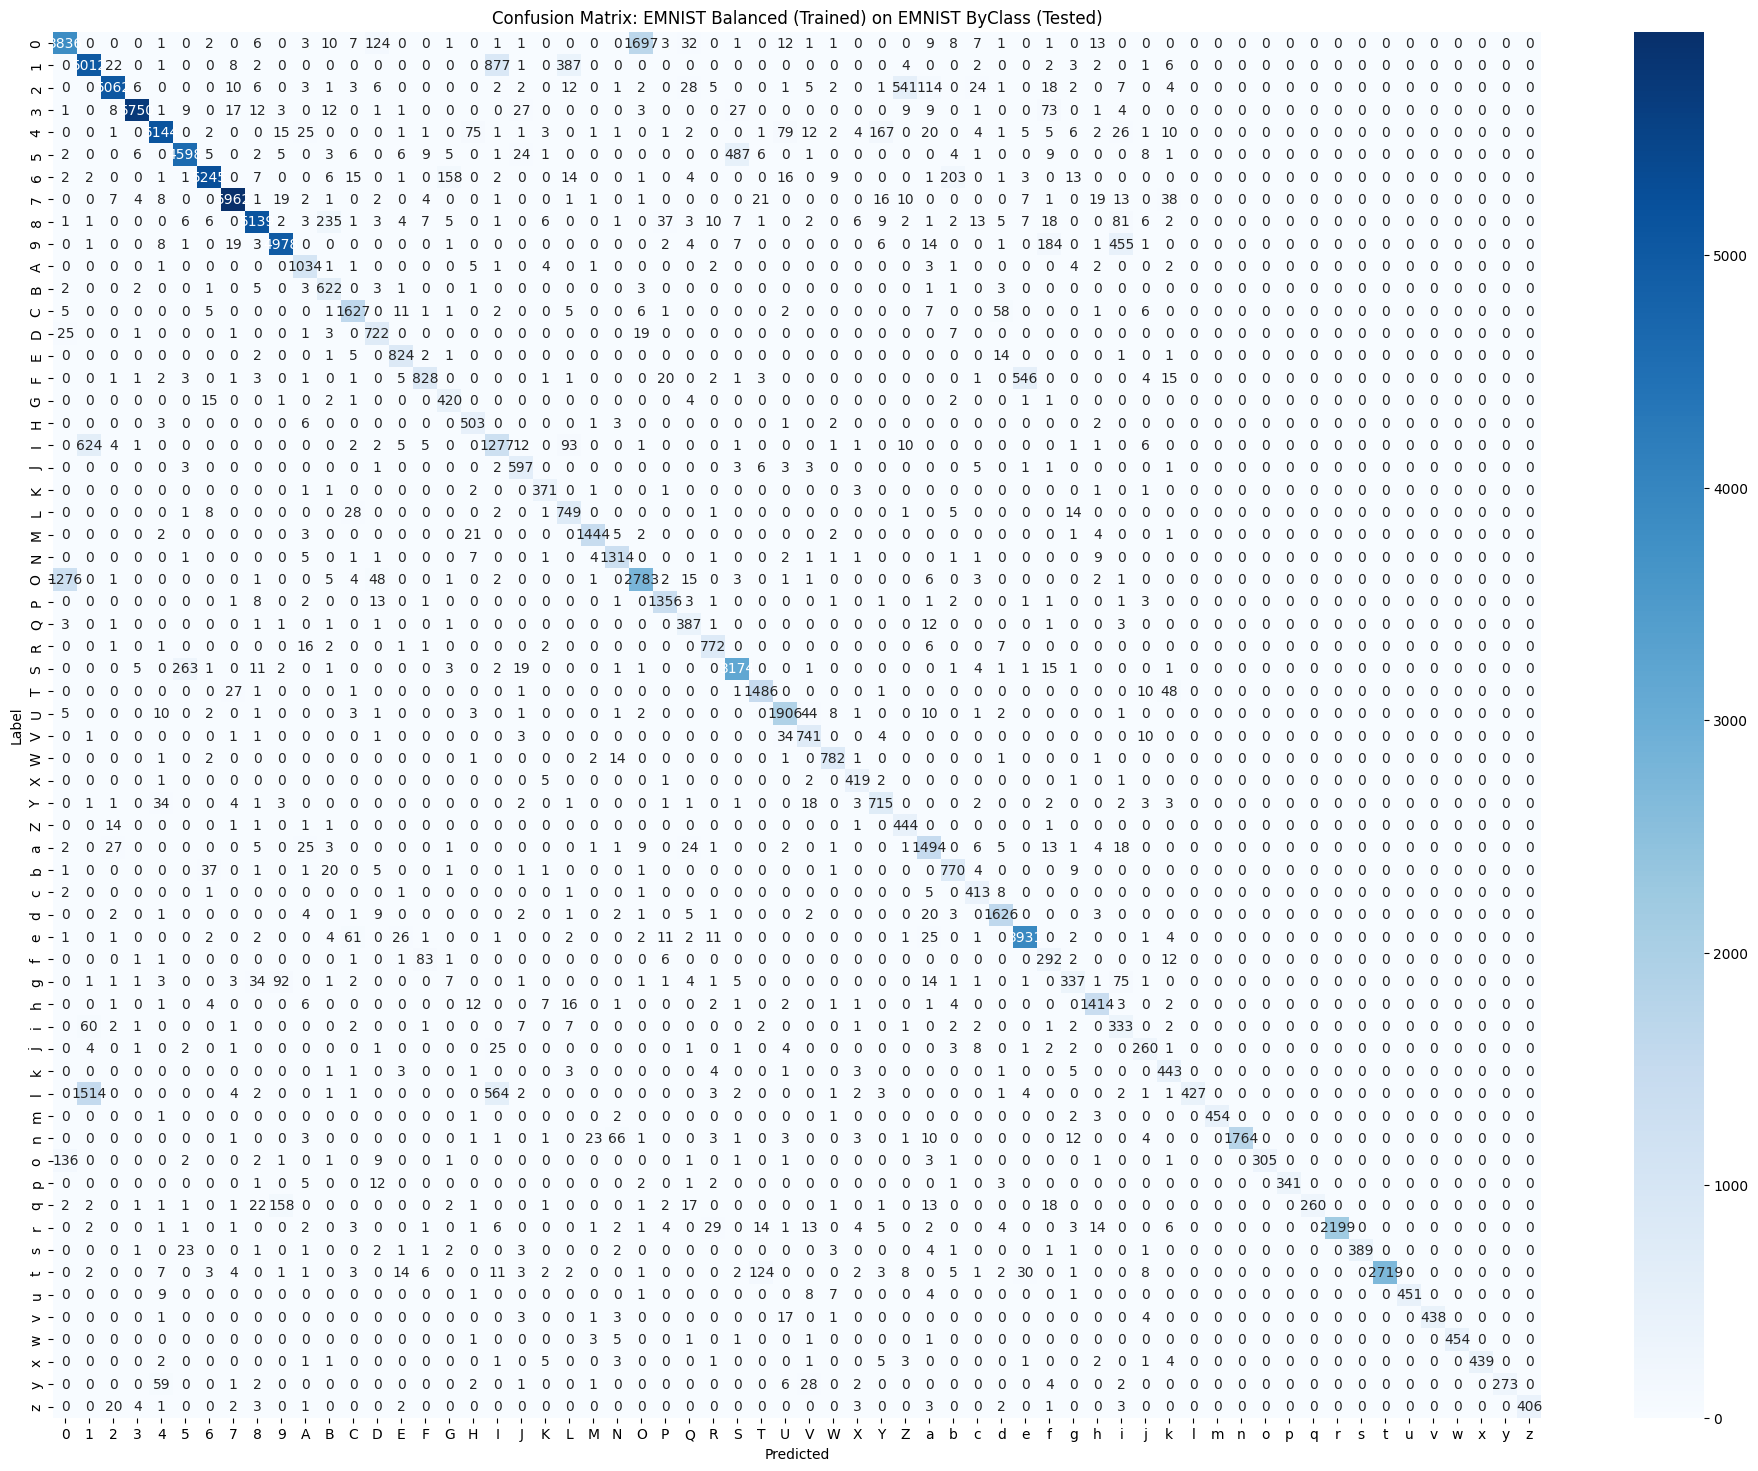

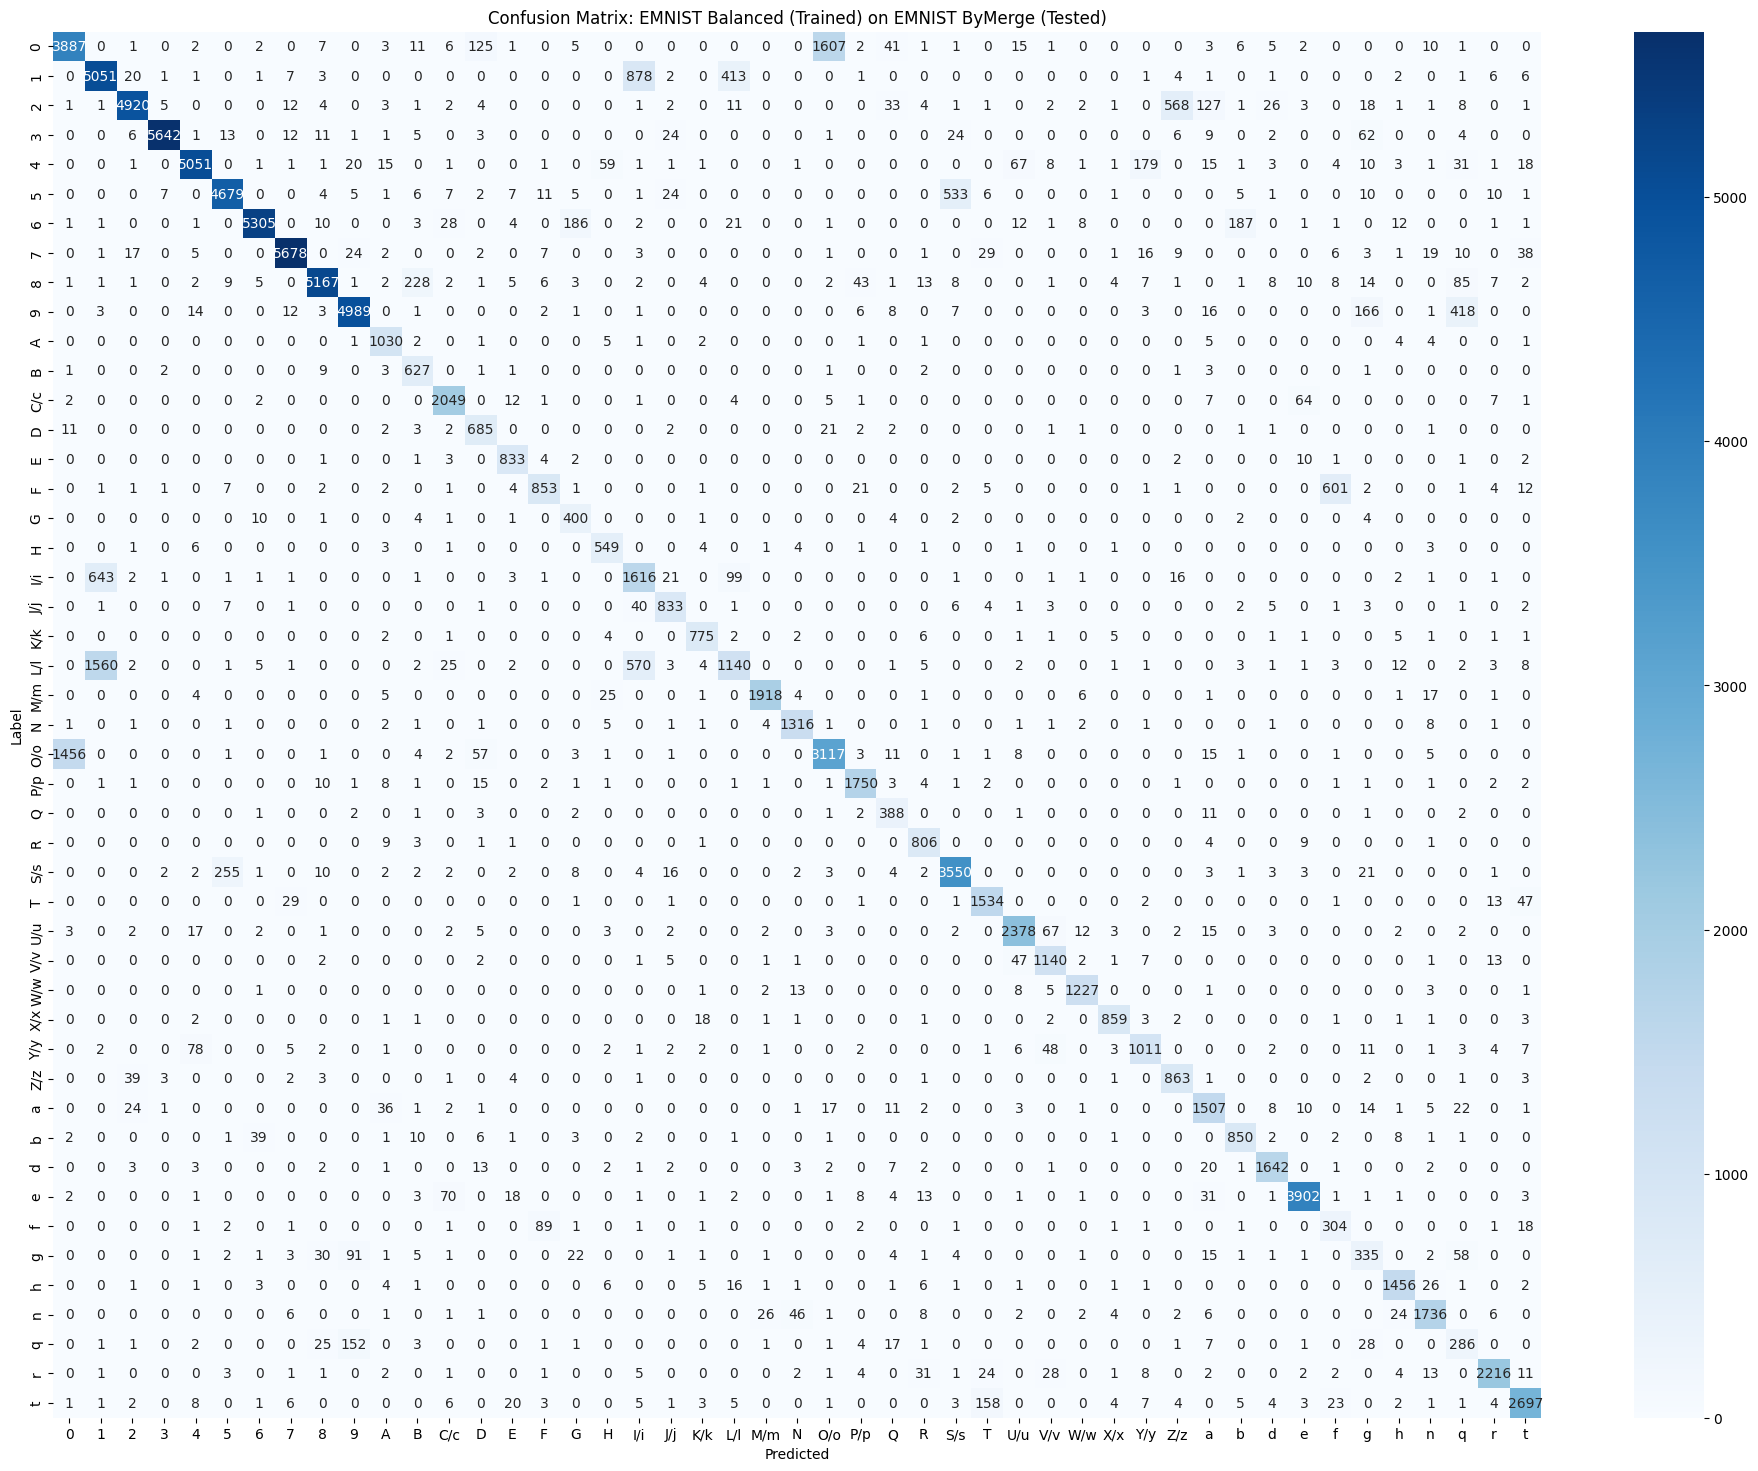

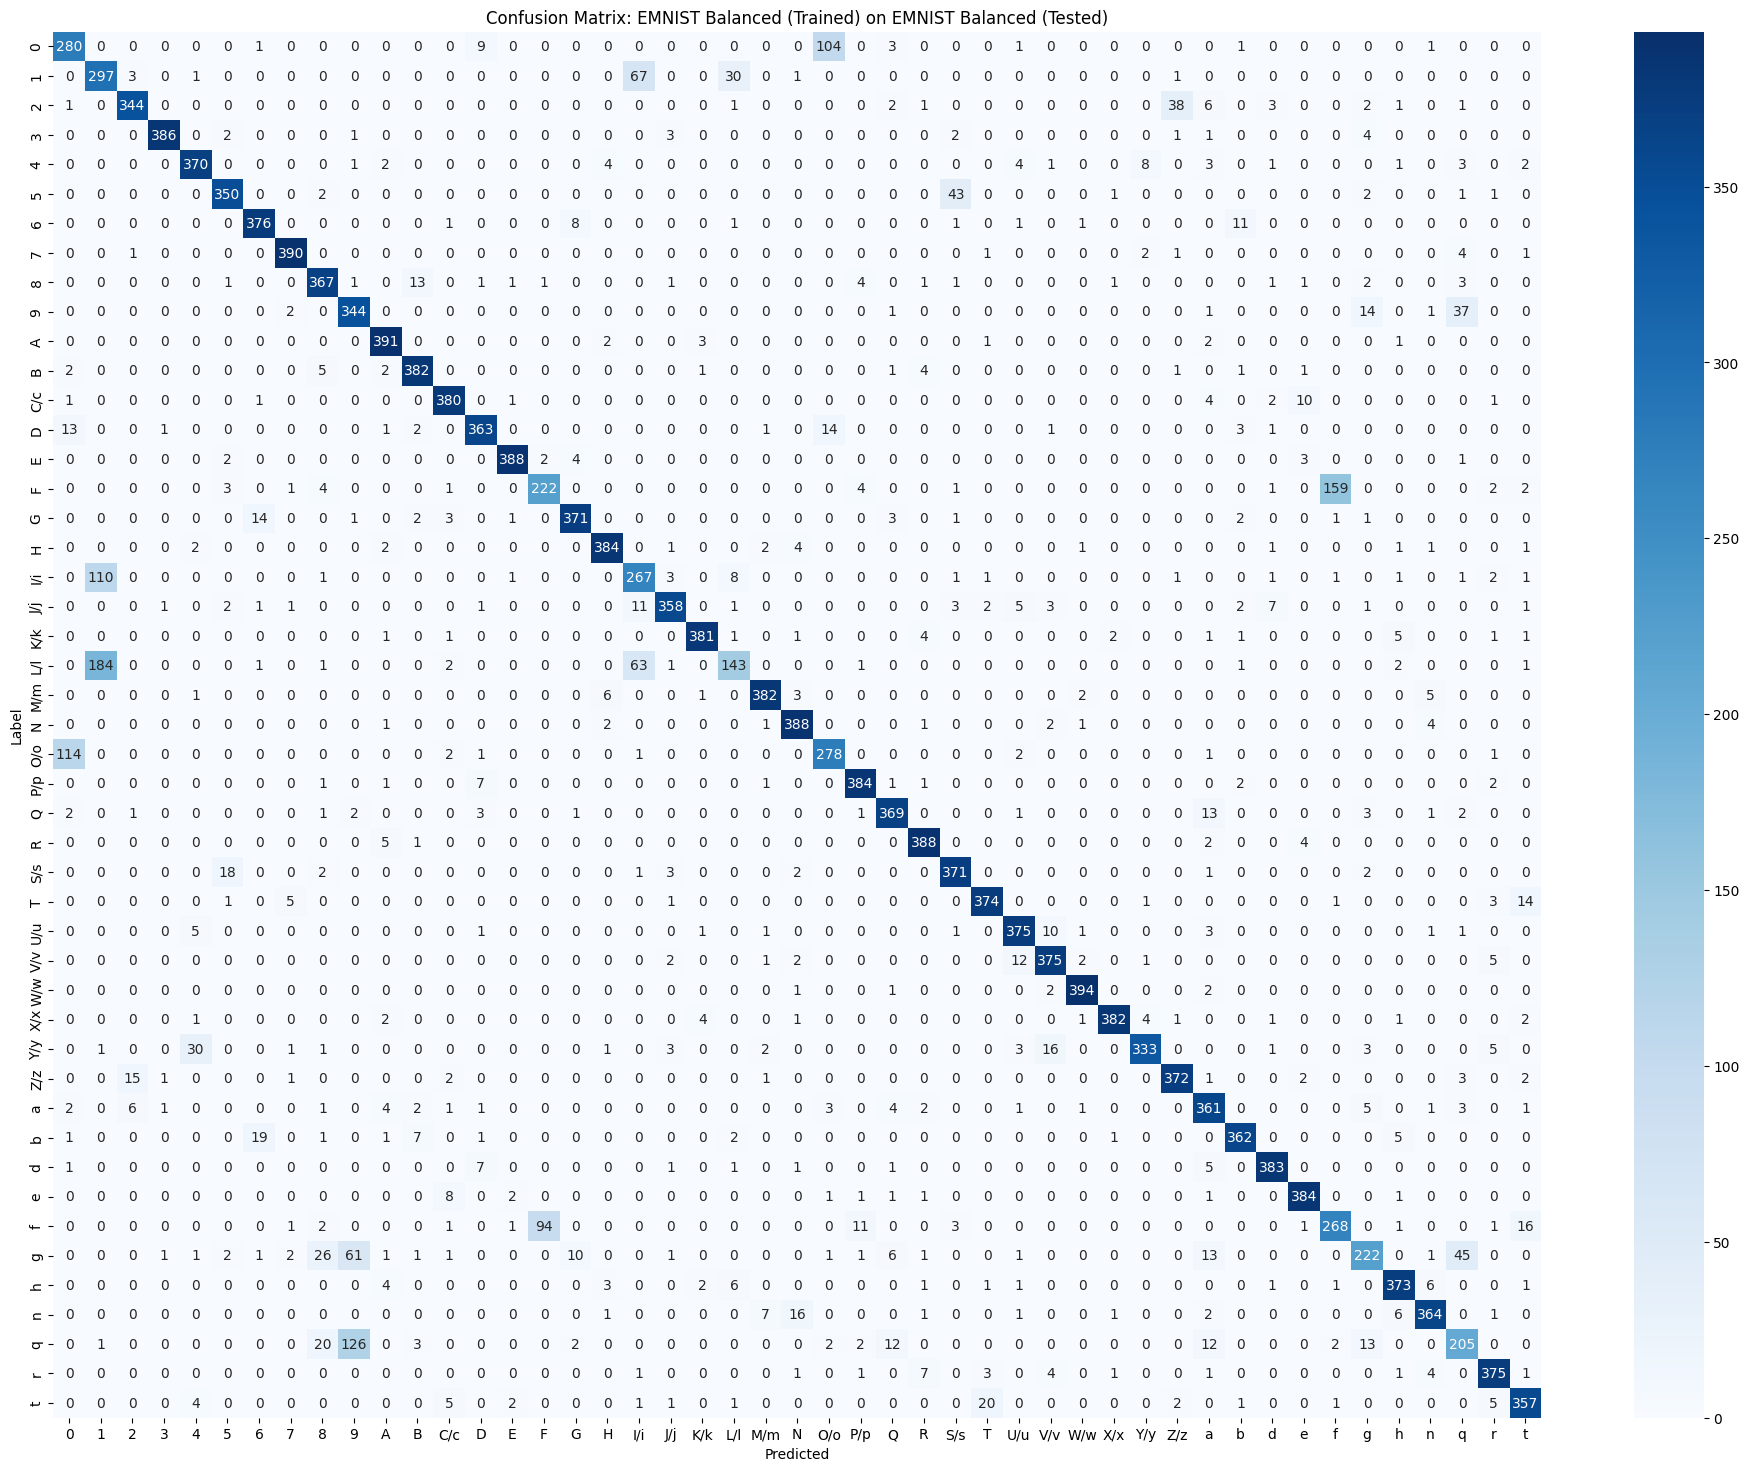

In [ ]:
for trained_dataset, model in zip(dataset_names, models):
    for tested_dataset, (x_test_data, y_test_data) in zip(dataset_names, datasets):
        start_time = time.time()
        loss, accuracy = model.evaluate(x_test_data, y_test_data)
        y_pred = model.predict(x_test_data).argmax(axis=-1)
        end_time = time.time()
        print(f'{trained_dataset} (Trained) on {tested_dataset} (Tested) Time: {end_time - start_time:.2f}s')
        unique_labels = np.unique(y_test_data)
        transformed_labels = []

        if tested_dataset != 'EMNIST ByClass':
            transformed_labels = [label_transform_merge(label) for label in unique_labels]
        else:
            transformed_labels = [label_transform(label) for label in unique_labels]

        if trained_dataset == 'EMNIST ByClass' and tested_dataset != 'EMNIST ByClass':
            y_pred_transformed = [class_to_merge.get(value, value) for value in y_pred]
            y_pred = y_pred_transformed
            accuracy = accuracy_score(y_test_data, y_pred)

        elif trained_dataset != 'EMNIST ByClass' and tested_dataset == 'EMNIST ByClass':
            y_pred_transformed = [merge_to_class[y_pred[i]]
                                  if y_pred[i] in merge_to_class and merge_to_class[y_pred[i]] == y_test_data[i]
                                  else y_pred[i] for i in range(len(y_pred))]
            y_pred = y_pred_transformed
            accuracy = accuracy_score(y_test_data, y_pred)

        cm = confusion_matrix(y_test_data, y_pred)
        transformed_cm = []
        for row in cm:
            transformed_row = [label_transform(label) for label in row]
            transformed_cm.append(transformed_row)

        cm_df = pd.DataFrame(transformed_cm)
        csv_filename = f'{result_path}/{trained_dataset}_to_{tested_dataset}_{_time}.csv'
        cm_df.to_csv(csv_filename, index=False)

        f1 = f1_score(y_test_data, y_pred, average='weighted')

        plt.figure(figsize=(24, 18))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=transformed_labels, yticklabels=transformed_labels)
        plt.xlabel('Predicted')
        plt.ylabel('Label')
        plt.title(f'Confusion Matrix: {trained_dataset} (Trained) on {tested_dataset} (Tested)')
        plt.savefig(f'{result_path}/{trained_dataset}_to_{tested_dataset}_{_time}.png')

        results['Trained Dataset'].append(trained_dataset)
        results['Tested Dataset'].append(tested_dataset)
        results['Loss'].append(loss)
        results['Accuracy'].append(accuracy)
        results['F1 Score'].append(f1)

In [ ]:
results_df = pd.DataFrame(results)
results_df.to_csv(f'{result_path}/result_final_{_time}_2.csv', index=False)

In [ ]:
results_pivot = results_df.pivot(index='Trained Dataset', columns='Tested Dataset', values='Accuracy')
display(results_pivot)

Tested Dataset,EMNIST Balanced,EMNIST ByClass,EMNIST ByMerge
Trained Dataset,,,
EMNIST Balanced,0.869887,0.865314,0.864385
EMNIST ByClass,0.905314,0.882722,0.920849
EMNIST ByMerge,0.903027,0.920316,0.914204
